# Multi-robot Learning Over Subgoals Planning
**Multi-robot Learning over Subgoals Planning (MR-LSP)** is a planning framework that allows multiple robots to coordinate and reach a point-goal in partially-mapped environment in minimum expected distance leveraging learning. For more info, refer to the paper: [Paper](https://arxiv.org/abs/2303.16654)

In this notebook, we see how we use MR-LSP to make multiple robots reach a point goal.

In [1]:
import environments
import matplotlib.pyplot as plt
import lsp
import mrlsp
import mr_exploration

### Setting the arguments
Setting up arguments for the simulator, robot and environment

In [2]:
# Set the arguments (usually done via the command line)
args = lambda: None
args.current_seed = 2129
args.map_type = 'office2'
args.unity_path = '/unity/rail_sim.x86_64'
args.save_dir = './'
args.num_robots = 2 # the number of robots


# Robot Arguments
args.step_size = 1.8
args.num_primitives = 32
args.laser_scanner_num_points = 1024
args.field_of_view_deg = 360
args.laser_max_range_m = 18

args.inflation_radius_m = 0.75
args.base_resolution = 0.5
args.comm_range = float('inf')
args.network_file = '/data/lsp/office/training_logs/dbg/VisLSPOriented.pt'  # This is the learned model for 'office2' environment
args.disable_known_grid_correction = True

### A simulated environment
We run MR-LSP on a simulated environment. The argument `args.map_type = office2` in previous cell lets us set which environment we're running simulation in. You can choose between [`maze`, `office`, and `office2`]. In this notebook, we aim to run simulation in office2 environment.

Try changing `args.map_type` to see different maps.

NOTE: The `args.network_file` stores the path to a learned model file for `office2` environment. Therefore, in this notebook we're using `office2` environment to visualize MR-LSP planner. You could use the same learned model in `'office'` or `'maze'` environment but the performance would not be good because the newtork is trained in `'office2'` environment. However, you can simulate a non-learned *optimistic* planner in those environment to see its performance (see below on how to do that).

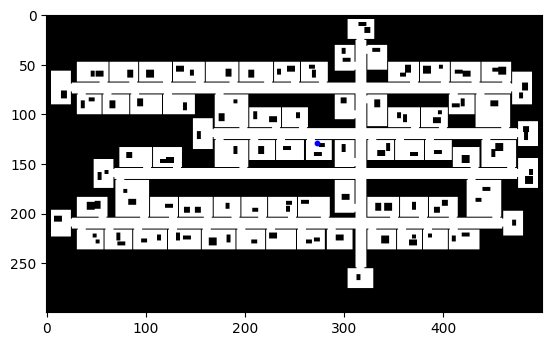

In [3]:
known_map, map_data, pose, goal = environments.generate.map_and_poses(args)

# Plotting
fig = plt.figure()
mr_exploration.utils.plotting.plot_grid_with_frontiers(ax=plt.gca(),
                                              grid_map=known_map,
                                              known_map=known_map,
                                              frontiers=[])

mr_exploration.utils.plotting.plot_pose(plt.gca(), pose, color='blue')
#mr_exploration.utils.plotting.plot_pose(plt.gca(), goal, color='green')

In the cell above, `environments.generate.map_and_poses(args)` gives the map, metadata associated with that map, the start pose, and the goal pose in the environment. We want our multiple robots to start from the start location and reach the goal location.

### Initializing robots and MR-LSP Planner
Our multiple robot team starts from the start location (`pose`) that we got from previous cell. We call `get_robot_team` function to get a list of robots that have `pose` as starting position.

#### Planner
We initialize MR-LSP planner by `mrlsp.planners.MRLearnedSubgoalPlanner(robot_team, goal_poses, args)'`. If you want to simulate a non-learned *optimistic* planner, change the line to
```python
planner = mrlsp.planners.MROptimisticPlanner(robot_team, goal_poses, args)
```

In [4]:
start_poses = [pose for _ in range(args.num_robots)]
#goal_poses = [goal for _ in range(args.num_robots)]

# Get robot team
robot_team = mr_exploration.utils.utility.get_robot_team(num_robots=args.num_robots,
                                                start_poses=start_poses,
                                                primitive_length=args.step_size,
                                                num_primitives=args.num_primitives,
                                                map_data=map_data)

# Initialize planner
# planner = mrlsp.planners.MRLearnedSubgoalPlanner(robot_team, goal_poses, args)
planner = mr_exploration.planners.MROptimisticExplorePlanner(robot_team, args)

### The visual simulator and the planning loop
Learn more about the visual simulator here: ([link](https://github.com/RAIL-group/RAIL-group-software/blob/main/resources/notebooks/RAIL-onboarding-02-visual-simulator.ipynb)). Basically, the lines below are responsible for taking the known_map occupancy grid and setting up a simulated environment using unity game engine. `Simulator` is responsible for simulating laser scan from the robot's position, getting image from robot's panoramic camera and so on.

```python
# Instantiate the simulated environment
world = environments.simulated.OccupancyGridWorld(
        known_map,
        map_data,
        num_breadcrumb_elements=args.num_breadcrumb_elements,
        min_breadcrumb_signed_distance=4.0 * args.base_resolution)

builder = environments.simulated.WorldBuildingUnityBridge
with builder(args.unity_path) as unity_bridge:
    unity_bridge.make_world(world)
    simulator = lsp.simulators.Simulator(known_map,
                                         goal,
                                         args,
                                         unity_bridge=unity_bridge,
                                         world=world,
                                         verbose=False)
    # set the inflation radius
    simulator.frontier_grouping_inflation_radius = simulator.inflation_radius
```

#### Planning Loop
The planning loop (`mrlsp.planners.MRPlanningLoop`) is responsible to make get observations from the robot and making the robot move towards the subgoal. It works in the following way:
1) Till any robot reaches the goal:
   ```python
       for counter, step_data in enumerate(planning_loop):  # 1) while loop (till any robot reaches the goal)
           # 2) take observations and give observation to the planner
           # 3) planner computes the joint-action for multi-robot team and tells planning_loop to move robots
   ```
2) The planning loop takes observation from robots sensor (lidar and panoramic camera) and gives it to the planner (MR-LSP planner
   ```python
   planner.update({'images': step_data['images']},
                    step_data['robot_grids'],
                    step_data['subgoals'],
                    step_data['robot_poses'],
                    step_data['visibility_masks'],)
   ```
3) The planner computes the joint action for the robot team and updates the planning loop. The planning loop makes the robot move towards the action (subgoals) 
   ```python
       joint_action = planner.compute_selected_subgoal()
       planning_loop.set_chosen_subgoals(joint_action, counter)
   ```

----------------------------------------
Counter: 0
Robot0: (273.00, 129.00)
Total motion: 0.00
Robot1: (273.00, 129.00)
Total motion: 0.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d749a0>, <lsp.core.Frontier object at 0x7f8335d741f0>, <lsp.core.Frontier object at 0x7f8335d74370>, <lsp.core.Frontier object at 0x7f8335d744f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d744f0>, <lsp.core.Frontier object at 0x7f8335d74370>]


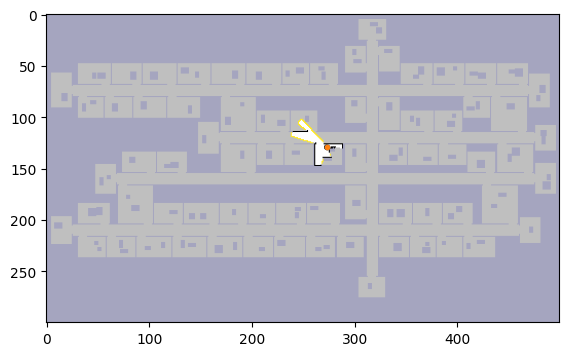

----------------------------------------
Counter: 12
Robot0: (269.54, 145.20)
Total motion: 21.60
Robot1: (272.71, 128.53)
Total motion: 21.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8337fa1d60>, <lsp.core.Frontier object at 0x7f8337fa1ac0>, <lsp.core.Frontier object at 0x7f8337fa1b80>, <lsp.core.Frontier object at 0x7f8337fa1670>, <lsp.core.Frontier object at 0x7f8337fa1f40>, <lsp.core.Frontier object at 0x7f8337fa1c10>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337fa1b80>, <lsp.core.Frontier object at 0x7f8337fa1d60>]


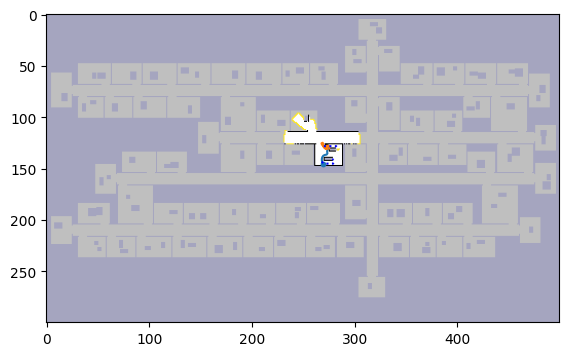

----------------------------------------
Counter: 24
Robot0: (276.59, 136.24)
Total motion: 43.20
Robot1: (264.76, 119.31)
Total motion: 43.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83380233d0>, <lsp.core.Frontier object at 0x7f83380237c0>, <lsp.core.Frontier object at 0x7f83384375b0>, <lsp.core.Frontier object at 0x7f8338437400>, <lsp.core.Frontier object at 0x7f8338023160>, <lsp.core.Frontier object at 0x7f8338023130>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83380237c0>, <lsp.core.Frontier object at 0x7f8338023160>]


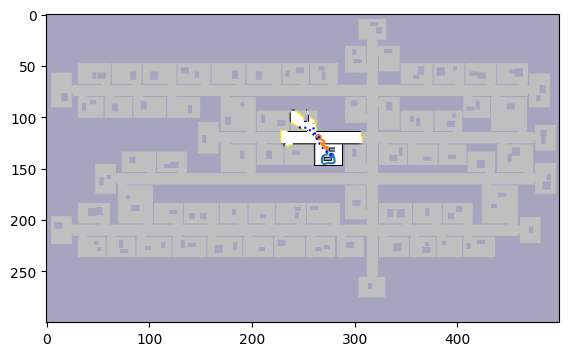

----------------------------------------
Counter: 36
Robot0: (260.42, 122.55)
Total motion: 64.80
Robot1: (258.88, 99.87)
Total motion: 64.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8337fedf10>, <lsp.core.Frontier object at 0x7f8337fedf40>, <lsp.core.Frontier object at 0x7f833808daf0>, <lsp.core.Frontier object at 0x7f8335cceb80>, <lsp.core.Frontier object at 0x7f8335ccec10>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337fedf40>, <lsp.core.Frontier object at 0x7f8335cceb80>]


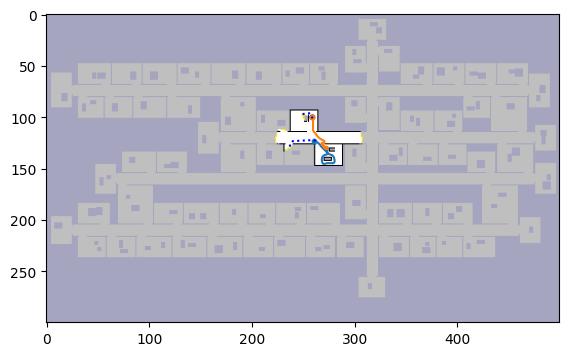

----------------------------------------
Counter: 48
Robot0: (239.55, 124.63)
Total motion: 86.40
Robot1: (249.53, 107.43)
Total motion: 86.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8338381e20>, <lsp.core.Frontier object at 0x7f8338381100>, <lsp.core.Frontier object at 0x7f8338346f40>, <lsp.core.Frontier object at 0x7f8338346dc0>, <lsp.core.Frontier object at 0x7f8338346cd0>, <lsp.core.Frontier object at 0x7f8335f372b0>, <lsp.core.Frontier object at 0x7f8338381bb0>, <lsp.core.Frontier object at 0x7f8338346d00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338346f40>, <lsp.core.Frontier object at 0x7f8338346cd0>]


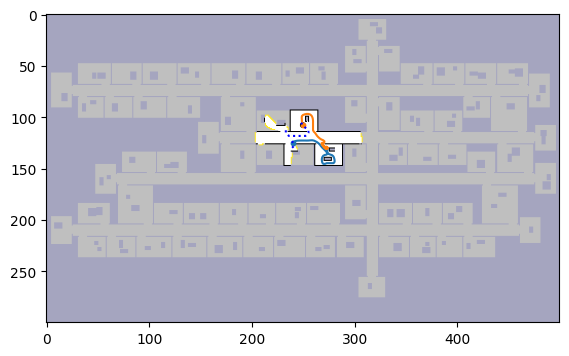

----------------------------------------
Counter: 60
Robot0: (242.90, 139.30)
Total motion: 108.00
Robot1: (245.85, 118.52)
Total motion: 108.00
Available frontiers: {<lsp.core.Frontier object at 0x7f833823f3a0>, <lsp.core.Frontier object at 0x7f833823fb50>, <lsp.core.Frontier object at 0x7f833ad2ff10>, <lsp.core.Frontier object at 0x7f833823f5b0>, <lsp.core.Frontier object at 0x7f833823f8b0>, <lsp.core.Frontier object at 0x7f833823fe50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833823fb50>, <lsp.core.Frontier object at 0x7f833823fe50>]


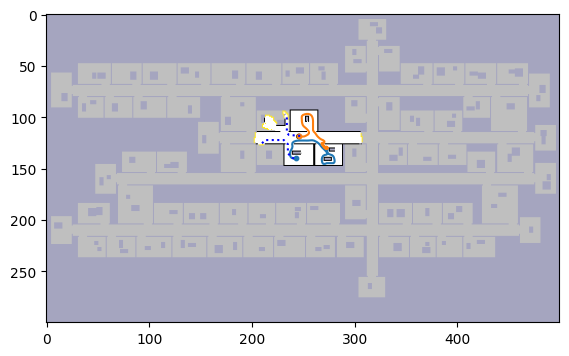

----------------------------------------
Counter: 72
Robot0: (233.34, 124.47)
Total motion: 129.60
Robot1: (234.54, 106.20)
Total motion: 129.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d6fca0>, <lsp.core.Frontier object at 0x7f8335d37a90>, <lsp.core.Frontier object at 0x7f8335d37df0>, <lsp.core.Frontier object at 0x7f8335d37a00>, <lsp.core.Frontier object at 0x7f8335d6f8e0>, <lsp.core.Frontier object at 0x7f8335d37bb0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d37df0>, <lsp.core.Frontier object at 0x7f8335d6fca0>]


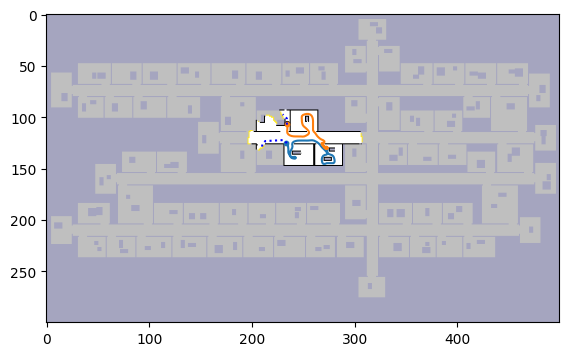

----------------------------------------
Counter: 84
Robot0: (212.79, 124.41)
Total motion: 151.20
Robot1: (218.59, 100.08)
Total motion: 151.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d8f220>, <lsp.core.Frontier object at 0x7f8335d8f100>, <lsp.core.Frontier object at 0x7f8335d8f070>, <lsp.core.Frontier object at 0x7f8335d8f040>, <lsp.core.Frontier object at 0x7f8335d8f1c0>, <lsp.core.Frontier object at 0x7f8335d8f2e0>, <lsp.core.Frontier object at 0x7f8335d8f280>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d8f280>, <lsp.core.Frontier object at 0x7f8335d8f070>]


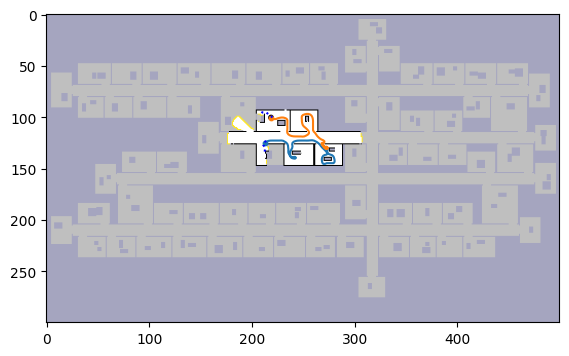

----------------------------------------
Counter: 96
Robot0: (214.27, 143.47)
Total motion: 172.80
Robot1: (211.06, 96.49)
Total motion: 172.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d8feb0>, <lsp.core.Frontier object at 0x7f8335d8f520>, <lsp.core.Frontier object at 0x7f8335d8f0a0>, <lsp.core.Frontier object at 0x7f8335d8f5b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d8f5b0>, <lsp.core.Frontier object at 0x7f8335d8f0a0>]


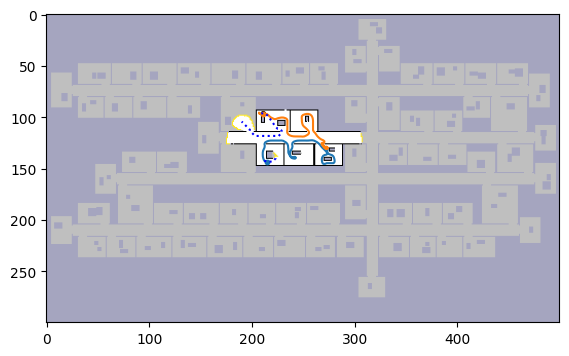

----------------------------------------
Counter: 108
Robot0: (218.80, 130.57)
Total motion: 194.40
Robot1: (224.95, 110.84)
Total motion: 194.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335cd7fd0>, <lsp.core.Frontier object at 0x7f83358fe430>, <lsp.core.Frontier object at 0x7f83358fe400>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335cd7fd0>, <lsp.core.Frontier object at 0x7f83358fe400>]


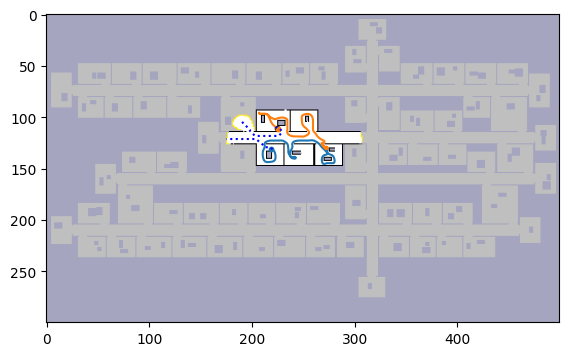

----------------------------------------
Counter: 120
Robot0: (201.02, 119.59)
Total motion: 216.00
Robot1: (216.95, 118.50)
Total motion: 216.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83357b5eb0>, <lsp.core.Frontier object at 0x7f83357b5b50>, <lsp.core.Frontier object at 0x7f83357b5e50>, <lsp.core.Frontier object at 0x7f83357b5f10>, <lsp.core.Frontier object at 0x7f83357b5670>, <lsp.core.Frontier object at 0x7f8337f88b80>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83357b5e50>, <lsp.core.Frontier object at 0x7f83357b5b50>]


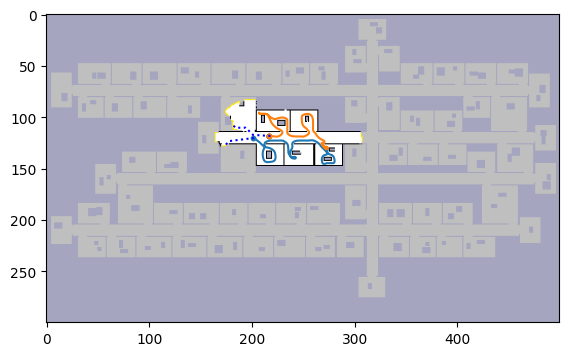

----------------------------------------
Counter: 132
Robot0: (179.87, 123.13)
Total motion: 237.60
Robot1: (197.49, 112.59)
Total motion: 237.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335a20d00>, <lsp.core.Frontier object at 0x7f8335a20eb0>, <lsp.core.Frontier object at 0x7f8335a20ee0>, <lsp.core.Frontier object at 0x7f8335a20fd0>, <lsp.core.Frontier object at 0x7f8335a20fa0>, <lsp.core.Frontier object at 0x7f8335a20340>, <lsp.core.Frontier object at 0x7f8335a20ca0>, <lsp.core.Frontier object at 0x7f8335a20e50>, <lsp.core.Frontier object at 0x7f8335a202b0>, <lsp.core.Frontier object at 0x7f8335a20c70>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a20e50>, <lsp.core.Frontier object at 0x7f8335a20fd0>]


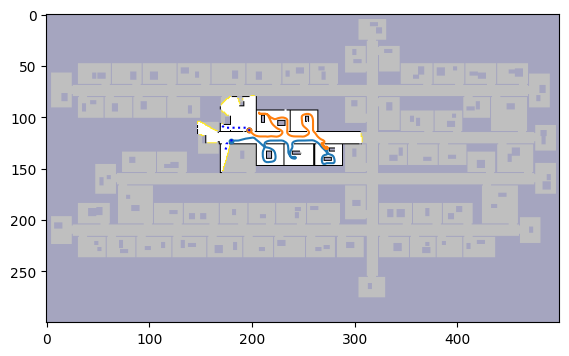

----------------------------------------
Counter: 144
Robot0: (169.14, 122.32)
Total motion: 259.20
Robot1: (176.75, 110.51)
Total motion: 259.20
Available frontiers: {<lsp.core.Frontier object at 0x7f833581dcd0>, <lsp.core.Frontier object at 0x7f833581d250>, <lsp.core.Frontier object at 0x7f833581dfd0>, <lsp.core.Frontier object at 0x7f83358cf700>, <lsp.core.Frontier object at 0x7f833581ddf0>, <lsp.core.Frontier object at 0x7f83358cf6a0>, <lsp.core.Frontier object at 0x7f833581d3d0>, <lsp.core.Frontier object at 0x7f833581de80>, <lsp.core.Frontier object at 0x7f83358cf5e0>, <lsp.core.Frontier object at 0x7f833581daf0>, <lsp.core.Frontier object at 0x7f833581df70>, <lsp.core.Frontier object at 0x7f833581d790>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833581daf0>, <lsp.core.Frontier object at 0x7f833581dfd0>]


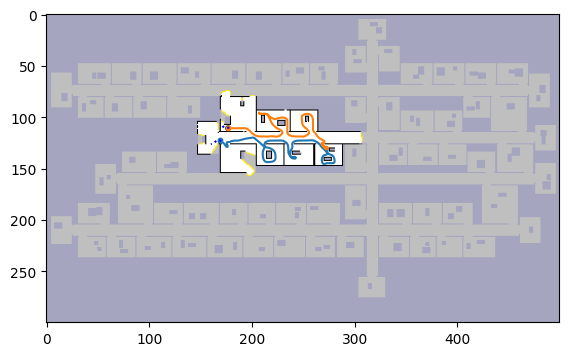

----------------------------------------
Counter: 156
Robot0: (150.38, 117.26)
Total motion: 280.80
Robot1: (174.65, 92.84)
Total motion: 280.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335cb7370>, <lsp.core.Frontier object at 0x7f8335826340>, <lsp.core.Frontier object at 0x7f8335826670>, <lsp.core.Frontier object at 0x7f8335cb70d0>, <lsp.core.Frontier object at 0x7f8335cb7250>, <lsp.core.Frontier object at 0x7f83358761f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335cb7370>, <lsp.core.Frontier object at 0x7f8335826670>]


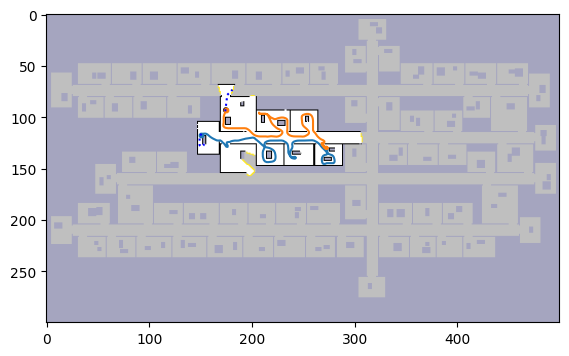

----------------------------------------
Counter: 168
Robot0: (165.20, 118.77)
Total motion: 304.20
Robot1: (182.86, 74.30)
Total motion: 304.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832e13c970>, <lsp.core.Frontier object at 0x7f832e13cc10>, <lsp.core.Frontier object at 0x7f832e13ca00>, <lsp.core.Frontier object at 0x7f832e13ca30>, <lsp.core.Frontier object at 0x7f832e13c9d0>, <lsp.core.Frontier object at 0x7f832e13c9a0>, <lsp.core.Frontier object at 0x7f832e13cb50>, <lsp.core.Frontier object at 0x7f832e13cb20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e13ca30>, <lsp.core.Frontier object at 0x7f832e13c970>]


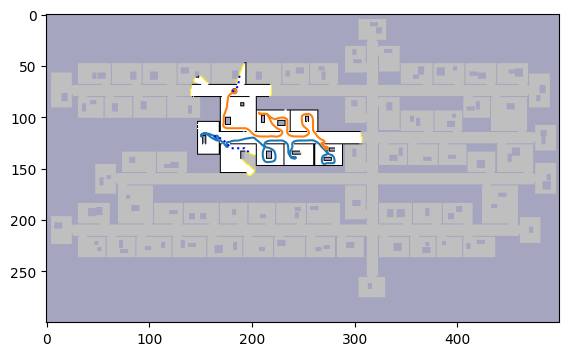

----------------------------------------
Counter: 180
Robot0: (182.34, 130.53)
Total motion: 325.80
Robot1: (189.52, 55.43)
Total motion: 325.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e13ce80>, <lsp.core.Frontier object at 0x7f8335826100>, <lsp.core.Frontier object at 0x7f8337f88a00>, <lsp.core.Frontier object at 0x7f832e13cc70>, <lsp.core.Frontier object at 0x7f832e13cca0>, <lsp.core.Frontier object at 0x7f832e13c490>, <lsp.core.Frontier object at 0x7f832e13cee0>, <lsp.core.Frontier object at 0x7f832e13c940>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e13cca0>, <lsp.core.Frontier object at 0x7f832e13cc70>]


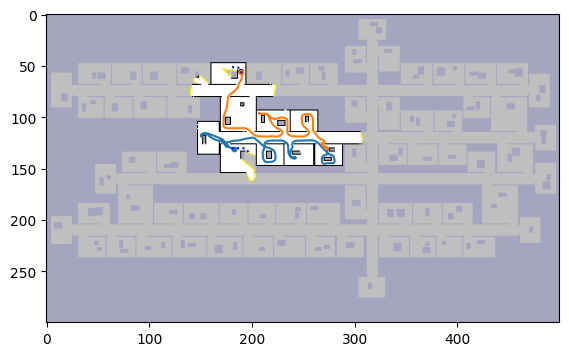

----------------------------------------
Counter: 192
Robot0: (197.56, 140.06)
Total motion: 347.40
Robot1: (179.43, 62.98)
Total motion: 347.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832df50b80>, <lsp.core.Frontier object at 0x7f832df509d0>, <lsp.core.Frontier object at 0x7f832df50970>, <lsp.core.Frontier object at 0x7f832df50a90>, <lsp.core.Frontier object at 0x7f832df50220>, <lsp.core.Frontier object at 0x7f832df50ac0>, <lsp.core.Frontier object at 0x7f832df50b20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df509d0>, <lsp.core.Frontier object at 0x7f832df50a90>]


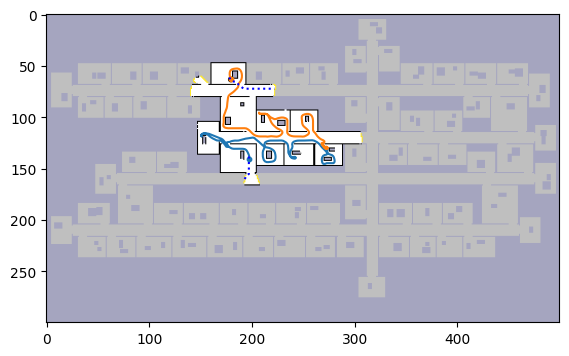

----------------------------------------
Counter: 204
Robot0: (202.52, 158.44)
Total motion: 369.00
Robot1: (197.62, 72.61)
Total motion: 369.00
Available frontiers: {<lsp.core.Frontier object at 0x7f831115d3a0>, <lsp.core.Frontier object at 0x7f83359a8760>, <lsp.core.Frontier object at 0x7f832df50790>, <lsp.core.Frontier object at 0x7f832df501f0>, <lsp.core.Frontier object at 0x7f831115d2b0>, <lsp.core.Frontier object at 0x7f832df50af0>, <lsp.core.Frontier object at 0x7f831115d190>, <lsp.core.Frontier object at 0x7f832df50e50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f831115d190>, <lsp.core.Frontier object at 0x7f832df50790>]


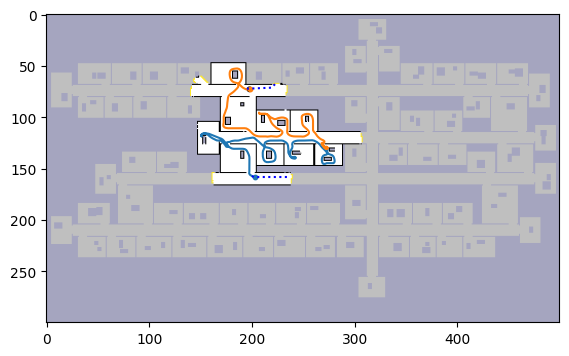

----------------------------------------
Counter: 216
Robot0: (224.03, 158.83)
Total motion: 390.60
Robot1: (219.02, 71.89)
Total motion: 390.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfd25b0>, <lsp.core.Frontier object at 0x7f832dfd23a0>, <lsp.core.Frontier object at 0x7f832dfd22e0>, <lsp.core.Frontier object at 0x7f832df50fa0>, <lsp.core.Frontier object at 0x7f832dfd2490>, <lsp.core.Frontier object at 0x7f832dfd2700>, <lsp.core.Frontier object at 0x7f832dfd24c0>, <lsp.core.Frontier object at 0x7f832dfd2a90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfd25b0>, <lsp.core.Frontier object at 0x7f832dfd23a0>]


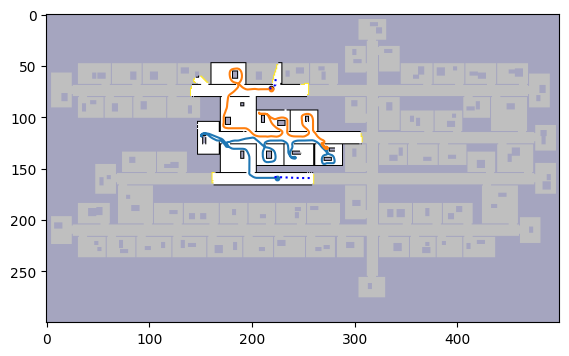

----------------------------------------
Counter: 228
Robot0: (245.63, 158.83)
Total motion: 412.20
Robot1: (212.20, 55.22)
Total motion: 412.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832e0f7b80>, <lsp.core.Frontier object at 0x7f832e0f70d0>, <lsp.core.Frontier object at 0x7f832e1f3940>, <lsp.core.Frontier object at 0x7f832df504f0>, <lsp.core.Frontier object at 0x7f832e0f7a30>, <lsp.core.Frontier object at 0x7f832e0f79a0>, <lsp.core.Frontier object at 0x7f832df501c0>, <lsp.core.Frontier object at 0x7f832e0f7100>, <lsp.core.Frontier object at 0x7f832e0f7070>, <lsp.core.Frontier object at 0x7f832e0f7190>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df504f0>, <lsp.core.Frontier object at 0x7f832e0f7070>]


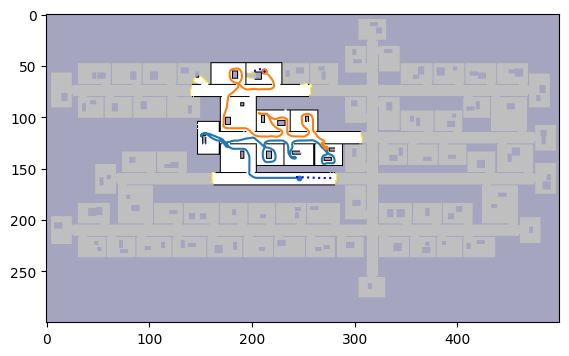

----------------------------------------
Counter: 240
Robot0: (267.23, 158.83)
Total motion: 433.80
Robot1: (211.67, 54.49)
Total motion: 433.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335780a30>, <lsp.core.Frontier object at 0x7f83357804f0>, <lsp.core.Frontier object at 0x7f8335780fa0>, <lsp.core.Frontier object at 0x7f83357800a0>, <lsp.core.Frontier object at 0x7f8335780730>, <lsp.core.Frontier object at 0x7f8335780580>, <lsp.core.Frontier object at 0x7f83357808e0>, <lsp.core.Frontier object at 0x7f8335780520>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83357804f0>, <lsp.core.Frontier object at 0x7f8335780a30>]


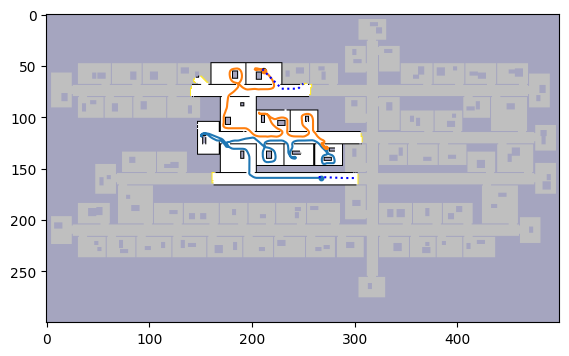

----------------------------------------
Counter: 252
Robot0: (288.83, 158.96)
Total motion: 455.40
Robot1: (226.38, 70.26)
Total motion: 455.40
Available frontiers: {<lsp.core.Frontier object at 0x7f83359b1760>, <lsp.core.Frontier object at 0x7f83359b1d00>, <lsp.core.Frontier object at 0x7f83359b11c0>, <lsp.core.Frontier object at 0x7f83359b18b0>, <lsp.core.Frontier object at 0x7f83359b1580>, <lsp.core.Frontier object at 0x7f83359b1040>, <lsp.core.Frontier object at 0x7f83359b14f0>, <lsp.core.Frontier object at 0x7f83359b1070>, <lsp.core.Frontier object at 0x7f83359b1c40>, <lsp.core.Frontier object at 0x7f83359b1490>, <lsp.core.Frontier object at 0x7f83359b1100>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83359b1580>, <lsp.core.Frontier object at 0x7f83359b1760>]


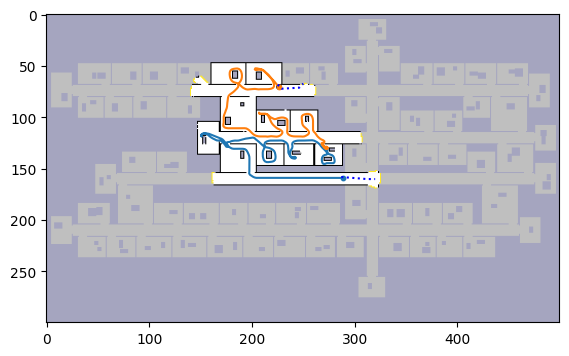

----------------------------------------
Counter: 264
Robot0: (310.35, 158.08)
Total motion: 477.00
Robot1: (247.12, 71.50)
Total motion: 477.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83358ecfd0>, <lsp.core.Frontier object at 0x7f83358ecd90>, <lsp.core.Frontier object at 0x7f83358ec880>, <lsp.core.Frontier object at 0x7f83358ecf70>, <lsp.core.Frontier object at 0x7f83358ecaf0>, <lsp.core.Frontier object at 0x7f83358ec8b0>, <lsp.core.Frontier object at 0x7f83358ec310>, <lsp.core.Frontier object at 0x7f83358ec850>, <lsp.core.Frontier object at 0x7f83358ec9a0>, <lsp.core.Frontier object at 0x7f83358ecbe0>, <lsp.core.Frontier object at 0x7f83358ec940>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358ecd90>, <lsp.core.Frontier object at 0x7f83358ec310>]


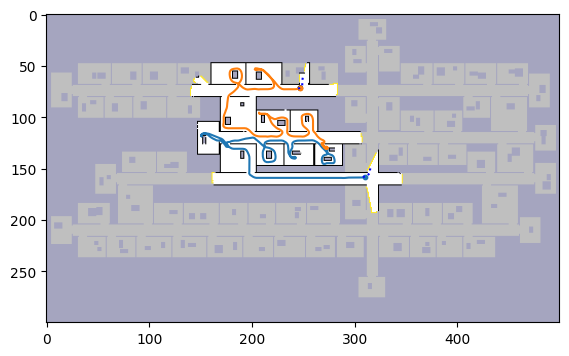

----------------------------------------
Counter: 276
Robot0: (302.94, 145.06)
Total motion: 498.60
Robot1: (253.14, 52.69)
Total motion: 498.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfd2190>, <lsp.core.Frontier object at 0x7f8335d8e220>, <lsp.core.Frontier object at 0x7f8335d8e3a0>, <lsp.core.Frontier object at 0x7f832e1f8790>, <lsp.core.Frontier object at 0x7f8335cd7fd0>, <lsp.core.Frontier object at 0x7f8335cd72e0>, <lsp.core.Frontier object at 0x7f8335cd7520>, <lsp.core.Frontier object at 0x7f8335cd7e20>, <lsp.core.Frontier object at 0x7f832e1f8520>, <lsp.core.Frontier object at 0x7f8335d8e700>, <lsp.core.Frontier object at 0x7f8335cd7eb0>, <lsp.core.Frontier object at 0x7f8335d8e610>, <lsp.core.Frontier object at 0x7f8335d8ee50>, <lsp.core.Frontier object at 0x7f8335cd7100>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d8e3a0>, <lsp.core.Frontier object at 0x7f8335cd7e20>]


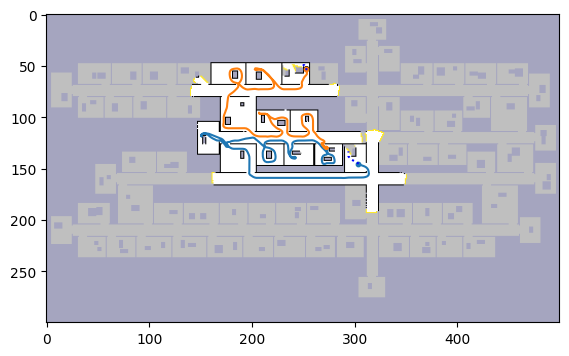

----------------------------------------
Counter: 288
Robot0: (293.69, 134.00)
Total motion: 520.20
Robot1: (241.40, 57.91)
Total motion: 520.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d45520>, <lsp.core.Frontier object at 0x7f8335d45400>, <lsp.core.Frontier object at 0x7f8335d8ff70>, <lsp.core.Frontier object at 0x7f8335d45ca0>, <lsp.core.Frontier object at 0x7f8335d8f3d0>, <lsp.core.Frontier object at 0x7f8335d45e80>, <lsp.core.Frontier object at 0x7f8335d45be0>, <lsp.core.Frontier object at 0x7f8335d45d60>, <lsp.core.Frontier object at 0x7f8335d457f0>, <lsp.core.Frontier object at 0x7f8335d45c40>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d8f3d0>, <lsp.core.Frontier object at 0x7f8335d45520>]


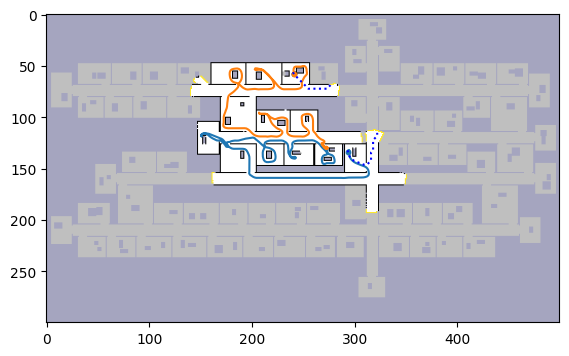

----------------------------------------
Counter: 300
Robot0: (309.62, 146.50)
Total motion: 541.80
Robot1: (256.85, 72.34)
Total motion: 541.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8338209b50>, <lsp.core.Frontier object at 0x7f8338209820>, <lsp.core.Frontier object at 0x7f8338209460>, <lsp.core.Frontier object at 0x7f8338209070>, <lsp.core.Frontier object at 0x7f8338209ca0>, <lsp.core.Frontier object at 0x7f83382090a0>, <lsp.core.Frontier object at 0x7f8338209e50>, <lsp.core.Frontier object at 0x7f8338209e20>, <lsp.core.Frontier object at 0x7f8338209a60>, <lsp.core.Frontier object at 0x7f83382091f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338209ca0>, <lsp.core.Frontier object at 0x7f8338209a60>]


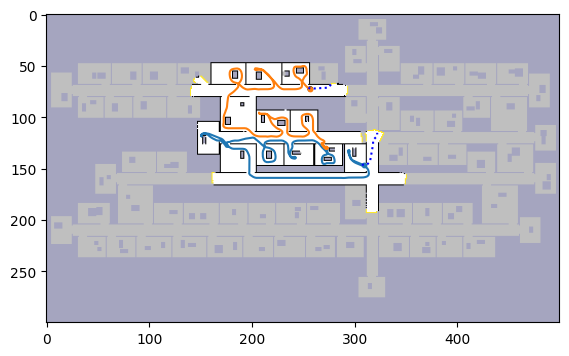

----------------------------------------
Counter: 312
Robot0: (315.39, 129.90)
Total motion: 563.40
Robot1: (276.76, 69.29)
Total motion: 563.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8338447fd0>, <lsp.core.Frontier object at 0x7f8338447f70>, <lsp.core.Frontier object at 0x7f8338447a30>, <lsp.core.Frontier object at 0x7f83384479d0>, <lsp.core.Frontier object at 0x7f83384477c0>, <lsp.core.Frontier object at 0x7f8338447760>, <lsp.core.Frontier object at 0x7f83384470d0>, <lsp.core.Frontier object at 0x7f8338447a90>, <lsp.core.Frontier object at 0x7f8338447520>, <lsp.core.Frontier object at 0x7f8338447be0>, <lsp.core.Frontier object at 0x7f8338447490>, <lsp.core.Frontier object at 0x7f83384472e0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338447a90>, <lsp.core.Frontier object at 0x7f8338447fd0>]


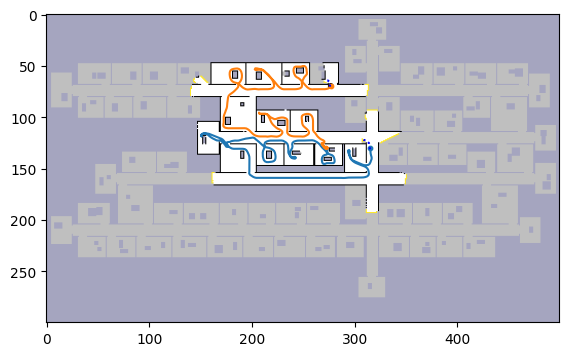

----------------------------------------
Counter: 324
Robot0: (329.42, 126.62)
Total motion: 585.00
Robot1: (262.54, 61.98)
Total motion: 585.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8338426ee0>, <lsp.core.Frontier object at 0x7f8338426d00>, <lsp.core.Frontier object at 0x7f83384261c0>, <lsp.core.Frontier object at 0x7f83384472b0>, <lsp.core.Frontier object at 0x7f83384269d0>, <lsp.core.Frontier object at 0x7f8338426c10>, <lsp.core.Frontier object at 0x7f8338447610>, <lsp.core.Frontier object at 0x7f8338447b20>, <lsp.core.Frontier object at 0x7f83384475b0>, <lsp.core.Frontier object at 0x7f8338447250>, <lsp.core.Frontier object at 0x7f8338447cd0>, <lsp.core.Frontier object at 0x7f83384265b0>, <lsp.core.Frontier object at 0x7f8338447730>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83384269d0>, <lsp.core.Frontier object at 0x7f8338447b20>]


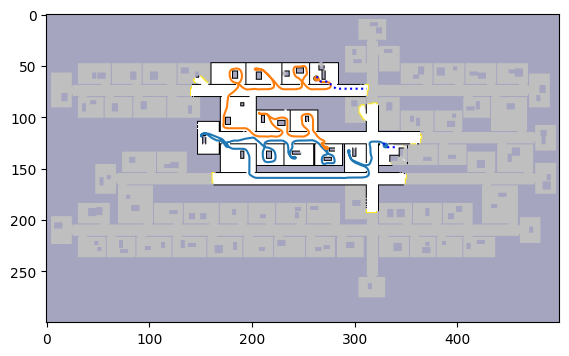

----------------------------------------
Counter: 336
Robot0: (334.14, 144.63)
Total motion: 606.60
Robot1: (280.65, 70.66)
Total motion: 606.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8337ffa3d0>, <lsp.core.Frontier object at 0x7f8338426040>, <lsp.core.Frontier object at 0x7f83384260a0>, <lsp.core.Frontier object at 0x7f8337ffa8b0>, <lsp.core.Frontier object at 0x7f8337ffa070>, <lsp.core.Frontier object at 0x7f832dfd2520>, <lsp.core.Frontier object at 0x7f8338426250>, <lsp.core.Frontier object at 0x7f83358d9700>, <lsp.core.Frontier object at 0x7f8338426e50>, <lsp.core.Frontier object at 0x7f83358d9190>, <lsp.core.Frontier object at 0x7f8337ffa6a0>, <lsp.core.Frontier object at 0x7f83384264c0>, <lsp.core.Frontier object at 0x7f83358d92e0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338426250>, <lsp.core.Frontier object at 0x7f83384264c0>]


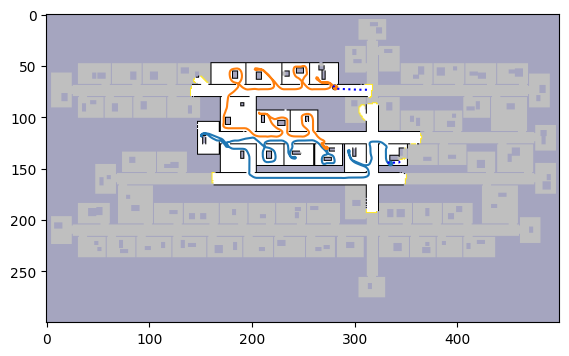

----------------------------------------
Counter: 348
Robot0: (348.54, 135.33)
Total motion: 628.20
Robot1: (301.59, 72.50)
Total motion: 628.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c663a0>, <lsp.core.Frontier object at 0x7f8335c667f0>, <lsp.core.Frontier object at 0x7f8335c66640>, <lsp.core.Frontier object at 0x7f8335c667c0>, <lsp.core.Frontier object at 0x7f8335c66880>, <lsp.core.Frontier object at 0x7f8335c66850>, <lsp.core.Frontier object at 0x7f8335c66460>, <lsp.core.Frontier object at 0x7f8335c668b0>, <lsp.core.Frontier object at 0x7f8335c66970>, <lsp.core.Frontier object at 0x7f8335c66760>, <lsp.core.Frontier object at 0x7f8335c66820>, <lsp.core.Frontier object at 0x7f8335c66550>, <lsp.core.Frontier object at 0x7f8335c66e20>, <lsp.core.Frontier object at 0x7f8335c66940>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335c663a0>, <lsp.core.Frontier object at 0x7f8335c66850>]


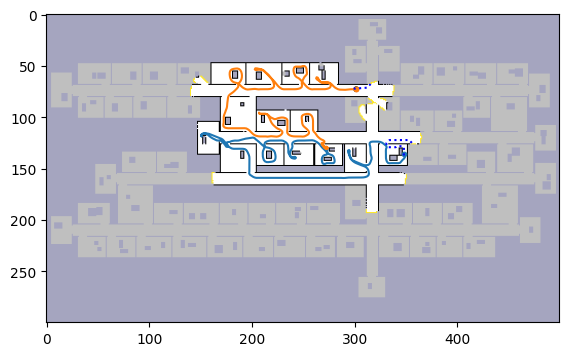

----------------------------------------
Counter: 360
Robot0: (334.99, 129.70)
Total motion: 649.80
Robot1: (319.01, 80.19)
Total motion: 649.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8311293af0>, <lsp.core.Frontier object at 0x7f8311293280>, <lsp.core.Frontier object at 0x7f8311293340>, <lsp.core.Frontier object at 0x7f83112930d0>, <lsp.core.Frontier object at 0x7f8311293190>, <lsp.core.Frontier object at 0x7f83381617c0>, <lsp.core.Frontier object at 0x7f83112931c0>, <lsp.core.Frontier object at 0x7f8335c665b0>, <lsp.core.Frontier object at 0x7f8335c1f9d0>, <lsp.core.Frontier object at 0x7f83112932b0>, <lsp.core.Frontier object at 0x7f8335c66bb0>, <lsp.core.Frontier object at 0x7f83112938e0>, <lsp.core.Frontier object at 0x7f8311293160>, <lsp.core.Frontier object at 0x7f8335c66a00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8311293af0>, <lsp.core.Frontier object at 0x7f8311293280>]


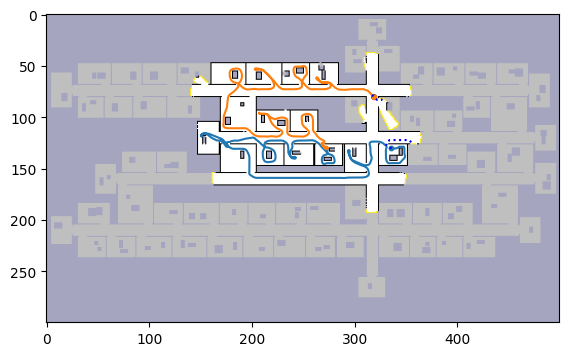

----------------------------------------
Counter: 372
Robot0: (344.54, 122.49)
Total motion: 671.40
Robot1: (338.91, 84.50)
Total motion: 671.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335bf7130>, <lsp.core.Frontier object at 0x7f8311293370>, <lsp.core.Frontier object at 0x7f8335bf7af0>, <lsp.core.Frontier object at 0x7f8311293d30>, <lsp.core.Frontier object at 0x7f83112931f0>, <lsp.core.Frontier object at 0x7f8335bf7820>, <lsp.core.Frontier object at 0x7f8335bf7a60>, <lsp.core.Frontier object at 0x7f8311293c40>, <lsp.core.Frontier object at 0x7f8311293ac0>, <lsp.core.Frontier object at 0x7f8335bf7ca0>, <lsp.core.Frontier object at 0x7f8311293cd0>, <lsp.core.Frontier object at 0x7f8311293c10>, <lsp.core.Frontier object at 0x7f8311293b50>, <lsp.core.Frontier object at 0x7f8311293310>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335bf7ca0>, <lsp.core.Frontier object at 0x7f83112931f0>]


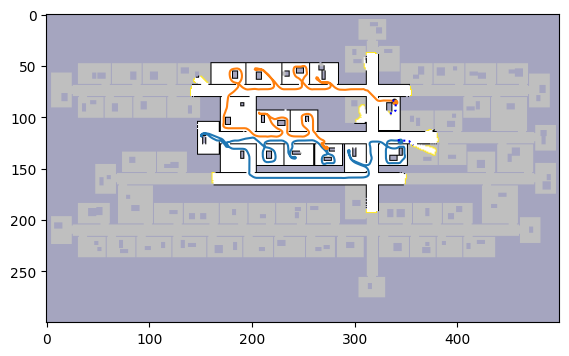

----------------------------------------
Counter: 384
Robot0: (360.26, 133.54)
Total motion: 693.00
Robot1: (329.67, 94.91)
Total motion: 693.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83357e0be0>, <lsp.core.Frontier object at 0x7f83357e0d60>, <lsp.core.Frontier object at 0x7f83357e0a30>, <lsp.core.Frontier object at 0x7f83357e0b50>, <lsp.core.Frontier object at 0x7f83357e0940>, <lsp.core.Frontier object at 0x7f83357e0880>, <lsp.core.Frontier object at 0x7f83357e0d90>, <lsp.core.Frontier object at 0x7f83357e0ca0>, <lsp.core.Frontier object at 0x7f83357e0ac0>, <lsp.core.Frontier object at 0x7f83357e0850>, <lsp.core.Frontier object at 0x7f83359b97c0>, <lsp.core.Frontier object at 0x7f83357e0a90>, <lsp.core.Frontier object at 0x7f83357e09a0>, <lsp.core.Frontier object at 0x7f83357e0c10>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83357e0be0>, <lsp.core.Frontier object at 0x7f83357e0b50>]


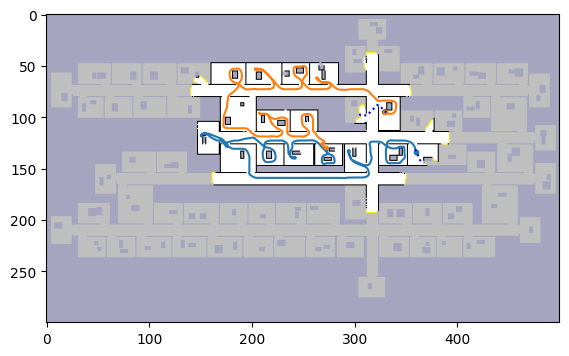

----------------------------------------
Counter: 396
Robot0: (373.85, 145.40)
Total motion: 714.60
Robot1: (315.11, 96.09)
Total motion: 714.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83359a7790>, <lsp.core.Frontier object at 0x7f8335cbed90>, <lsp.core.Frontier object at 0x7f8335b7fcd0>, <lsp.core.Frontier object at 0x7f83359a7eb0>, <lsp.core.Frontier object at 0x7f832e086a60>, <lsp.core.Frontier object at 0x7f83359a7f10>, <lsp.core.Frontier object at 0x7f8335b7f550>, <lsp.core.Frontier object at 0x7f8335b7fd00>, <lsp.core.Frontier object at 0x7f831129b730>, <lsp.core.Frontier object at 0x7f8335b7fa90>, <lsp.core.Frontier object at 0x7f83381b38e0>, <lsp.core.Frontier object at 0x7f832e0864f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83381b38e0>, <lsp.core.Frontier object at 0x7f8335b7fcd0>]


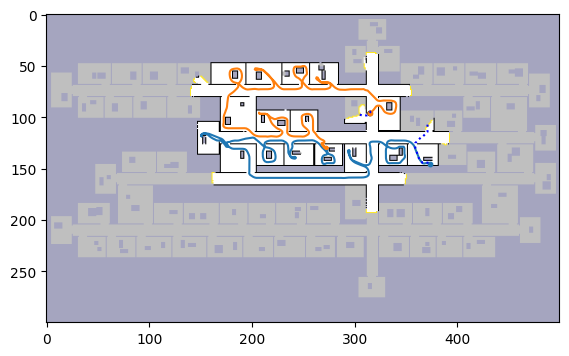

----------------------------------------
Counter: 408
Robot0: (360.76, 134.83)
Total motion: 738.00
Robot1: (296.08, 92.25)
Total motion: 738.00
Available frontiers: {<lsp.core.Frontier object at 0x7f833597bb80>, <lsp.core.Frontier object at 0x7f833597bac0>, <lsp.core.Frontier object at 0x7f833597b850>, <lsp.core.Frontier object at 0x7f832df5cac0>, <lsp.core.Frontier object at 0x7f833597ba60>, <lsp.core.Frontier object at 0x7f833597bca0>, <lsp.core.Frontier object at 0x7f833597b0a0>, <lsp.core.Frontier object at 0x7f833597b100>, <lsp.core.Frontier object at 0x7f833597b9d0>, <lsp.core.Frontier object at 0x7f833597bf70>, <lsp.core.Frontier object at 0x7f833597bc40>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833597bf70>, <lsp.core.Frontier object at 0x7f833597b0a0>]


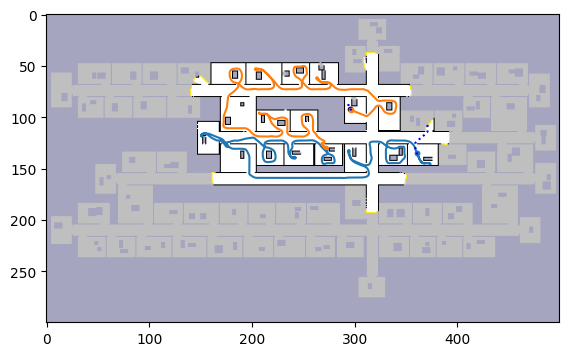

----------------------------------------
Counter: 420
Robot0: (368.43, 117.81)
Total motion: 759.60
Robot1: (311.65, 98.51)
Total motion: 759.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83359e06d0>, <lsp.core.Frontier object at 0x7f8335c9bee0>, <lsp.core.Frontier object at 0x7f83359e0280>, <lsp.core.Frontier object at 0x7f83359e0370>, <lsp.core.Frontier object at 0x7f8335c9bbb0>, <lsp.core.Frontier object at 0x7f83359e0400>, <lsp.core.Frontier object at 0x7f83359786a0>, <lsp.core.Frontier object at 0x7f8335c9b850>, <lsp.core.Frontier object at 0x7f8335c9bf10>, <lsp.core.Frontier object at 0x7f8335c9b9d0>, <lsp.core.Frontier object at 0x7f8335c9bdf0>, <lsp.core.Frontier object at 0x7f8335c9bcd0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83359e0370>, <lsp.core.Frontier object at 0x7f8335c9b9d0>]


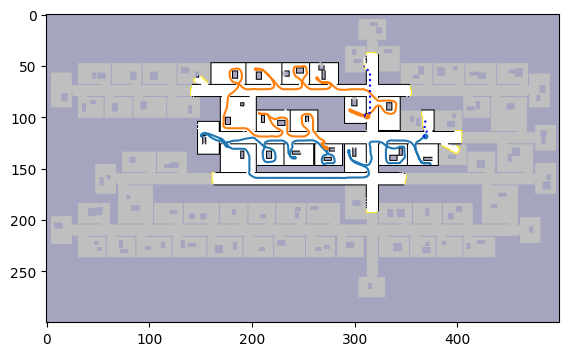

----------------------------------------
Counter: 432
Robot0: (364.03, 98.32)
Total motion: 781.20
Robot1: (315.57, 79.23)
Total motion: 781.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335afec70>, <lsp.core.Frontier object at 0x7f8335afee50>, <lsp.core.Frontier object at 0x7f8335afec10>, <lsp.core.Frontier object at 0x7f83359e0760>, <lsp.core.Frontier object at 0x7f8335afe7c0>, <lsp.core.Frontier object at 0x7f8335afe970>, <lsp.core.Frontier object at 0x7f8335afedf0>, <lsp.core.Frontier object at 0x7f83359e0fa0>, <lsp.core.Frontier object at 0x7f8335afe4c0>, <lsp.core.Frontier object at 0x7f8335afefa0>, <lsp.core.Frontier object at 0x7f83359e05e0>, <lsp.core.Frontier object at 0x7f83359e0460>, <lsp.core.Frontier object at 0x7f8335afe070>, <lsp.core.Frontier object at 0x7f8335afe460>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335afee50>, <lsp.core.Frontier object at 0x7f8335afefa0>]


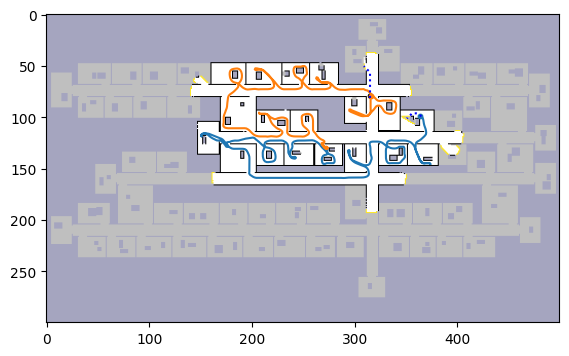

----------------------------------------
Counter: 444
Robot0: (359.75, 97.31)
Total motion: 802.80
Robot1: (314.99, 57.84)
Total motion: 802.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8337f83b20>, <lsp.core.Frontier object at 0x7f8337f83d60>, <lsp.core.Frontier object at 0x7f8337f83af0>, <lsp.core.Frontier object at 0x7f8338060280>, <lsp.core.Frontier object at 0x7f8337f83550>, <lsp.core.Frontier object at 0x7f8337ffaf10>, <lsp.core.Frontier object at 0x7f8337ffa520>, <lsp.core.Frontier object at 0x7f8337f83400>, <lsp.core.Frontier object at 0x7f8337f83e50>, <lsp.core.Frontier object at 0x7f8337fd1eb0>, <lsp.core.Frontier object at 0x7f8337ffa070>, <lsp.core.Frontier object at 0x7f8337f831f0>, <lsp.core.Frontier object at 0x7f8337ffaa90>, <lsp.core.Frontier object at 0x7f8337f835b0>, <lsp.core.Frontier object at 0x7f8337f83790>, <lsp.core.Frontier object at 0x7f8337f83040>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337ffa070>, <lsp.core.Frontier object a

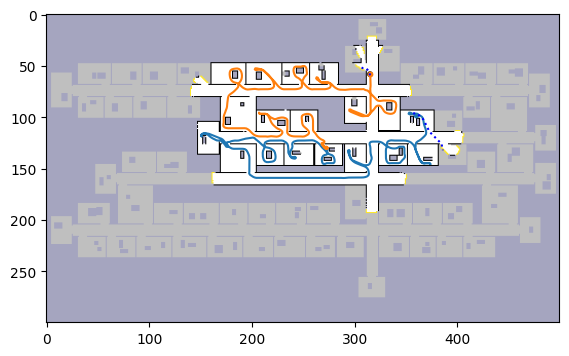

----------------------------------------
Counter: 456
Robot0: (372.33, 113.62)
Total motion: 824.40
Robot1: (305.23, 41.78)
Total motion: 824.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335997220>, <lsp.core.Frontier object at 0x7f8338199970>, <lsp.core.Frontier object at 0x7f8338010fa0>, <lsp.core.Frontier object at 0x7f83357f5910>, <lsp.core.Frontier object at 0x7f8337fd10d0>, <lsp.core.Frontier object at 0x7f83381995b0>, <lsp.core.Frontier object at 0x7f83359971f0>, <lsp.core.Frontier object at 0x7f83380106d0>, <lsp.core.Frontier object at 0x7f8338199b80>, <lsp.core.Frontier object at 0x7f8335997400>, <lsp.core.Frontier object at 0x7f8335997640>, <lsp.core.Frontier object at 0x7f8338199cd0>, <lsp.core.Frontier object at 0x7f8335997250>, <lsp.core.Frontier object at 0x7f8338199430>, <lsp.core.Frontier object at 0x7f83359975b0>, <lsp.core.Frontier object at 0x7f8335997a90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83381995b0>, <lsp.core.Frontier object 

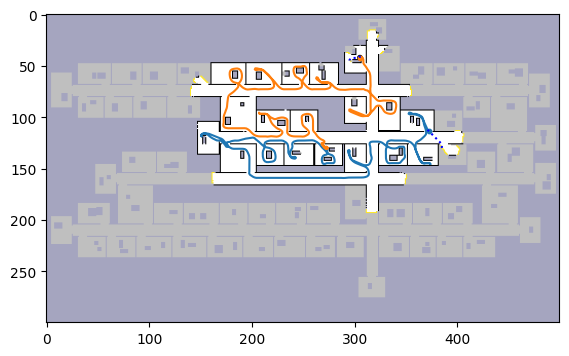

----------------------------------------
Counter: 468
Robot0: (387.51, 128.37)
Total motion: 846.00
Robot1: (300.40, 50.53)
Total motion: 846.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8338173610>, <lsp.core.Frontier object at 0x7f83359e08e0>, <lsp.core.Frontier object at 0x7f8338173a00>, <lsp.core.Frontier object at 0x7f8338173e20>, <lsp.core.Frontier object at 0x7f83359e0b50>, <lsp.core.Frontier object at 0x7f8338173af0>, <lsp.core.Frontier object at 0x7f83359838b0>, <lsp.core.Frontier object at 0x7f83359e0130>, <lsp.core.Frontier object at 0x7f83359e0700>, <lsp.core.Frontier object at 0x7f83381735b0>, <lsp.core.Frontier object at 0x7f83383c3190>, <lsp.core.Frontier object at 0x7f8338173670>, <lsp.core.Frontier object at 0x7f8338173280>, <lsp.core.Frontier object at 0x7f83383c3250>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338173e20>, <lsp.core.Frontier object at 0x7f8338173280>]


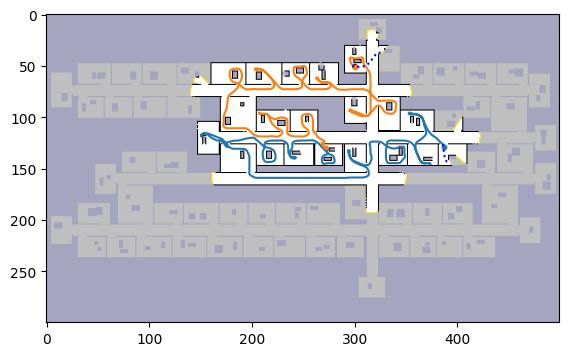

----------------------------------------
Counter: 480
Robot0: (396.26, 143.51)
Total motion: 867.60
Robot1: (317.54, 42.36)
Total motion: 867.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83386af5e0>, <lsp.core.Frontier object at 0x7f83386af100>, <lsp.core.Frontier object at 0x7f83386afc40>, <lsp.core.Frontier object at 0x7f83386af940>, <lsp.core.Frontier object at 0x7f83386af580>, <lsp.core.Frontier object at 0x7f83386af130>, <lsp.core.Frontier object at 0x7f83386af3a0>, <lsp.core.Frontier object at 0x7f83386af5b0>, <lsp.core.Frontier object at 0x7f83386af9d0>, <lsp.core.Frontier object at 0x7f83386af910>, <lsp.core.Frontier object at 0x7f83386afeb0>, <lsp.core.Frontier object at 0x7f83386afdc0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83386af5b0>, <lsp.core.Frontier object at 0x7f83386af580>]


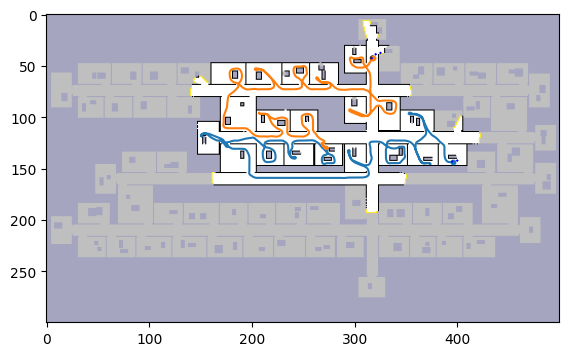

----------------------------------------
Counter: 492
Robot0: (387.90, 133.18)
Total motion: 891.00
Robot1: (336.51, 40.60)
Total motion: 891.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83384a7880>, <lsp.core.Frontier object at 0x7f83384a7520>, <lsp.core.Frontier object at 0x7f83384a7d30>, <lsp.core.Frontier object at 0x7f8338528460>, <lsp.core.Frontier object at 0x7f8338528e20>, <lsp.core.Frontier object at 0x7f83384a7820>, <lsp.core.Frontier object at 0x7f8338060ac0>, <lsp.core.Frontier object at 0x7f8337f83220>, <lsp.core.Frontier object at 0x7f83384a75e0>, <lsp.core.Frontier object at 0x7f8338528940>, <lsp.core.Frontier object at 0x7f83359ccbe0>, <lsp.core.Frontier object at 0x7f83384a7a30>, <lsp.core.Frontier object at 0x7f8338381e20>, <lsp.core.Frontier object at 0x7f83359cc910>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338528940>, <lsp.core.Frontier object at 0x7f8338381e20>]


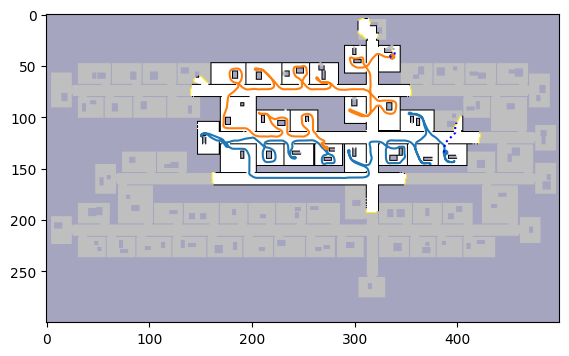

----------------------------------------
Counter: 504
Robot0: (398.00, 115.26)
Total motion: 912.60
Robot1: (325.08, 37.05)
Total motion: 912.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8338018280>, <lsp.core.Frontier object at 0x7f8335dcf6a0>, <lsp.core.Frontier object at 0x7f8338199c70>, <lsp.core.Frontier object at 0x7f8335dcf280>, <lsp.core.Frontier object at 0x7f83381995e0>, <lsp.core.Frontier object at 0x7f83359ff670>, <lsp.core.Frontier object at 0x7f833851aac0>, <lsp.core.Frontier object at 0x7f8338018400>, <lsp.core.Frontier object at 0x7f8335dcf700>, <lsp.core.Frontier object at 0x7f8338018100>, <lsp.core.Frontier object at 0x7f8335dcf0a0>, <lsp.core.Frontier object at 0x7f8335dcfbb0>, <lsp.core.Frontier object at 0x7f83384b1430>, <lsp.core.Frontier object at 0x7f83381999d0>, <lsp.core.Frontier object at 0x7f83384b1b20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335dcfbb0>, <lsp.core.Frontier object at 0x7f83381995e0>]


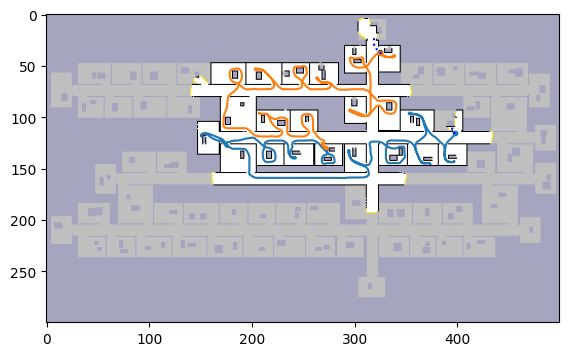

----------------------------------------
Counter: 516
Robot0: (393.30, 111.53)
Total motion: 934.20
Robot1: (320.50, 22.10)
Total motion: 934.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83358db130>, <lsp.core.Frontier object at 0x7f8335ce0fd0>, <lsp.core.Frontier object at 0x7f8335ce0e50>, <lsp.core.Frontier object at 0x7f8335ce09a0>, <lsp.core.Frontier object at 0x7f83358dbe50>, <lsp.core.Frontier object at 0x7f83358db280>, <lsp.core.Frontier object at 0x7f83358db220>, <lsp.core.Frontier object at 0x7f83358db0a0>, <lsp.core.Frontier object at 0x7f833821d4c0>, <lsp.core.Frontier object at 0x7f8335ce0df0>, <lsp.core.Frontier object at 0x7f83358db850>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335ce0df0>, <lsp.core.Frontier object at 0x7f833821d4c0>]


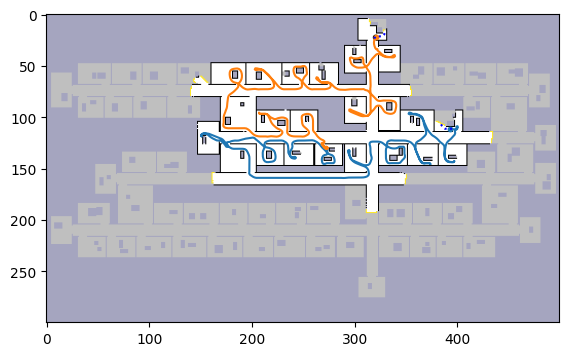

----------------------------------------
Counter: 528
Robot0: (387.17, 108.39)
Total motion: 955.80
Robot1: (328.52, 12.85)
Total motion: 955.80
Available frontiers: {<lsp.core.Frontier object at 0x7f83357c1520>, <lsp.core.Frontier object at 0x7f83357c16d0>, <lsp.core.Frontier object at 0x7f83357c19d0>, <lsp.core.Frontier object at 0x7f83357c1460>, <lsp.core.Frontier object at 0x7f83357c1e80>, <lsp.core.Frontier object at 0x7f83357c17f0>, <lsp.core.Frontier object at 0x7f83357c1070>, <lsp.core.Frontier object at 0x7f83357c15b0>, <lsp.core.Frontier object at 0x7f83357c1100>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83357c1460>, <lsp.core.Frontier object at 0x7f83357c15b0>]


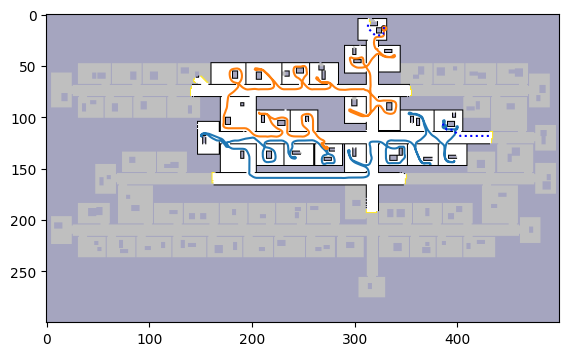

----------------------------------------
Counter: 540
Robot0: (404.09, 118.10)
Total motion: 977.40
Robot1: (317.04, 16.52)
Total motion: 977.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335990f70>, <lsp.core.Frontier object at 0x7f8335a3e3a0>, <lsp.core.Frontier object at 0x7f8335a3ee80>, <lsp.core.Frontier object at 0x7f8335868580>, <lsp.core.Frontier object at 0x7f8335cb7940>, <lsp.core.Frontier object at 0x7f8335a3e8e0>, <lsp.core.Frontier object at 0x7f8335cb7970>, <lsp.core.Frontier object at 0x7f8335a3ee50>, <lsp.core.Frontier object at 0x7f8335cb7f40>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a3e8e0>, <lsp.core.Frontier object at 0x7f8335a3ee50>]


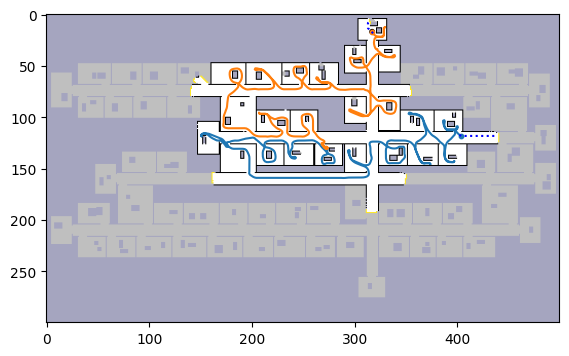

----------------------------------------
Counter: 552
Robot0: (425.42, 120.77)
Total motion: 999.00
Robot1: (317.15, 28.93)
Total motion: 999.00
Available frontiers: {<lsp.core.Frontier object at 0x7f832e126310>, <lsp.core.Frontier object at 0x7f832e126730>, <lsp.core.Frontier object at 0x7f832e126880>, <lsp.core.Frontier object at 0x7f832e126190>, <lsp.core.Frontier object at 0x7f832e126250>, <lsp.core.Frontier object at 0x7f832e1266d0>, <lsp.core.Frontier object at 0x7f832e126340>, <lsp.core.Frontier object at 0x7f832e126c10>, <lsp.core.Frontier object at 0x7f832e1261c0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e126190>, <lsp.core.Frontier object at 0x7f832e126730>]


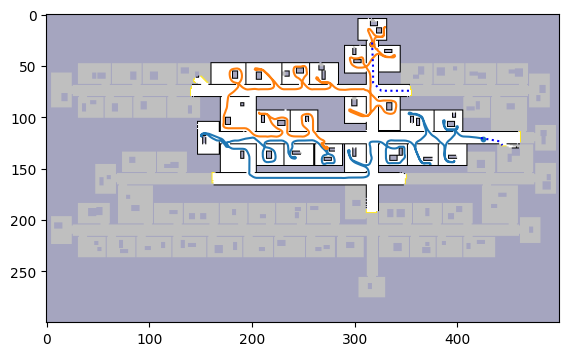

----------------------------------------
Counter: 564
Robot0: (445.55, 126.72)
Total motion: 1020.60
Robot1: (318.08, 50.49)
Total motion: 1020.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832e009490>, <lsp.core.Frontier object at 0x7f832e009d30>, <lsp.core.Frontier object at 0x7f832e009b20>, <lsp.core.Frontier object at 0x7f832e009d90>, <lsp.core.Frontier object at 0x7f832e009e80>, <lsp.core.Frontier object at 0x7f832e009700>, <lsp.core.Frontier object at 0x7f832e009a00>, <lsp.core.Frontier object at 0x7f832e009310>, <lsp.core.Frontier object at 0x7f832e0096a0>, <lsp.core.Frontier object at 0x7f832e009dc0>, <lsp.core.Frontier object at 0x7f832e009910>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e009490>, <lsp.core.Frontier object at 0x7f832e009b20>]


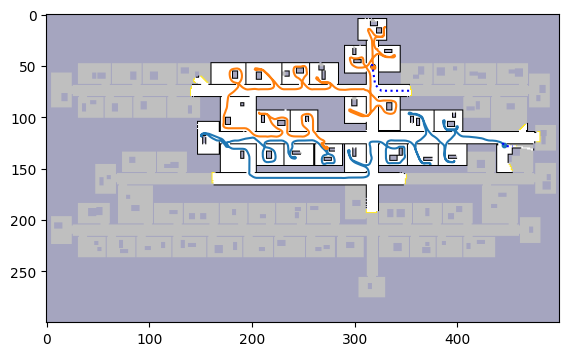

----------------------------------------
Counter: 576
Robot0: (448.90, 146.33)
Total motion: 1042.20
Robot1: (322.88, 70.74)
Total motion: 1042.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832e150790>, <lsp.core.Frontier object at 0x7f832df50940>, <lsp.core.Frontier object at 0x7f83112cc880>, <lsp.core.Frontier object at 0x7f832e1508b0>, <lsp.core.Frontier object at 0x7f83112cceb0>, <lsp.core.Frontier object at 0x7f83112ccb20>, <lsp.core.Frontier object at 0x7f832e150580>, <lsp.core.Frontier object at 0x7f83112cc850>, <lsp.core.Frontier object at 0x7f83112cc8b0>, <lsp.core.Frontier object at 0x7f832df50a30>, <lsp.core.Frontier object at 0x7f832df50700>, <lsp.core.Frontier object at 0x7f83112ccfd0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e150790>, <lsp.core.Frontier object at 0x7f832e150580>]


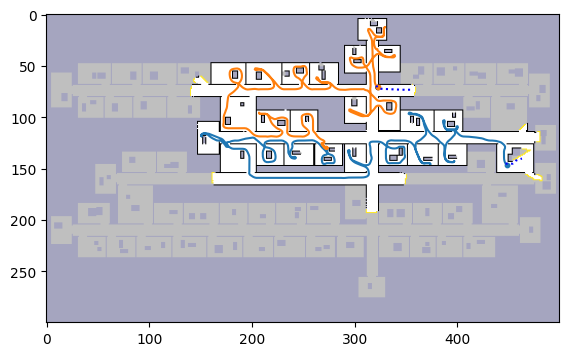

----------------------------------------
Counter: 588
Robot0: (465.14, 145.49)
Total motion: 1063.80
Robot1: (343.97, 72.56)
Total motion: 1063.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e1d14f0>, <lsp.core.Frontier object at 0x7f832e1d1730>, <lsp.core.Frontier object at 0x7f832e1d1f70>, <lsp.core.Frontier object at 0x7f832e1d13d0>, <lsp.core.Frontier object at 0x7f832e1d1340>, <lsp.core.Frontier object at 0x7f832e1d1eb0>, <lsp.core.Frontier object at 0x7f832e1d1490>, <lsp.core.Frontier object at 0x7f832e1d1f10>, <lsp.core.Frontier object at 0x7f832e1d1400>, <lsp.core.Frontier object at 0x7f832e1d1dc0>, <lsp.core.Frontier object at 0x7f832e1d1ee0>, <lsp.core.Frontier object at 0x7f832e1d1640>, <lsp.core.Frontier object at 0x7f832e1d12e0>, <lsp.core.Frontier object at 0x7f832e1d1d60>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1d1340>, <lsp.core.Frontier object at 0x7f832e1d1490>]


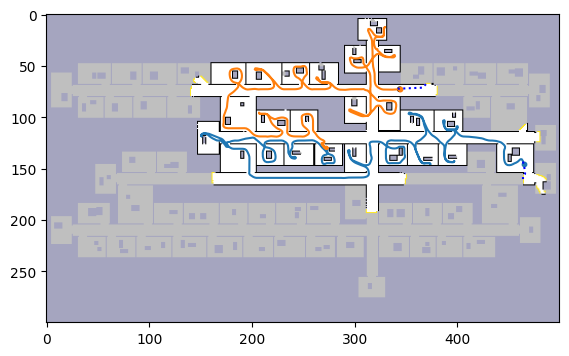

----------------------------------------
Counter: 600
Robot0: (476.80, 158.37)
Total motion: 1085.40
Robot1: (365.43, 72.11)
Total motion: 1085.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832e1d1b80>, <lsp.core.Frontier object at 0x7f8335b76910>, <lsp.core.Frontier object at 0x7f832e1d1460>, <lsp.core.Frontier object at 0x7f832e1d1850>, <lsp.core.Frontier object at 0x7f832e1d1a30>, <lsp.core.Frontier object at 0x7f8335b76430>, <lsp.core.Frontier object at 0x7f832e1d18b0>, <lsp.core.Frontier object at 0x7f832e1d1760>, <lsp.core.Frontier object at 0x7f832e1d17c0>, <lsp.core.Frontier object at 0x7f832e1d1970>, <lsp.core.Frontier object at 0x7f832e1d1370>, <lsp.core.Frontier object at 0x7f832e1d1b20>, <lsp.core.Frontier object at 0x7f832e1d18e0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335b76430>, <lsp.core.Frontier object at 0x7f832e1d17c0>]


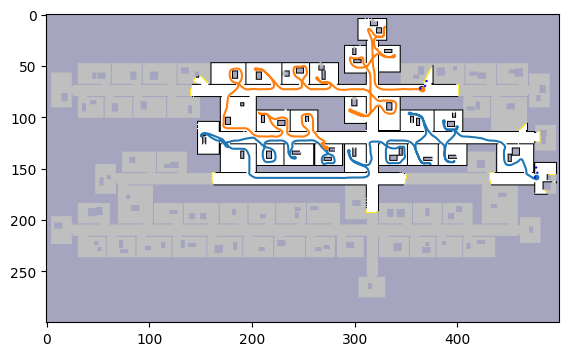

----------------------------------------
Counter: 612
Robot0: (493.52, 158.71)
Total motion: 1107.00
Robot1: (355.55, 64.50)
Total motion: 1107.00
Available frontiers: {<lsp.core.Frontier object at 0x7f831115f670>, <lsp.core.Frontier object at 0x7f831115fe80>, <lsp.core.Frontier object at 0x7f83112272b0>, <lsp.core.Frontier object at 0x7f831115f280>, <lsp.core.Frontier object at 0x7f8311152e80>, <lsp.core.Frontier object at 0x7f831115f520>, <lsp.core.Frontier object at 0x7f8335921370>, <lsp.core.Frontier object at 0x7f831115f3a0>, <lsp.core.Frontier object at 0x7f8335921c10>, <lsp.core.Frontier object at 0x7f831115f8e0>, <lsp.core.Frontier object at 0x7f831115fac0>, <lsp.core.Frontier object at 0x7f83359210d0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f831115fe80>, <lsp.core.Frontier object at 0x7f831115f520>]


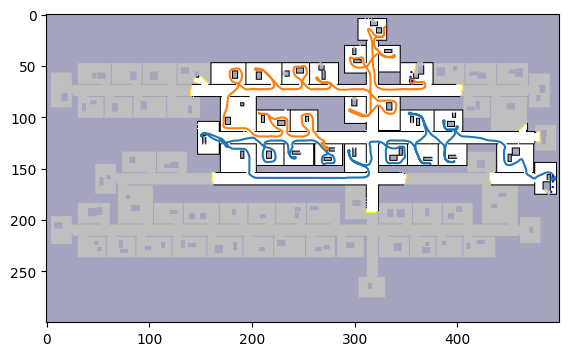

----------------------------------------
Counter: 624
Robot0: (485.30, 172.51)
Total motion: 1128.60
Robot1: (358.60, 65.48)
Total motion: 1128.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8311234c70>, <lsp.core.Frontier object at 0x7f832e13a760>, <lsp.core.Frontier object at 0x7f832e13a730>, <lsp.core.Frontier object at 0x7f8335a6c370>, <lsp.core.Frontier object at 0x7f832e13a130>, <lsp.core.Frontier object at 0x7f8311234a90>, <lsp.core.Frontier object at 0x7f8335ab3a90>, <lsp.core.Frontier object at 0x7f8311234670>, <lsp.core.Frontier object at 0x7f8311234040>, <lsp.core.Frontier object at 0x7f8335a6c5b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8311234c70>, <lsp.core.Frontier object at 0x7f8311234a90>]


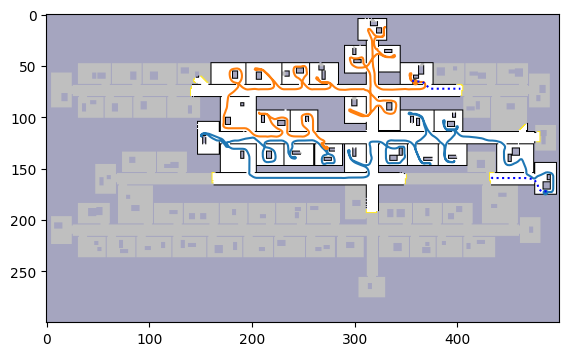

----------------------------------------
Counter: 636
Robot0: (470.66, 160.15)
Total motion: 1150.20
Robot1: (377.92, 72.70)
Total motion: 1150.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832df98be0>, <lsp.core.Frontier object at 0x7f832df986a0>, <lsp.core.Frontier object at 0x7f832df98040>, <lsp.core.Frontier object at 0x7f832df98f40>, <lsp.core.Frontier object at 0x7f8335a8a160>, <lsp.core.Frontier object at 0x7f832df98d60>, <lsp.core.Frontier object at 0x7f832df98100>, <lsp.core.Frontier object at 0x7f832e126c40>, <lsp.core.Frontier object at 0x7f832df98ac0>, <lsp.core.Frontier object at 0x7f832df98c40>, <lsp.core.Frontier object at 0x7f832e1260d0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df98100>, <lsp.core.Frontier object at 0x7f832df98f40>]


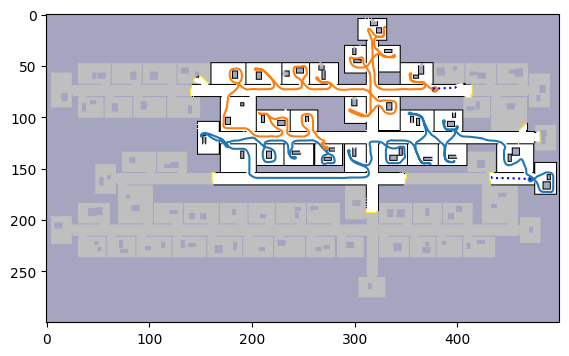

----------------------------------------
Counter: 648
Robot0: (449.13, 158.52)
Total motion: 1171.80
Robot1: (399.03, 70.82)
Total motion: 1171.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e0f7670>, <lsp.core.Frontier object at 0x7f832e0f72e0>, <lsp.core.Frontier object at 0x7f832e0f7d00>, <lsp.core.Frontier object at 0x7f832df98760>, <lsp.core.Frontier object at 0x7f832df98a00>, <lsp.core.Frontier object at 0x7f832e0f7460>, <lsp.core.Frontier object at 0x7f832e0f7e50>, <lsp.core.Frontier object at 0x7f832e0885e0>, <lsp.core.Frontier object at 0x7f832e0f75e0>, <lsp.core.Frontier object at 0x7f832e0884f0>, <lsp.core.Frontier object at 0x7f832e088820>, <lsp.core.Frontier object at 0x7f832e088a90>, <lsp.core.Frontier object at 0x7f832df98dc0>, <lsp.core.Frontier object at 0x7f832e0f78e0>, <lsp.core.Frontier object at 0x7f832e088b50>, <lsp.core.Frontier object at 0x7f832df98670>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e088a90>, <lsp.core.Frontier objec

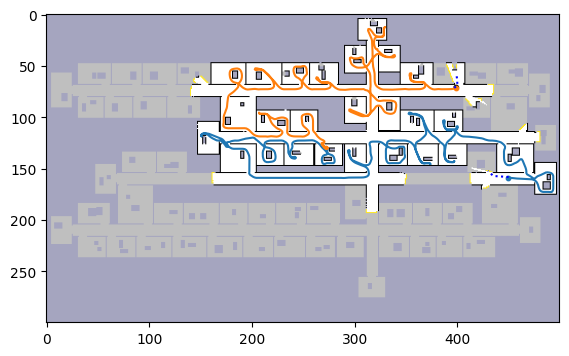

----------------------------------------
Counter: 660
Robot0: (429.32, 152.57)
Total motion: 1193.40
Robot1: (398.27, 56.89)
Total motion: 1193.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832dffc1f0>, <lsp.core.Frontier object at 0x7f8335775eb0>, <lsp.core.Frontier object at 0x7f832dffc220>, <lsp.core.Frontier object at 0x7f832dffc3d0>, <lsp.core.Frontier object at 0x7f8335775e80>, <lsp.core.Frontier object at 0x7f832dffcbb0>, <lsp.core.Frontier object at 0x7f83358042e0>, <lsp.core.Frontier object at 0x7f83357753a0>, <lsp.core.Frontier object at 0x7f8335804880>, <lsp.core.Frontier object at 0x7f832dffc460>, <lsp.core.Frontier object at 0x7f832dffcfd0>, <lsp.core.Frontier object at 0x7f8335775310>, <lsp.core.Frontier object at 0x7f8335804280>, <lsp.core.Frontier object at 0x7f8335804100>, <lsp.core.Frontier object at 0x7f832dffcf40>, <lsp.core.Frontier object at 0x7f832dffcd00>, <lsp.core.Frontier object at 0x7f832dffc310>, <lsp.core.Frontier object at 0x7f8335775970>}
Rob

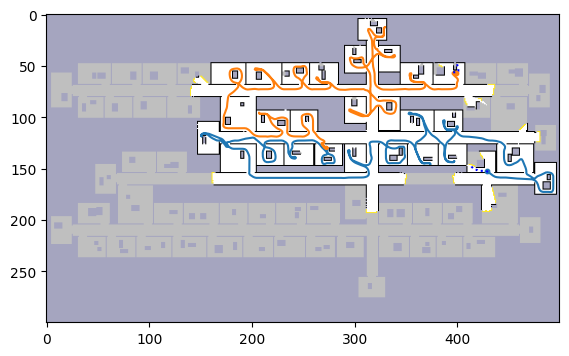

----------------------------------------
Counter: 672
Robot0: (416.52, 142.51)
Total motion: 1215.00
Robot1: (391.08, 51.82)
Total motion: 1215.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335cb7790>, <lsp.core.Frontier object at 0x7f8335cb7880>, <lsp.core.Frontier object at 0x7f8335cb4490>, <lsp.core.Frontier object at 0x7f8335775940>, <lsp.core.Frontier object at 0x7f8335cb4e20>, <lsp.core.Frontier object at 0x7f8335cb7be0>, <lsp.core.Frontier object at 0x7f8335cb4970>, <lsp.core.Frontier object at 0x7f833578b760>, <lsp.core.Frontier object at 0x7f8335cb48e0>, <lsp.core.Frontier object at 0x7f8335cb4400>, <lsp.core.Frontier object at 0x7f83357750a0>, <lsp.core.Frontier object at 0x7f8335cb73a0>, <lsp.core.Frontier object at 0x7f8335cb7130>, <lsp.core.Frontier object at 0x7f8335cb4760>, <lsp.core.Frontier object at 0x7f832e126c40>, <lsp.core.Frontier object at 0x7f8335cb7d60>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335cb4490>, <lsp.core.Frontier objec

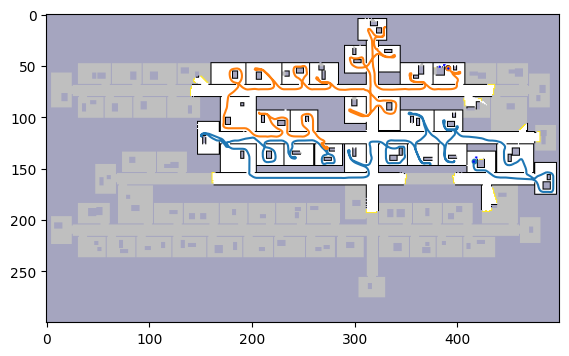

----------------------------------------
Counter: 684
Robot0: (431.48, 148.19)
Total motion: 1236.60
Robot1: (385.27, 50.47)
Total motion: 1236.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335bd3ca0>, <lsp.core.Frontier object at 0x7f8335bd3a00>, <lsp.core.Frontier object at 0x7f8335bd3070>, <lsp.core.Frontier object at 0x7f8335bd3760>, <lsp.core.Frontier object at 0x7f833584b970>, <lsp.core.Frontier object at 0x7f8335bd3e20>, <lsp.core.Frontier object at 0x7f8335bd3250>, <lsp.core.Frontier object at 0x7f832e07a640>, <lsp.core.Frontier object at 0x7f8335bd3c10>, <lsp.core.Frontier object at 0x7f832e07adf0>, <lsp.core.Frontier object at 0x7f8335bd3dc0>, <lsp.core.Frontier object at 0x7f8335bd3ac0>, <lsp.core.Frontier object at 0x7f8335bd3d00>, <lsp.core.Frontier object at 0x7f832e07af70>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335bd3c10>, <lsp.core.Frontier object at 0x7f8335bd3e20>]


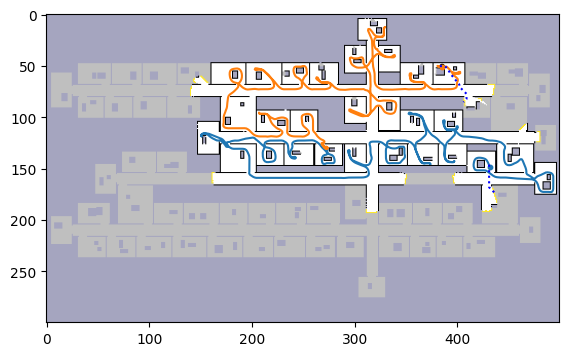

----------------------------------------
Counter: 696
Robot0: (432.27, 169.14)
Total motion: 1258.20
Robot1: (398.85, 64.62)
Total motion: 1258.20
Available frontiers: {<lsp.core.Frontier object at 0x7f833578bee0>, <lsp.core.Frontier object at 0x7f832df4b940>, <lsp.core.Frontier object at 0x7f832df4bac0>, <lsp.core.Frontier object at 0x7f833578bdf0>, <lsp.core.Frontier object at 0x7f833578b790>, <lsp.core.Frontier object at 0x7f833578b8b0>, <lsp.core.Frontier object at 0x7f832df4bd00>, <lsp.core.Frontier object at 0x7f832df4b1f0>, <lsp.core.Frontier object at 0x7f833578be50>, <lsp.core.Frontier object at 0x7f832df4b400>, <lsp.core.Frontier object at 0x7f833578bd60>, <lsp.core.Frontier object at 0x7f833578ba30>, <lsp.core.Frontier object at 0x7f832df4bd60>, <lsp.core.Frontier object at 0x7f832df4bb20>, <lsp.core.Frontier object at 0x7f833578b3a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df4bac0>, <lsp.core.Frontier object at 0x7f833578b790>]


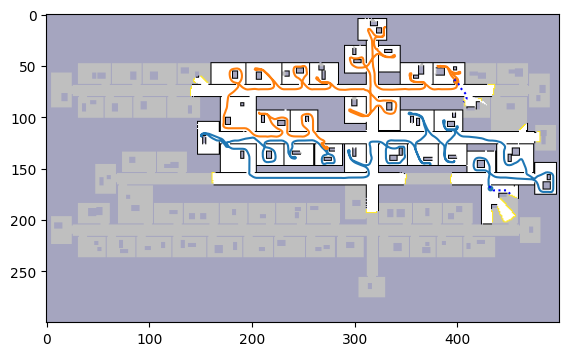

----------------------------------------
Counter: 708
Robot0: (442.19, 172.29)
Total motion: 1279.80
Robot1: (409.31, 83.05)
Total motion: 1279.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8338404cd0>, <lsp.core.Frontier object at 0x7f8338404ee0>, <lsp.core.Frontier object at 0x7f8338404a90>, <lsp.core.Frontier object at 0x7f8335a62550>, <lsp.core.Frontier object at 0x7f8338404550>, <lsp.core.Frontier object at 0x7f8335a62c10>, <lsp.core.Frontier object at 0x7f8338298550>, <lsp.core.Frontier object at 0x7f8338404400>, <lsp.core.Frontier object at 0x7f83382989a0>, <lsp.core.Frontier object at 0x7f8338298670>, <lsp.core.Frontier object at 0x7f8338404d00>, <lsp.core.Frontier object at 0x7f8338404160>, <lsp.core.Frontier object at 0x7f8338404dc0>, <lsp.core.Frontier object at 0x7f8335a62fa0>, <lsp.core.Frontier object at 0x7f8338298d60>, <lsp.core.Frontier object at 0x7f8338298e50>, <lsp.core.Frontier object at 0x7f8335a62370>}
Robots chosen subgoals: [<lsp.core.Frontier objec

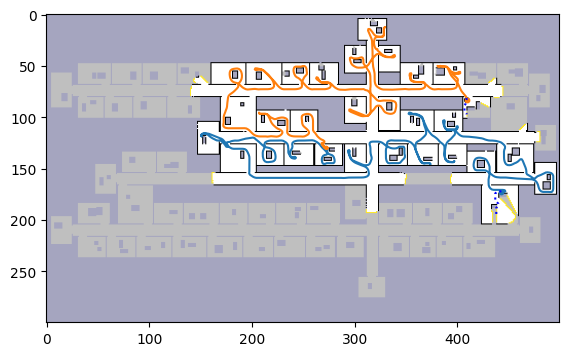

----------------------------------------
Counter: 720
Robot0: (441.00, 189.07)
Total motion: 1301.40
Robot1: (415.70, 97.48)
Total motion: 1301.40
Available frontiers: {<lsp.core.Frontier object at 0x7f83382988e0>, <lsp.core.Frontier object at 0x7f8335a49a30>, <lsp.core.Frontier object at 0x7f83358a9be0>, <lsp.core.Frontier object at 0x7f8335a49ee0>, <lsp.core.Frontier object at 0x7f8338298e20>, <lsp.core.Frontier object at 0x7f833829e280>, <lsp.core.Frontier object at 0x7f83358d6e80>, <lsp.core.Frontier object at 0x7f833829e520>, <lsp.core.Frontier object at 0x7f833829e4f0>, <lsp.core.Frontier object at 0x7f83382985b0>, <lsp.core.Frontier object at 0x7f83358a97f0>, <lsp.core.Frontier object at 0x7f83382987f0>, <lsp.core.Frontier object at 0x7f8338298940>, <lsp.core.Frontier object at 0x7f833829e160>, <lsp.core.Frontier object at 0x7f83382986d0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833829e280>, <lsp.core.Frontier object at 0x7f8335a49ee0>]


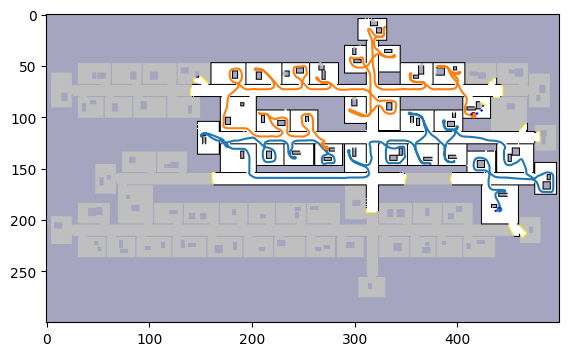

----------------------------------------
Counter: 732
Robot0: (452.71, 205.65)
Total motion: 1323.00
Robot1: (421.77, 82.92)
Total motion: 1323.00
Available frontiers: {<lsp.core.Frontier object at 0x7f833829e1f0>, <lsp.core.Frontier object at 0x7f833829e490>, <lsp.core.Frontier object at 0x7f833829e730>, <lsp.core.Frontier object at 0x7f8338542190>, <lsp.core.Frontier object at 0x7f833829e8e0>, <lsp.core.Frontier object at 0x7f833829e550>, <lsp.core.Frontier object at 0x7f833829e790>, <lsp.core.Frontier object at 0x7f833829e610>, <lsp.core.Frontier object at 0x7f833829eb80>, <lsp.core.Frontier object at 0x7f833829e6d0>, <lsp.core.Frontier object at 0x7f833829e3a0>, <lsp.core.Frontier object at 0x7f833829ebb0>, <lsp.core.Frontier object at 0x7f833829e910>, <lsp.core.Frontier object at 0x7f833829e2e0>, <lsp.core.Frontier object at 0x7f833829e970>, <lsp.core.Frontier object at 0x7f833829e2b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833829eb80>, <lsp.core.Frontier objec

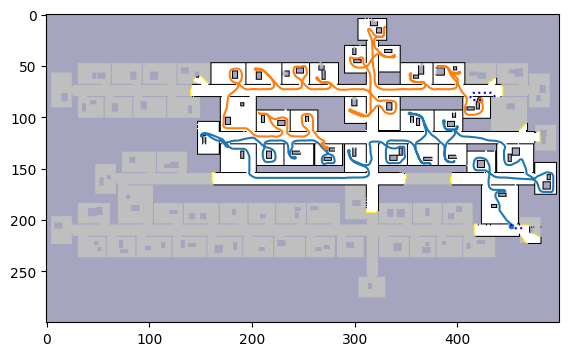

----------------------------------------
Counter: 744
Robot0: (471.17, 215.49)
Total motion: 1344.60
Robot1: (421.86, 74.42)
Total motion: 1344.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8337fedf40>, <lsp.core.Frontier object at 0x7f8337fede50>, <lsp.core.Frontier object at 0x7f8337fed340>, <lsp.core.Frontier object at 0x7f8337fed970>, <lsp.core.Frontier object at 0x7f8337fede20>, <lsp.core.Frontier object at 0x7f8337fed040>, <lsp.core.Frontier object at 0x7f8337fed370>, <lsp.core.Frontier object at 0x7f8337fed6a0>, <lsp.core.Frontier object at 0x7f8337fed1f0>, <lsp.core.Frontier object at 0x7f8337fed6d0>, <lsp.core.Frontier object at 0x7f8337fed910>, <lsp.core.Frontier object at 0x7f8337fed8b0>, <lsp.core.Frontier object at 0x7f8337fed4f0>, <lsp.core.Frontier object at 0x7f8337fedf10>, <lsp.core.Frontier object at 0x7f8337feda60>, <lsp.core.Frontier object at 0x7f8337fedbe0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337fed910>, <lsp.core.Frontier objec

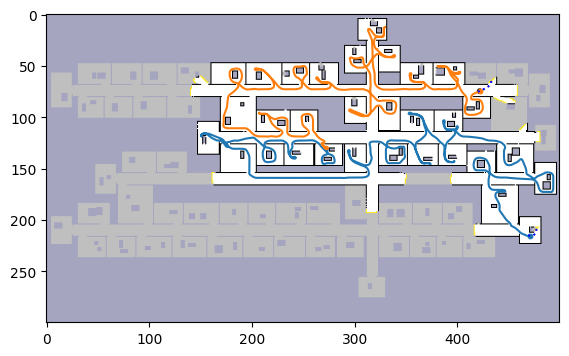

----------------------------------------
Counter: 756
Robot0: (462.69, 211.50)
Total motion: 1366.20
Robot1: (431.02, 58.83)
Total motion: 1366.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8338426ac0>, <lsp.core.Frontier object at 0x7f8338426190>, <lsp.core.Frontier object at 0x7f8338507d00>, <lsp.core.Frontier object at 0x7f8335a4ddc0>, <lsp.core.Frontier object at 0x7f83386a70a0>, <lsp.core.Frontier object at 0x7f83381612b0>, <lsp.core.Frontier object at 0x7f8338161f10>, <lsp.core.Frontier object at 0x7f8338426b80>, <lsp.core.Frontier object at 0x7f83381619d0>, <lsp.core.Frontier object at 0x7f8338161e50>, <lsp.core.Frontier object at 0x7f83381615b0>, <lsp.core.Frontier object at 0x7f83381610d0>, <lsp.core.Frontier object at 0x7f8335d45d90>, <lsp.core.Frontier object at 0x7f8338161c70>, <lsp.core.Frontier object at 0x7f8338542490>, <lsp.core.Frontier object at 0x7f8338161a90>, <lsp.core.Frontier object at 0x7f83386a72e0>}
Robots chosen subgoals: [<lsp.core.Frontier objec

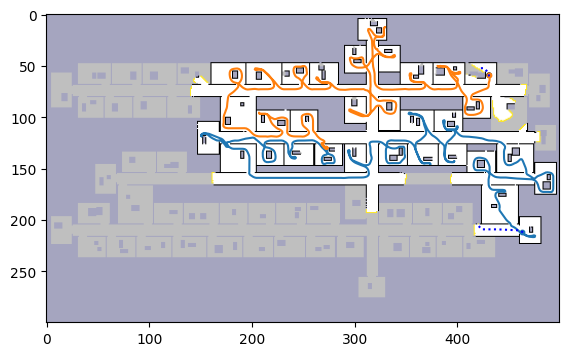

----------------------------------------
Counter: 768
Robot0: (441.37, 210.04)
Total motion: 1387.80
Robot1: (412.55, 53.28)
Total motion: 1387.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8338231790>, <lsp.core.Frontier object at 0x7f83382317c0>, <lsp.core.Frontier object at 0x7f8337fd1970>, <lsp.core.Frontier object at 0x7f83385bdca0>, <lsp.core.Frontier object at 0x7f8337fd1c40>, <lsp.core.Frontier object at 0x7f8337fd1e80>, <lsp.core.Frontier object at 0x7f8335c2b7c0>, <lsp.core.Frontier object at 0x7f8337fd1ee0>, <lsp.core.Frontier object at 0x7f8337fd15e0>, <lsp.core.Frontier object at 0x7f8337fd1100>, <lsp.core.Frontier object at 0x7f8338018ac0>, <lsp.core.Frontier object at 0x7f8338231f70>, <lsp.core.Frontier object at 0x7f8337fd16a0>, <lsp.core.Frontier object at 0x7f8337fd19a0>, <lsp.core.Frontier object at 0x7f8338018b80>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337fd1c40>, <lsp.core.Frontier object at 0x7f8337fd1970>]


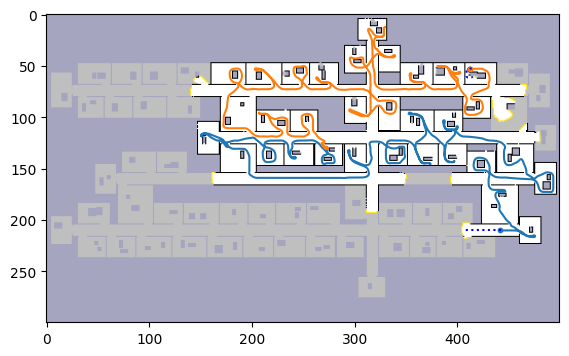

----------------------------------------
Counter: 780
Robot0: (420.05, 212.49)
Total motion: 1409.40
Robot1: (420.95, 65.49)
Total motion: 1409.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832df5c0d0>, <lsp.core.Frontier object at 0x7f832df5c580>, <lsp.core.Frontier object at 0x7f83384a1ac0>, <lsp.core.Frontier object at 0x7f832df5cac0>, <lsp.core.Frontier object at 0x7f833802f940>, <lsp.core.Frontier object at 0x7f8335cacb20>, <lsp.core.Frontier object at 0x7f832df5c910>, <lsp.core.Frontier object at 0x7f832df5c6d0>, <lsp.core.Frontier object at 0x7f8338419b80>, <lsp.core.Frontier object at 0x7f832df5c4f0>, <lsp.core.Frontier object at 0x7f832df5cdc0>, <lsp.core.Frontier object at 0x7f8338419a00>, <lsp.core.Frontier object at 0x7f8335cac9a0>, <lsp.core.Frontier object at 0x7f832df5c040>, <lsp.core.Frontier object at 0x7f833802f6a0>, <lsp.core.Frontier object at 0x7f83384a1d90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338419b80>, <lsp.core.Frontier objec

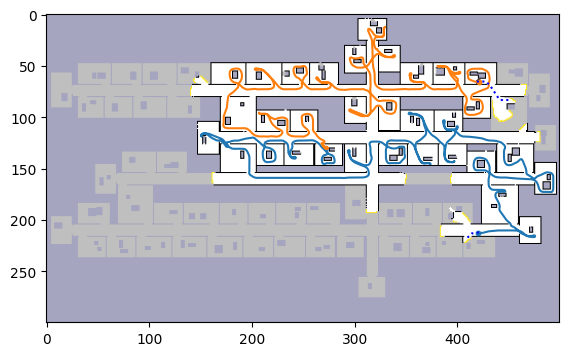

----------------------------------------
Counter: 792
Robot0: (415.39, 228.08)
Total motion: 1431.00
Robot1: (436.20, 77.06)
Total motion: 1431.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83359e09d0>, <lsp.core.Frontier object at 0x7f83359976d0>, <lsp.core.Frontier object at 0x7f8337f8c730>, <lsp.core.Frontier object at 0x7f8337f8ca60>, <lsp.core.Frontier object at 0x7f83359e0f10>, <lsp.core.Frontier object at 0x7f8335997460>, <lsp.core.Frontier object at 0x7f8335997370>, <lsp.core.Frontier object at 0x7f83359e0820>, <lsp.core.Frontier object at 0x7f83359e0f40>, <lsp.core.Frontier object at 0x7f83359e0850>, <lsp.core.Frontier object at 0x7f8337f8ccd0>, <lsp.core.Frontier object at 0x7f83359e05b0>, <lsp.core.Frontier object at 0x7f83359e0370>, <lsp.core.Frontier object at 0x7f83359e0190>, <lsp.core.Frontier object at 0x7f83359e0a60>, <lsp.core.Frontier object at 0x7f8335997940>, <lsp.core.Frontier object at 0x7f83359e00d0>, <lsp.core.Frontier object at 0x7f83359e0520>, <ls

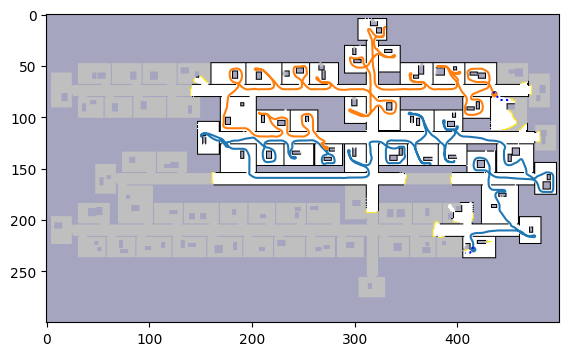

----------------------------------------
Counter: 804
Robot0: (420.79, 226.17)
Total motion: 1452.60
Robot1: (454.44, 84.53)
Total motion: 1452.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335b8edc0>, <lsp.core.Frontier object at 0x7f83359946d0>, <lsp.core.Frontier object at 0x7f8335b8e820>, <lsp.core.Frontier object at 0x7f8335b8e8b0>, <lsp.core.Frontier object at 0x7f8335b8e880>, <lsp.core.Frontier object at 0x7f8335994bb0>, <lsp.core.Frontier object at 0x7f83359943a0>, <lsp.core.Frontier object at 0x7f83359947f0>, <lsp.core.Frontier object at 0x7f8335994400>, <lsp.core.Frontier object at 0x7f83359944f0>, <lsp.core.Frontier object at 0x7f83359949a0>, <lsp.core.Frontier object at 0x7f8335994430>, <lsp.core.Frontier object at 0x7f8335994cd0>, <lsp.core.Frontier object at 0x7f8335b8e3a0>, <lsp.core.Frontier object at 0x7f8335994670>, <lsp.core.Frontier object at 0x7f8335b8e9a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335994400>, <lsp.core.Frontier objec

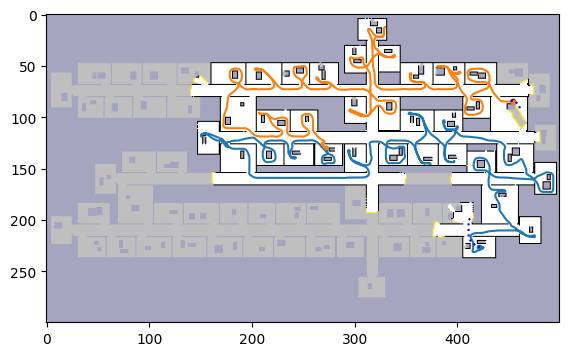

----------------------------------------
Counter: 816
Robot0: (410.03, 209.87)
Total motion: 1474.20
Robot1: (460.64, 101.89)
Total motion: 1474.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83112954f0>, <lsp.core.Frontier object at 0x7f8335983310>, <lsp.core.Frontier object at 0x7f83112956d0>, <lsp.core.Frontier object at 0x7f83112955b0>, <lsp.core.Frontier object at 0x7f8311295400>, <lsp.core.Frontier object at 0x7f83359837c0>, <lsp.core.Frontier object at 0x7f8311295f40>, <lsp.core.Frontier object at 0x7f8335983850>, <lsp.core.Frontier object at 0x7f8311295e50>, <lsp.core.Frontier object at 0x7f8311295670>, <lsp.core.Frontier object at 0x7f8311295640>, <lsp.core.Frontier object at 0x7f8335983a90>, <lsp.core.Frontier object at 0x7f8311295520>, <lsp.core.Frontier object at 0x7f8311295df0>, <lsp.core.Frontier object at 0x7f8311295e20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83112955b0>, <lsp.core.Frontier object at 0x7f8335983850>]


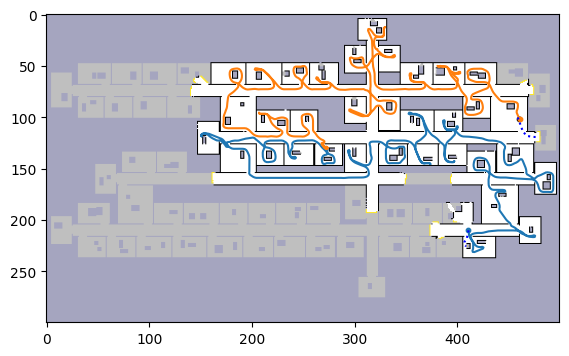

----------------------------------------
Counter: 828
Robot0: (394.89, 201.50)
Total motion: 1495.80
Robot1: (471.58, 118.53)
Total motion: 1495.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e040610>, <lsp.core.Frontier object at 0x7f832e0405e0>, <lsp.core.Frontier object at 0x7f832e040370>, <lsp.core.Frontier object at 0x7f8335c60a30>, <lsp.core.Frontier object at 0x7f8335b8edc0>, <lsp.core.Frontier object at 0x7f832e0406a0>, <lsp.core.Frontier object at 0x7f832e040520>, <lsp.core.Frontier object at 0x7f832e040310>, <lsp.core.Frontier object at 0x7f8335c60250>, <lsp.core.Frontier object at 0x7f832e0403d0>, <lsp.core.Frontier object at 0x7f8335c60970>, <lsp.core.Frontier object at 0x7f8335c60be0>, <lsp.core.Frontier object at 0x7f832e040580>, <lsp.core.Frontier object at 0x7f832e040550>, <lsp.core.Frontier object at 0x7f832e040280>, <lsp.core.Frontier object at 0x7f832e0404f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e0403d0>, <lsp.core.Frontier obje

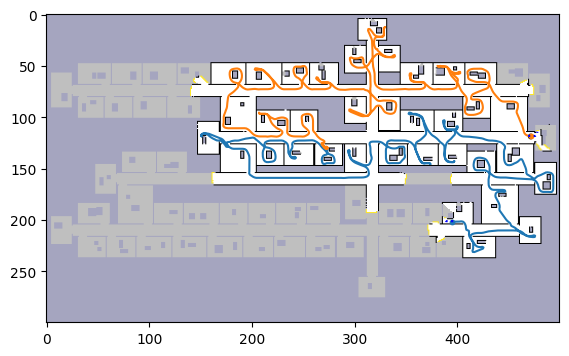

----------------------------------------
Counter: 840
Robot0: (388.35, 195.89)
Total motion: 1517.40
Robot1: (487.82, 111.29)
Total motion: 1517.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832e190d00>, <lsp.core.Frontier object at 0x7f832e190280>, <lsp.core.Frontier object at 0x7f832e190340>, <lsp.core.Frontier object at 0x7f832e190d30>, <lsp.core.Frontier object at 0x7f832e190ca0>, <lsp.core.Frontier object at 0x7f832e190dc0>, <lsp.core.Frontier object at 0x7f832e1903a0>, <lsp.core.Frontier object at 0x7f832e190be0>, <lsp.core.Frontier object at 0x7f832e190520>, <lsp.core.Frontier object at 0x7f832e190c70>, <lsp.core.Frontier object at 0x7f832e1904f0>, <lsp.core.Frontier object at 0x7f832e190400>, <lsp.core.Frontier object at 0x7f832e1905e0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1904f0>, <lsp.core.Frontier object at 0x7f832e190d30>]


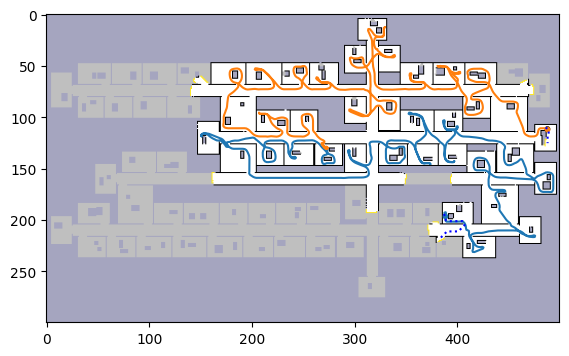

----------------------------------------
Counter: 852
Robot0: (404.37, 201.83)
Total motion: 1539.00
Robot1: (477.87, 115.55)
Total motion: 1539.00
Available frontiers: {<lsp.core.Frontier object at 0x7f832e190880>, <lsp.core.Frontier object at 0x7f832e1902b0>, <lsp.core.Frontier object at 0x7f832e1909d0>, <lsp.core.Frontier object at 0x7f832e190ee0>, <lsp.core.Frontier object at 0x7f8311112610>, <lsp.core.Frontier object at 0x7f832e190a60>, <lsp.core.Frontier object at 0x7f832e190f70>, <lsp.core.Frontier object at 0x7f832e190250>, <lsp.core.Frontier object at 0x7f832e190fa0>, <lsp.core.Frontier object at 0x7f832e1906d0>, <lsp.core.Frontier object at 0x7f832e190eb0>, <lsp.core.Frontier object at 0x7f832e190820>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1906d0>, <lsp.core.Frontier object at 0x7f832e190250>]


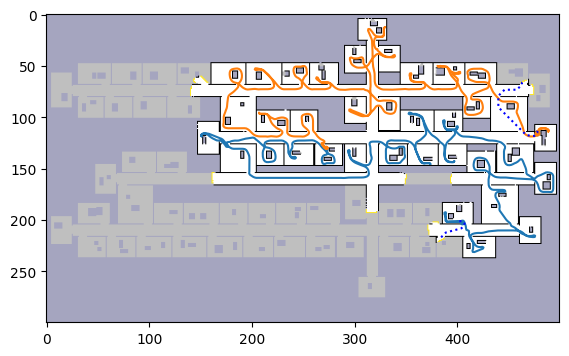

----------------------------------------
Counter: 864
Robot0: (393.92, 212.47)
Total motion: 1560.60
Robot1: (463.64, 109.93)
Total motion: 1560.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8311142a00>, <lsp.core.Frontier object at 0x7f8311142e80>, <lsp.core.Frontier object at 0x7f8311142cd0>, <lsp.core.Frontier object at 0x7f8311142e20>, <lsp.core.Frontier object at 0x7f8311142b80>, <lsp.core.Frontier object at 0x7f8311142460>, <lsp.core.Frontier object at 0x7f8311142ca0>, <lsp.core.Frontier object at 0x7f8311142a60>, <lsp.core.Frontier object at 0x7f8311142f70>, <lsp.core.Frontier object at 0x7f8311142d00>, <lsp.core.Frontier object at 0x7f8311142f40>, <lsp.core.Frontier object at 0x7f8311142b50>, <lsp.core.Frontier object at 0x7f8311142c40>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8311142cd0>, <lsp.core.Frontier object at 0x7f8311142a00>]


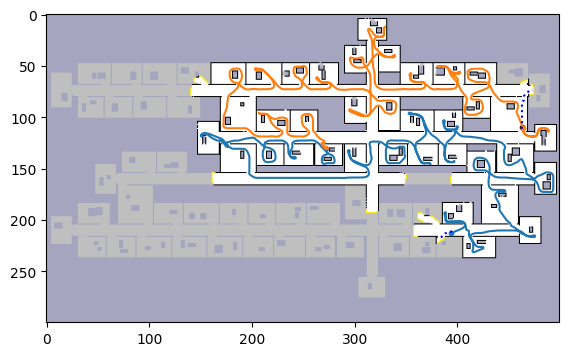

----------------------------------------
Counter: 876
Robot0: (383.49, 226.28)
Total motion: 1582.20
Robot1: (464.52, 88.38)
Total motion: 1582.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83111420d0>, <lsp.core.Frontier object at 0x7f832e1a0be0>, <lsp.core.Frontier object at 0x7f832e1a0f10>, <lsp.core.Frontier object at 0x7f832e1a09d0>, <lsp.core.Frontier object at 0x7f832e1a0c70>, <lsp.core.Frontier object at 0x7f832e0e65b0>, <lsp.core.Frontier object at 0x7f832e1a0130>, <lsp.core.Frontier object at 0x7f832e1a0d90>, <lsp.core.Frontier object at 0x7f832e1a0b50>, <lsp.core.Frontier object at 0x7f832e1a0cd0>, <lsp.core.Frontier object at 0x7f832e1a0dc0>, <lsp.core.Frontier object at 0x7f832e1a09a0>, <lsp.core.Frontier object at 0x7f832e1a0df0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1a09d0>, <lsp.core.Frontier object at 0x7f83111420d0>]


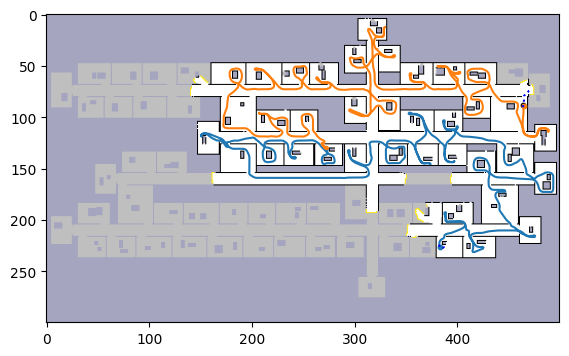

----------------------------------------
Counter: 888
Robot0: (378.34, 212.61)
Total motion: 1603.80
Robot1: (473.71, 80.84)
Total motion: 1603.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8311142ca0>, <lsp.core.Frontier object at 0x7f832e0e62e0>, <lsp.core.Frontier object at 0x7f8311142040>, <lsp.core.Frontier object at 0x7f8311142460>, <lsp.core.Frontier object at 0x7f83359736d0>, <lsp.core.Frontier object at 0x7f8311142ac0>, <lsp.core.Frontier object at 0x7f8335973d00>, <lsp.core.Frontier object at 0x7f8335973c40>, <lsp.core.Frontier object at 0x7f83359731f0>, <lsp.core.Frontier object at 0x7f8311142c40>, <lsp.core.Frontier object at 0x7f8335973a00>, <lsp.core.Frontier object at 0x7f8335973970>, <lsp.core.Frontier object at 0x7f832e0e66a0>, <lsp.core.Frontier object at 0x7f8335b4c490>, <lsp.core.Frontier object at 0x7f8311142a60>, <lsp.core.Frontier object at 0x7f8311142d90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e0e66a0>, <lsp.core.Frontier objec

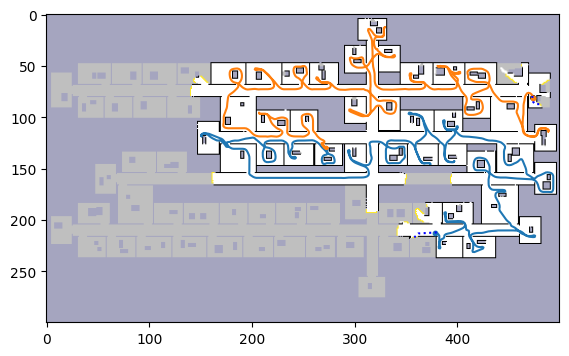

----------------------------------------
Counter: 900
Robot0: (362.06, 218.47)
Total motion: 1625.40
Robot1: (486.39, 79.27)
Total motion: 1625.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c43a00>, <lsp.core.Frontier object at 0x7f8335c43250>, <lsp.core.Frontier object at 0x7f8335c43cd0>, <lsp.core.Frontier object at 0x7f8335c43610>, <lsp.core.Frontier object at 0x7f832e1a0cd0>, <lsp.core.Frontier object at 0x7f8335c43b80>, <lsp.core.Frontier object at 0x7f8335c43190>, <lsp.core.Frontier object at 0x7f832e1a0700>, <lsp.core.Frontier object at 0x7f8335c435e0>, <lsp.core.Frontier object at 0x7f832e1a0880>, <lsp.core.Frontier object at 0x7f832e1a0580>, <lsp.core.Frontier object at 0x7f8335c432e0>, <lsp.core.Frontier object at 0x7f832e1a0dc0>, <lsp.core.Frontier object at 0x7f8335c43100>, <lsp.core.Frontier object at 0x7f8335c43c40>, <lsp.core.Frontier object at 0x7f8335c43670>, <lsp.core.Frontier object at 0x7f832e1a0e50>}
Robots chosen subgoals: [<lsp.core.Frontier objec

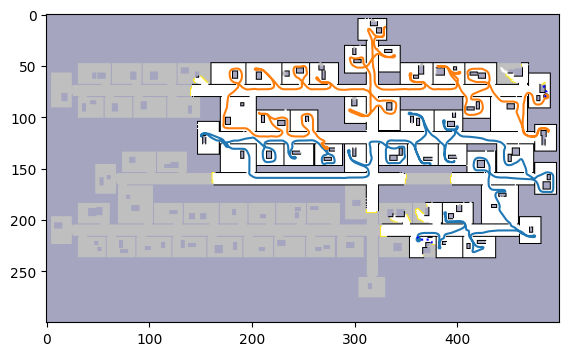

----------------------------------------
Counter: 912
Robot0: (376.47, 228.12)
Total motion: 1647.00
Robot1: (479.66, 65.96)
Total motion: 1647.00
Available frontiers: {<lsp.core.Frontier object at 0x7f833807b190>, <lsp.core.Frontier object at 0x7f833807b4f0>, <lsp.core.Frontier object at 0x7f8337f52520>, <lsp.core.Frontier object at 0x7f833807ba60>, <lsp.core.Frontier object at 0x7f833807b0a0>, <lsp.core.Frontier object at 0x7f8337f52400>, <lsp.core.Frontier object at 0x7f833807b070>, <lsp.core.Frontier object at 0x7f8337f52be0>, <lsp.core.Frontier object at 0x7f83382316d0>, <lsp.core.Frontier object at 0x7f8337f52a30>, <lsp.core.Frontier object at 0x7f8337f527f0>, <lsp.core.Frontier object at 0x7f8337f52ac0>, <lsp.core.Frontier object at 0x7f833807bdf0>, <lsp.core.Frontier object at 0x7f8337f52340>, <lsp.core.Frontier object at 0x7f833807b1c0>, <lsp.core.Frontier object at 0x7f8338231fa0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8337f52ac0>, <lsp.core.Frontier objec

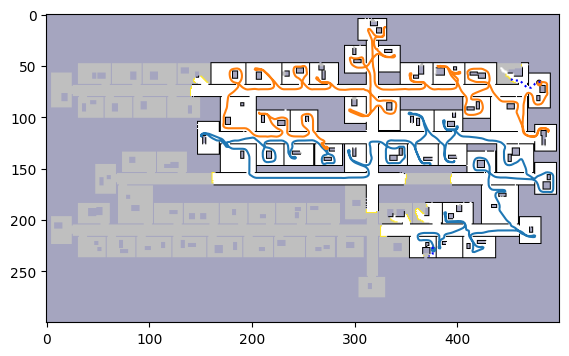

----------------------------------------
Counter: 924
Robot0: (362.52, 230.97)
Total motion: 1668.60
Robot1: (463.16, 66.42)
Total motion: 1668.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8338030520>, <lsp.core.Frontier object at 0x7f8337fcd100>, <lsp.core.Frontier object at 0x7f8337fcd580>, <lsp.core.Frontier object at 0x7f8338030130>, <lsp.core.Frontier object at 0x7f8337fcd340>, <lsp.core.Frontier object at 0x7f8338030880>, <lsp.core.Frontier object at 0x7f8337fcd220>, <lsp.core.Frontier object at 0x7f8338030a60>, <lsp.core.Frontier object at 0x7f8338030d30>, <lsp.core.Frontier object at 0x7f8338030df0>, <lsp.core.Frontier object at 0x7f8337fcd370>, <lsp.core.Frontier object at 0x7f8338030b50>, <lsp.core.Frontier object at 0x7f8338030670>, <lsp.core.Frontier object at 0x7f8337fcd130>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338030a60>, <lsp.core.Frontier object at 0x7f8338030520>]


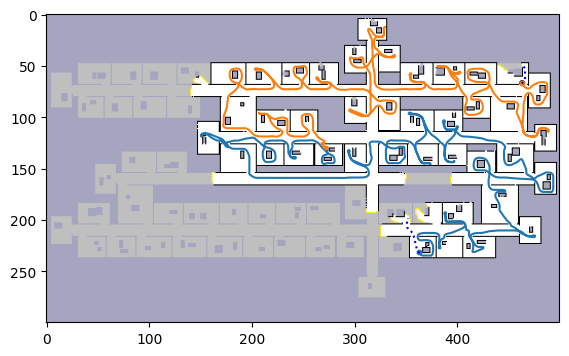

----------------------------------------
Counter: 936
Robot0: (356.09, 210.57)
Total motion: 1690.20
Robot1: (463.29, 51.42)
Total motion: 1690.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83384992e0>, <lsp.core.Frontier object at 0x7f8338499370>, <lsp.core.Frontier object at 0x7f8338499220>, <lsp.core.Frontier object at 0x7f8338499f40>, <lsp.core.Frontier object at 0x7f8338499dc0>, <lsp.core.Frontier object at 0x7f8338231d00>, <lsp.core.Frontier object at 0x7f8338499a60>, <lsp.core.Frontier object at 0x7f8338499520>, <lsp.core.Frontier object at 0x7f83384998b0>, <lsp.core.Frontier object at 0x7f83382317c0>, <lsp.core.Frontier object at 0x7f8338499c70>, <lsp.core.Frontier object at 0x7f8338499280>, <lsp.core.Frontier object at 0x7f83384991f0>, <lsp.core.Frontier object at 0x7f8338499610>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338499f40>, <lsp.core.Frontier object at 0x7f8338231d00>]


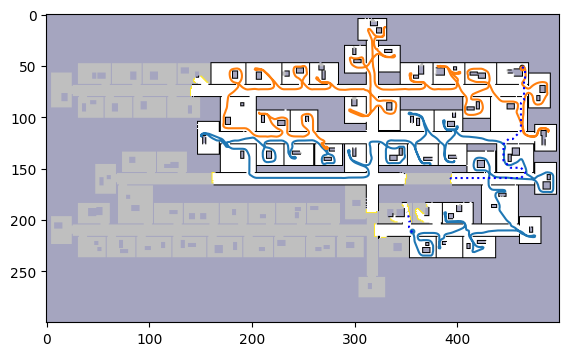

----------------------------------------
Counter: 948
Robot0: (352.11, 192.36)
Total motion: 1711.80
Robot1: (465.27, 68.65)
Total motion: 1711.80
Available frontiers: {<lsp.core.Frontier object at 0x7f83384310a0>, <lsp.core.Frontier object at 0x7f83382a6850>, <lsp.core.Frontier object at 0x7f8338431ca0>, <lsp.core.Frontier object at 0x7f8338431340>, <lsp.core.Frontier object at 0x7f83386a71c0>, <lsp.core.Frontier object at 0x7f83382a62b0>, <lsp.core.Frontier object at 0x7f83382a6970>, <lsp.core.Frontier object at 0x7f8338431a30>, <lsp.core.Frontier object at 0x7f8338431ac0>, <lsp.core.Frontier object at 0x7f83382a6b20>, <lsp.core.Frontier object at 0x7f8338431460>, <lsp.core.Frontier object at 0x7f83384314f0>, <lsp.core.Frontier object at 0x7f83382a6c40>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338431ca0>, <lsp.core.Frontier object at 0x7f8338431460>]


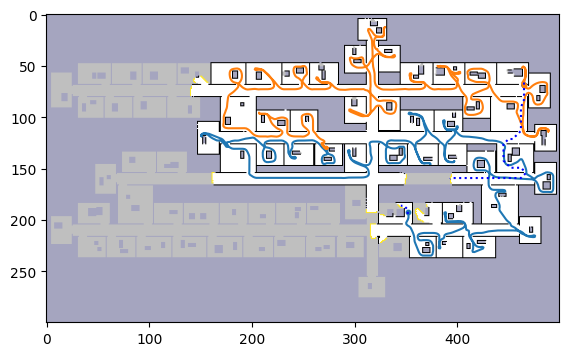

----------------------------------------
Counter: 960
Robot0: (333.38, 187.66)
Total motion: 1733.40
Robot1: (463.53, 89.91)
Total motion: 1733.40
Available frontiers: {<lsp.core.Frontier object at 0x7f833823f6d0>, <lsp.core.Frontier object at 0x7f833823f3a0>, <lsp.core.Frontier object at 0x7f8338393820>, <lsp.core.Frontier object at 0x7f8338211430>, <lsp.core.Frontier object at 0x7f8337f9d430>, <lsp.core.Frontier object at 0x7f83383935e0>, <lsp.core.Frontier object at 0x7f83383937f0>, <lsp.core.Frontier object at 0x7f833b142760>, <lsp.core.Frontier object at 0x7f833b142a90>, <lsp.core.Frontier object at 0x7f83383933a0>, <lsp.core.Frontier object at 0x7f833b142b80>, <lsp.core.Frontier object at 0x7f83383df430>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833823f3a0>, <lsp.core.Frontier object at 0x7f833b142b80>]


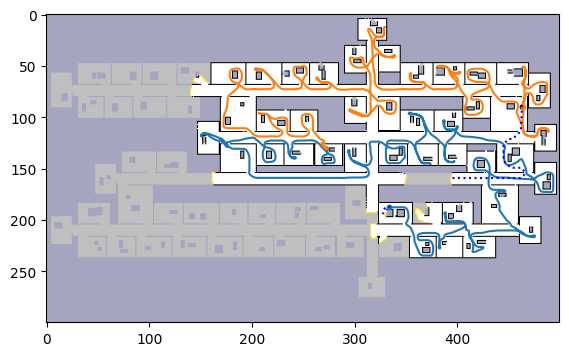

----------------------------------------
Counter: 972
Robot0: (337.07, 201.50)
Total motion: 1755.00
Robot1: (461.47, 111.33)
Total motion: 1755.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335dd3220>, <lsp.core.Frontier object at 0x7f8335dd3df0>, <lsp.core.Frontier object at 0x7f8335dd3b20>, <lsp.core.Frontier object at 0x7f8335dd3520>, <lsp.core.Frontier object at 0x7f8335dd3070>, <lsp.core.Frontier object at 0x7f8335dd33a0>, <lsp.core.Frontier object at 0x7f8335dd3550>, <lsp.core.Frontier object at 0x7f8335dd3e80>, <lsp.core.Frontier object at 0x7f8335dd38e0>, <lsp.core.Frontier object at 0x7f8335dd31c0>, <lsp.core.Frontier object at 0x7f8335dd3880>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335dd3220>, <lsp.core.Frontier object at 0x7f8335dd31c0>]


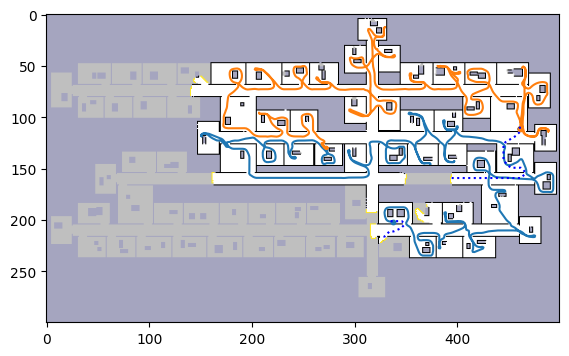

----------------------------------------
Counter: 984
Robot0: (342.89, 209.40)
Total motion: 1776.60
Robot1: (446.51, 124.84)
Total motion: 1776.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83358c5d30>, <lsp.core.Frontier object at 0x7f83358c50a0>, <lsp.core.Frontier object at 0x7f83358c5250>, <lsp.core.Frontier object at 0x7f83358c51f0>, <lsp.core.Frontier object at 0x7f83358c53d0>, <lsp.core.Frontier object at 0x7f83358c58b0>, <lsp.core.Frontier object at 0x7f83358c5be0>, <lsp.core.Frontier object at 0x7f83358c5c10>, <lsp.core.Frontier object at 0x7f83358c5070>, <lsp.core.Frontier object at 0x7f83358c5640>, <lsp.core.Frontier object at 0x7f83358c5730>, <lsp.core.Frontier object at 0x7f83358c57f0>, <lsp.core.Frontier object at 0x7f83358c5550>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358c5d30>, <lsp.core.Frontier object at 0x7f83358c57f0>]


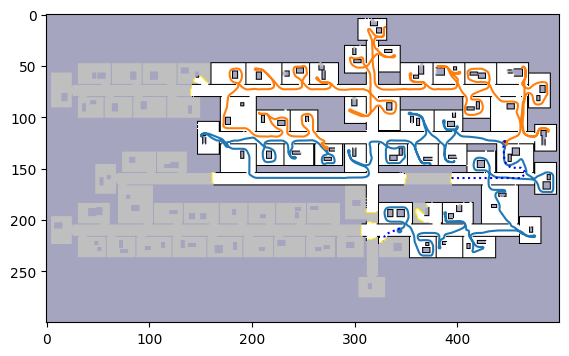

----------------------------------------
Counter: 996
Robot0: (328.41, 217.11)
Total motion: 1798.20
Robot1: (447.77, 145.43)
Total motion: 1798.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c9c3a0>, <lsp.core.Frontier object at 0x7f8335c9ccd0>, <lsp.core.Frontier object at 0x7f8335c9c430>, <lsp.core.Frontier object at 0x7f8335c9c6d0>, <lsp.core.Frontier object at 0x7f8335c9cc70>, <lsp.core.Frontier object at 0x7f8335c9c5e0>, <lsp.core.Frontier object at 0x7f8335a0b7c0>, <lsp.core.Frontier object at 0x7f8335c9c970>, <lsp.core.Frontier object at 0x7f8335c9c1c0>, <lsp.core.Frontier object at 0x7f8335a0b190>, <lsp.core.Frontier object at 0x7f8335c9c880>, <lsp.core.Frontier object at 0x7f8335a0ba90>, <lsp.core.Frontier object at 0x7f8335c9c580>, <lsp.core.Frontier object at 0x7f8335c9c790>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335c9c3a0>, <lsp.core.Frontier object at 0x7f8335a0ba90>]


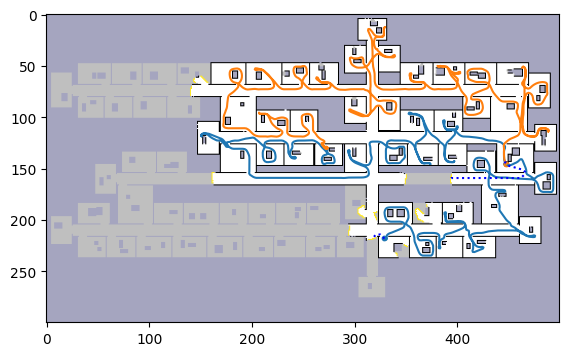

----------------------------------------
Counter: 1008
Robot0: (315.83, 205.81)
Total motion: 1819.80
Robot1: (466.53, 153.90)
Total motion: 1819.80
Available frontiers: {<lsp.core.Frontier object at 0x7f833585ac10>, <lsp.core.Frontier object at 0x7f833585a760>, <lsp.core.Frontier object at 0x7f833585aaf0>, <lsp.core.Frontier object at 0x7f833585ae20>, <lsp.core.Frontier object at 0x7f833585a2b0>, <lsp.core.Frontier object at 0x7f833585a400>, <lsp.core.Frontier object at 0x7f833585a6d0>, <lsp.core.Frontier object at 0x7f833585adc0>, <lsp.core.Frontier object at 0x7f833585a5b0>, <lsp.core.Frontier object at 0x7f833585a2e0>, <lsp.core.Frontier object at 0x7f833585a310>, <lsp.core.Frontier object at 0x7f833585a4f0>, <lsp.core.Frontier object at 0x7f832e1ed100>, <lsp.core.Frontier object at 0x7f833585abb0>, <lsp.core.Frontier object at 0x7f833585a520>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833585abb0>, <lsp.core.Frontier object at 0x7f832e1ed100>]


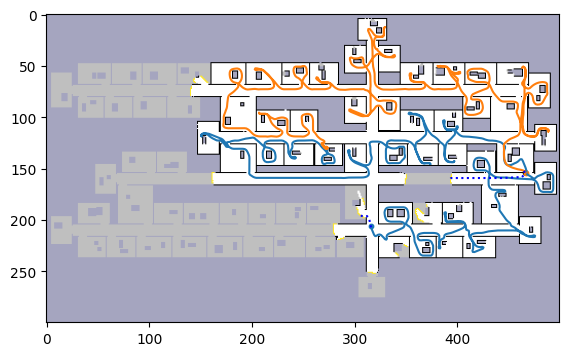

----------------------------------------
Counter: 1020
Robot0: (303.08, 191.22)
Total motion: 1841.40
Robot1: (448.14, 158.44)
Total motion: 1841.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832df4b910>, <lsp.core.Frontier object at 0x7f8335edad00>, <lsp.core.Frontier object at 0x7f832df4be50>, <lsp.core.Frontier object at 0x7f8335eda4f0>, <lsp.core.Frontier object at 0x7f832df4bb50>, <lsp.core.Frontier object at 0x7f8335eda820>, <lsp.core.Frontier object at 0x7f832df4b700>, <lsp.core.Frontier object at 0x7f832df4beb0>, <lsp.core.Frontier object at 0x7f8335eda2b0>, <lsp.core.Frontier object at 0x7f8335eda4c0>, <lsp.core.Frontier object at 0x7f8335edabb0>, <lsp.core.Frontier object at 0x7f832df4b160>, <lsp.core.Frontier object at 0x7f8335edad60>, <lsp.core.Frontier object at 0x7f832df4b6d0>, <lsp.core.Frontier object at 0x7f832df4b250>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df4b910>, <lsp.core.Frontier object at 0x7f8335edad60>]


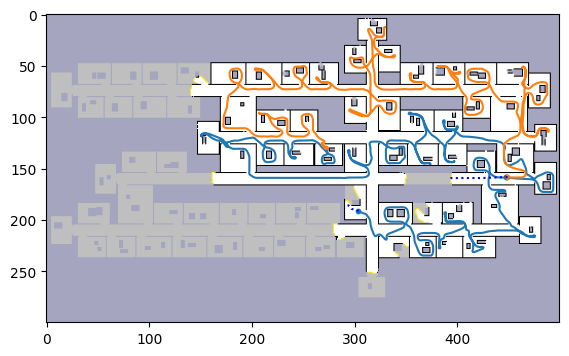

----------------------------------------
Counter: 1032
Robot0: (294.49, 180.57)
Total motion: 1863.00
Robot1: (426.54, 158.44)
Total motion: 1863.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335b22340>, <lsp.core.Frontier object at 0x7f8335b22940>, <lsp.core.Frontier object at 0x7f8335b22730>, <lsp.core.Frontier object at 0x7f8335b22190>, <lsp.core.Frontier object at 0x7f8335b223d0>, <lsp.core.Frontier object at 0x7f8311247400>, <lsp.core.Frontier object at 0x7f8335b22640>, <lsp.core.Frontier object at 0x7f8335b22d00>, <lsp.core.Frontier object at 0x7f8335b224c0>, <lsp.core.Frontier object at 0x7f8335b22400>, <lsp.core.Frontier object at 0x7f8335b22100>, <lsp.core.Frontier object at 0x7f8335b229a0>, <lsp.core.Frontier object at 0x7f8335b225b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335b229a0>, <lsp.core.Frontier object at 0x7f8335b22340>]


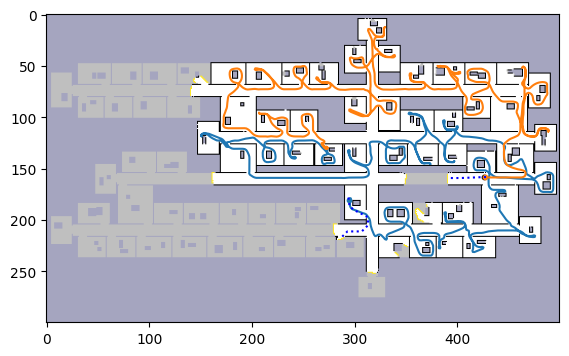

----------------------------------------
Counter: 1044
Robot0: (308.91, 194.12)
Total motion: 1884.60
Robot1: (404.94, 158.44)
Total motion: 1884.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335b76a00>, <lsp.core.Frontier object at 0x7f8335b76a30>, <lsp.core.Frontier object at 0x7f8335b76490>, <lsp.core.Frontier object at 0x7f8335b76790>, <lsp.core.Frontier object at 0x7f8335b760a0>, <lsp.core.Frontier object at 0x7f8335ad4940>, <lsp.core.Frontier object at 0x7f8335b76e50>, <lsp.core.Frontier object at 0x7f8335b76100>, <lsp.core.Frontier object at 0x7f8335b76820>, <lsp.core.Frontier object at 0x7f8335b76ee0>, <lsp.core.Frontier object at 0x7f8335b76850>, <lsp.core.Frontier object at 0x7f8335b76d00>, <lsp.core.Frontier object at 0x7f8335b76f10>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335b76d00>, <lsp.core.Frontier object at 0x7f8335b76490>]


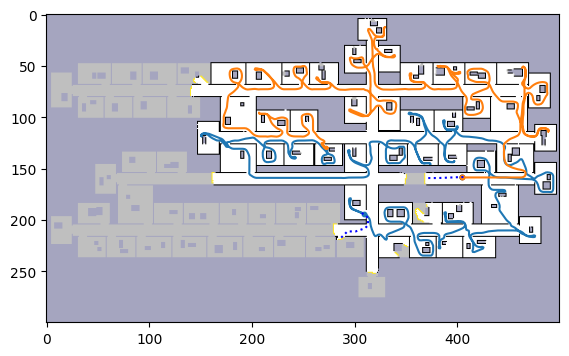

----------------------------------------
Counter: 1056
Robot0: (307.43, 209.08)
Total motion: 1906.20
Robot1: (385.14, 160.24)
Total motion: 1906.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832e1ed940>, <lsp.core.Frontier object at 0x7f832e1edd00>, <lsp.core.Frontier object at 0x7f8335b88310>, <lsp.core.Frontier object at 0x7f8335b88400>, <lsp.core.Frontier object at 0x7f832e1edf40>, <lsp.core.Frontier object at 0x7f8335a8bb80>, <lsp.core.Frontier object at 0x7f832e1eda60>, <lsp.core.Frontier object at 0x7f8335b88b50>, <lsp.core.Frontier object at 0x7f8335b88940>, <lsp.core.Frontier object at 0x7f8335b88be0>, <lsp.core.Frontier object at 0x7f832e1edfd0>, <lsp.core.Frontier object at 0x7f8335a8b610>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1ed940>, <lsp.core.Frontier object at 0x7f832e1edd00>]


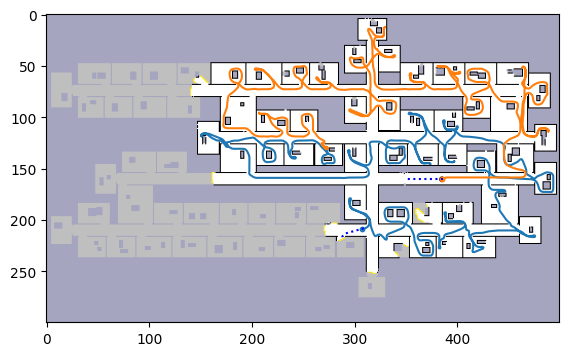

----------------------------------------
Counter: 1068
Robot0: (290.47, 217.98)
Total motion: 1927.80
Robot1: (363.55, 160.41)
Total motion: 1927.80
Available frontiers: {<lsp.core.Frontier object at 0x7f83112233d0>, <lsp.core.Frontier object at 0x7f8311223520>, <lsp.core.Frontier object at 0x7f8335ab3a00>, <lsp.core.Frontier object at 0x7f8335ab3b80>, <lsp.core.Frontier object at 0x7f832e0c8d30>, <lsp.core.Frontier object at 0x7f8311223160>, <lsp.core.Frontier object at 0x7f8335ab3910>, <lsp.core.Frontier object at 0x7f83112232e0>, <lsp.core.Frontier object at 0x7f8311223370>, <lsp.core.Frontier object at 0x7f8335ab34c0>, <lsp.core.Frontier object at 0x7f83112233a0>, <lsp.core.Frontier object at 0x7f83112231f0>, <lsp.core.Frontier object at 0x7f8335ab3e80>, <lsp.core.Frontier object at 0x7f8311223580>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83112231f0>, <lsp.core.Frontier object at 0x7f8335ab3b80>]


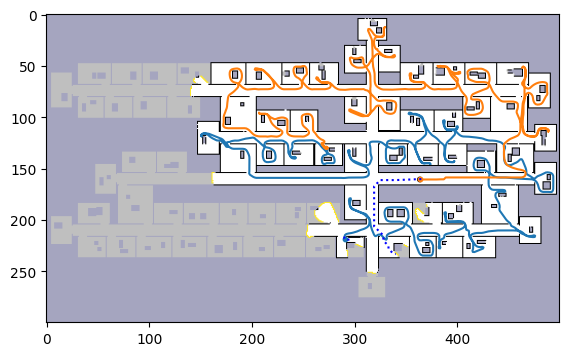

----------------------------------------
Counter: 1080
Robot0: (299.72, 230.37)
Total motion: 1949.40
Robot1: (341.97, 160.94)
Total motion: 1949.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335a8a700>, <lsp.core.Frontier object at 0x7f833593ddf0>, <lsp.core.Frontier object at 0x7f833593de50>, <lsp.core.Frontier object at 0x7f8335a8ac40>, <lsp.core.Frontier object at 0x7f8335a8a400>, <lsp.core.Frontier object at 0x7f8335a8a6d0>, <lsp.core.Frontier object at 0x7f833593d1f0>, <lsp.core.Frontier object at 0x7f8335a8a490>, <lsp.core.Frontier object at 0x7f833593db50>, <lsp.core.Frontier object at 0x7f833593ddc0>, <lsp.core.Frontier object at 0x7f8335a8a820>, <lsp.core.Frontier object at 0x7f8335a8a790>, <lsp.core.Frontier object at 0x7f8335a8a850>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a8a790>, <lsp.core.Frontier object at 0x7f833593de50>]


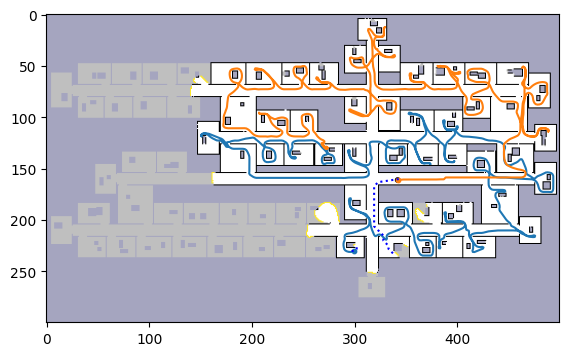

----------------------------------------
Counter: 1092
Robot0: (291.63, 218.53)
Total motion: 1971.00
Robot1: (321.46, 165.48)
Total motion: 1971.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335f2a310>, <lsp.core.Frontier object at 0x7f8335f1e100>, <lsp.core.Frontier object at 0x7f8335f1e7c0>, <lsp.core.Frontier object at 0x7f8335f1efa0>, <lsp.core.Frontier object at 0x7f8335f2a610>, <lsp.core.Frontier object at 0x7f8335f2a250>, <lsp.core.Frontier object at 0x7f8335f1ea60>, <lsp.core.Frontier object at 0x7f8335f2ae50>, <lsp.core.Frontier object at 0x7f8335f1ec70>, <lsp.core.Frontier object at 0x7f8335f1ee20>, <lsp.core.Frontier object at 0x7f8335f2af40>, <lsp.core.Frontier object at 0x7f8335f2ad00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335f1efa0>, <lsp.core.Frontier object at 0x7f8335f1e7c0>]


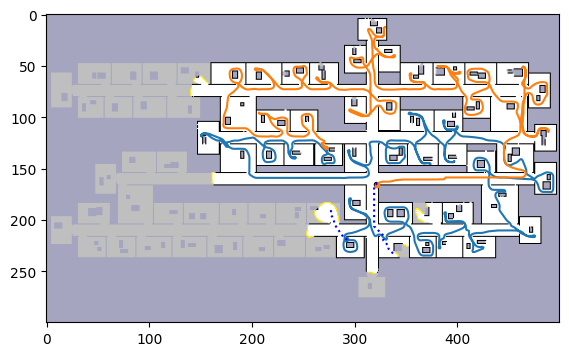

----------------------------------------
Counter: 1104
Robot0: (278.63, 203.49)
Total motion: 1992.60
Robot1: (319.39, 186.50)
Total motion: 1992.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfd2070>, <lsp.core.Frontier object at 0x7f832dfd2970>, <lsp.core.Frontier object at 0x7f832dfd2b80>, <lsp.core.Frontier object at 0x7f832dfd23a0>, <lsp.core.Frontier object at 0x7f831121a730>, <lsp.core.Frontier object at 0x7f832dfd2850>, <lsp.core.Frontier object at 0x7f832dfd22b0>, <lsp.core.Frontier object at 0x7f832dfd2760>, <lsp.core.Frontier object at 0x7f832dfd2a90>, <lsp.core.Frontier object at 0x7f832dfd28e0>, <lsp.core.Frontier object at 0x7f832dfd2940>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfd23a0>, <lsp.core.Frontier object at 0x7f832dfd2b80>]


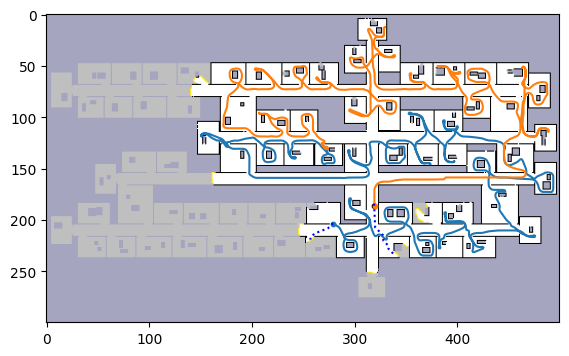

----------------------------------------
Counter: 1116
Robot0: (260.89, 214.49)
Total motion: 2014.20
Robot1: (321.32, 207.65)
Total motion: 2014.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfd2ee0>, <lsp.core.Frontier object at 0x7f832df539d0>, <lsp.core.Frontier object at 0x7f832e070f40>, <lsp.core.Frontier object at 0x7f832e0707f0>, <lsp.core.Frontier object at 0x7f832df532e0>, <lsp.core.Frontier object at 0x7f832df53a60>, <lsp.core.Frontier object at 0x7f832df53880>, <lsp.core.Frontier object at 0x7f8311227a90>, <lsp.core.Frontier object at 0x7f832e070670>, <lsp.core.Frontier object at 0x7f832e070760>, <lsp.core.Frontier object at 0x7f832e070460>, <lsp.core.Frontier object at 0x7f832df53340>, <lsp.core.Frontier object at 0x7f832df53190>, <lsp.core.Frontier object at 0x7f832df53bb0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfd2ee0>, <lsp.core.Frontier object at 0x7f832e0707f0>]


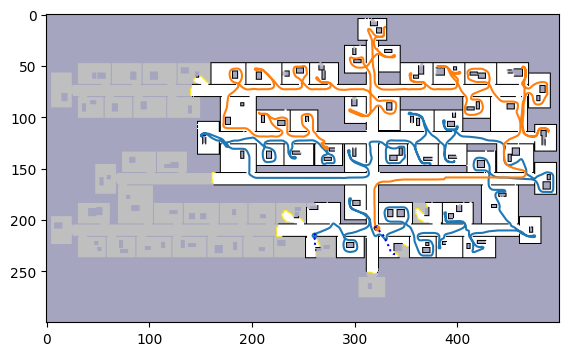

----------------------------------------
Counter: 1128
Robot0: (263.10, 233.52)
Total motion: 2035.80
Robot1: (332.40, 225.81)
Total motion: 2035.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e161fa0>, <lsp.core.Frontier object at 0x7f832e161e50>, <lsp.core.Frontier object at 0x7f832e161cd0>, <lsp.core.Frontier object at 0x7f832e1619d0>, <lsp.core.Frontier object at 0x7f832e161f40>, <lsp.core.Frontier object at 0x7f832e161850>, <lsp.core.Frontier object at 0x7f832e161e80>, <lsp.core.Frontier object at 0x7f8335f2a700>, <lsp.core.Frontier object at 0x7f832e161610>, <lsp.core.Frontier object at 0x7f8335f2aa00>, <lsp.core.Frontier object at 0x7f832e161160>, <lsp.core.Frontier object at 0x7f832e1610a0>, <lsp.core.Frontier object at 0x7f832e161a90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e1610a0>, <lsp.core.Frontier object at 0x7f832e161e80>]


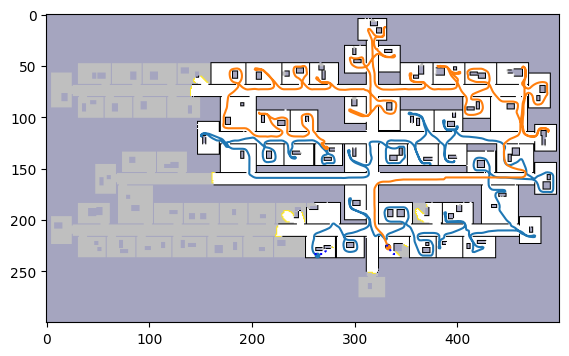

----------------------------------------
Counter: 1140
Robot0: (267.14, 233.47)
Total motion: 2057.40
Robot1: (347.19, 234.57)
Total motion: 2057.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832e070820>, <lsp.core.Frontier object at 0x7f832e0707c0>, <lsp.core.Frontier object at 0x7f832e070250>, <lsp.core.Frontier object at 0x7f8335810760>, <lsp.core.Frontier object at 0x7f832e1d7040>, <lsp.core.Frontier object at 0x7f832e0701f0>, <lsp.core.Frontier object at 0x7f832e0706a0>, <lsp.core.Frontier object at 0x7f832e070d30>, <lsp.core.Frontier object at 0x7f832e1d7ee0>, <lsp.core.Frontier object at 0x7f832e1d7ca0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e0707c0>, <lsp.core.Frontier object at 0x7f832e0706a0>]


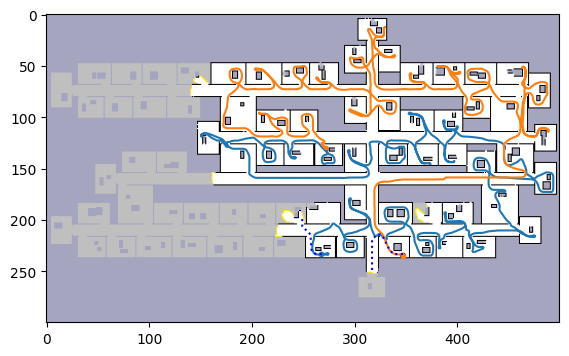

----------------------------------------
Counter: 1152
Robot0: (257.46, 217.98)
Total motion: 2079.00
Robot1: (331.90, 223.09)
Total motion: 2079.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83358ec670>, <lsp.core.Frontier object at 0x7f83358ec490>, <lsp.core.Frontier object at 0x7f832e171e20>, <lsp.core.Frontier object at 0x7f83358ecaf0>, <lsp.core.Frontier object at 0x7f83357ad670>, <lsp.core.Frontier object at 0x7f83358ecc10>, <lsp.core.Frontier object at 0x7f83358ecd60>, <lsp.core.Frontier object at 0x7f83358ec7f0>, <lsp.core.Frontier object at 0x7f83357adeb0>, <lsp.core.Frontier object at 0x7f83357ad820>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358ecaf0>, <lsp.core.Frontier object at 0x7f83358ecd60>]


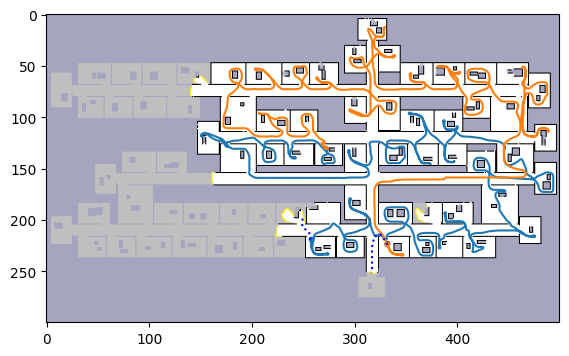

----------------------------------------
Counter: 1164
Robot0: (244.13, 202.10)
Total motion: 2100.60
Robot1: (318.87, 220.31)
Total motion: 2100.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335dd64f0>, <lsp.core.Frontier object at 0x7f8335dd6700>, <lsp.core.Frontier object at 0x7f8335dd69a0>, <lsp.core.Frontier object at 0x7f8335dd6070>, <lsp.core.Frontier object at 0x7f8335dd6940>, <lsp.core.Frontier object at 0x7f8335dd6d00>, <lsp.core.Frontier object at 0x7f8335dd6340>, <lsp.core.Frontier object at 0x7f8335dd6a00>, <lsp.core.Frontier object at 0x7f8335dd68e0>, <lsp.core.Frontier object at 0x7f8335dd6c70>, <lsp.core.Frontier object at 0x7f8335dd6e20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335dd6340>, <lsp.core.Frontier object at 0x7f8335dd6700>]


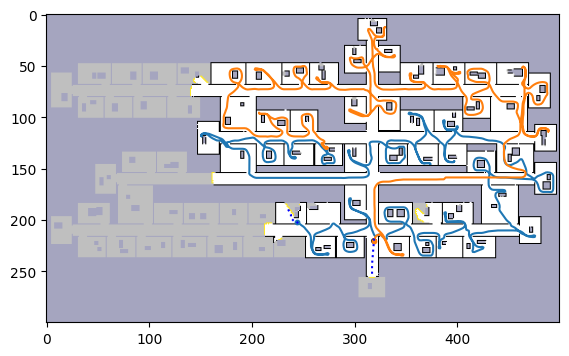

----------------------------------------
Counter: 1176
Robot0: (238.34, 186.50)
Total motion: 2122.20
Robot1: (316.47, 241.67)
Total motion: 2122.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335798fd0>, <lsp.core.Frontier object at 0x7f8335798850>, <lsp.core.Frontier object at 0x7f8335798460>, <lsp.core.Frontier object at 0x7f831121a0d0>, <lsp.core.Frontier object at 0x7f8335798580>, <lsp.core.Frontier object at 0x7f8335783280>, <lsp.core.Frontier object at 0x7f8335798370>, <lsp.core.Frontier object at 0x7f83357984c0>, <lsp.core.Frontier object at 0x7f8335783610>, <lsp.core.Frontier object at 0x7f8335798b20>, <lsp.core.Frontier object at 0x7f83357830a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335798b20>, <lsp.core.Frontier object at 0x7f8335798850>]


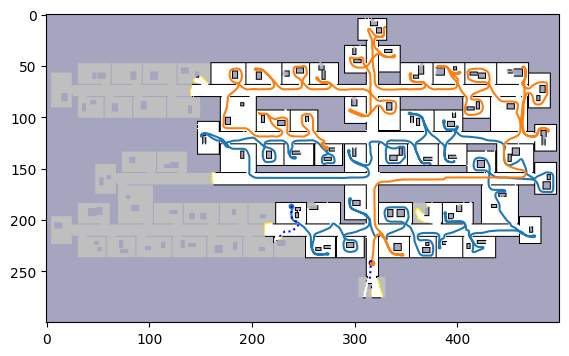

----------------------------------------
Counter: 1188
Robot0: (245.90, 203.54)
Total motion: 2143.80
Robot1: (317.11, 259.10)
Total motion: 2143.80
Available frontiers: {<lsp.core.Frontier object at 0x7f833851aa00>, <lsp.core.Frontier object at 0x7f833851adc0>, <lsp.core.Frontier object at 0x7f8335d9ce80>, <lsp.core.Frontier object at 0x7f833851aa90>, <lsp.core.Frontier object at 0x7f8335c2bc10>, <lsp.core.Frontier object at 0x7f833851a850>, <lsp.core.Frontier object at 0x7f833851a8b0>, <lsp.core.Frontier object at 0x7f8335c2b910>, <lsp.core.Frontier object at 0x7f8335d9cb50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833851aa90>, <lsp.core.Frontier object at 0x7f833851aa00>]


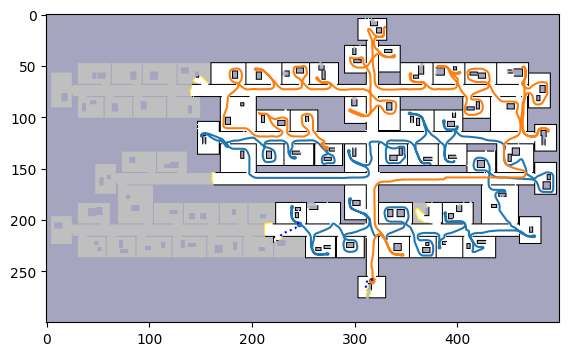

----------------------------------------
Counter: 1200
Robot0: (229.19, 214.54)
Total motion: 2165.40
Robot1: (313.59, 258.43)
Total motion: 2165.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832e10fa60>, <lsp.core.Frontier object at 0x7f832e10fd30>, <lsp.core.Frontier object at 0x7f8335798580>, <lsp.core.Frontier object at 0x7f8335798b50>, <lsp.core.Frontier object at 0x7f832e10f880>, <lsp.core.Frontier object at 0x7f833851ab80>, <lsp.core.Frontier object at 0x7f83112238e0>, <lsp.core.Frontier object at 0x7f8335798fd0>, <lsp.core.Frontier object at 0x7f83357989a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e10fa60>, <lsp.core.Frontier object at 0x7f833851ab80>]


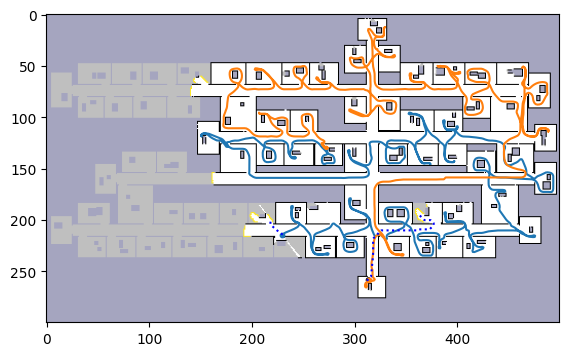

----------------------------------------
Counter: 1212
Robot0: (223.50, 226.95)
Total motion: 2187.00
Robot1: (317.62, 237.74)
Total motion: 2187.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83384a96a0>, <lsp.core.Frontier object at 0x7f83382f5c70>, <lsp.core.Frontier object at 0x7f83382f5e80>, <lsp.core.Frontier object at 0x7f83382f5fa0>, <lsp.core.Frontier object at 0x7f8338382160>, <lsp.core.Frontier object at 0x7f8338382f40>, <lsp.core.Frontier object at 0x7f83383824c0>, <lsp.core.Frontier object at 0x7f83384a9910>, <lsp.core.Frontier object at 0x7f8338382bb0>, <lsp.core.Frontier object at 0x7f83382f5d90>, <lsp.core.Frontier object at 0x7f8338382910>, <lsp.core.Frontier object at 0x7f83382f5280>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83383824c0>, <lsp.core.Frontier object at 0x7f8338382bb0>]


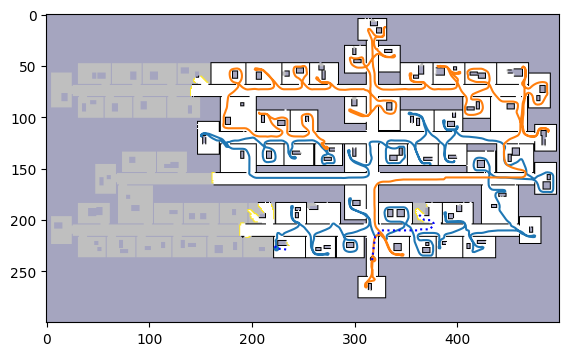

----------------------------------------
Counter: 1224
Robot0: (234.48, 219.17)
Total motion: 2208.60
Robot1: (320.59, 216.51)
Total motion: 2208.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8338215880>, <lsp.core.Frontier object at 0x7f8338215f10>, <lsp.core.Frontier object at 0x7f8338528fa0>, <lsp.core.Frontier object at 0x7f8338346940>, <lsp.core.Frontier object at 0x7f8338173280>, <lsp.core.Frontier object at 0x7f8338215af0>, <lsp.core.Frontier object at 0x7f8338215280>, <lsp.core.Frontier object at 0x7f8338215bb0>, <lsp.core.Frontier object at 0x7f83382155e0>, <lsp.core.Frontier object at 0x7f83383d1fa0>, <lsp.core.Frontier object at 0x7f83383d1fd0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338215f10>, <lsp.core.Frontier object at 0x7f8338215280>]


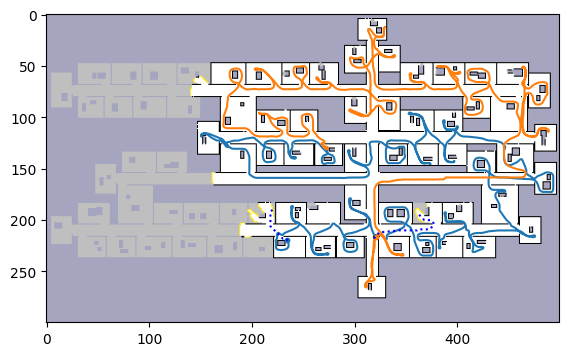

----------------------------------------
Counter: 1236
Robot0: (219.42, 205.70)
Total motion: 2230.20
Robot1: (340.41, 211.29)
Total motion: 2230.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c55d90>, <lsp.core.Frontier object at 0x7f833859adc0>, <lsp.core.Frontier object at 0x7f8335c557c0>, <lsp.core.Frontier object at 0x7f8335c559a0>, <lsp.core.Frontier object at 0x7f83382f5280>, <lsp.core.Frontier object at 0x7f8338010670>, <lsp.core.Frontier object at 0x7f8338010580>, <lsp.core.Frontier object at 0x7f8338199a60>, <lsp.core.Frontier object at 0x7f8335c55e20>, <lsp.core.Frontier object at 0x7f8335c55bb0>, <lsp.core.Frontier object at 0x7f8335c55df0>, <lsp.core.Frontier object at 0x7f8335c55040>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338199a60>, <lsp.core.Frontier object at 0x7f8338010670>]


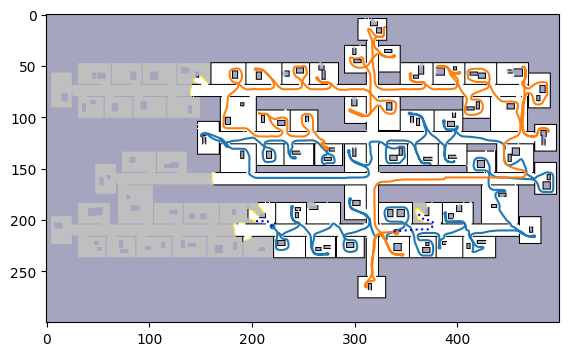

----------------------------------------
Counter: 1248
Robot0: (211.03, 193.17)
Total motion: 2253.60
Robot1: (361.86, 208.87)
Total motion: 2253.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c64cd0>, <lsp.core.Frontier object at 0x7f8335c64880>, <lsp.core.Frontier object at 0x7f8335c64a00>, <lsp.core.Frontier object at 0x7f8335c64070>, <lsp.core.Frontier object at 0x7f8335c64580>, <lsp.core.Frontier object at 0x7f8335c64ca0>, <lsp.core.Frontier object at 0x7f8335c64610>, <lsp.core.Frontier object at 0x7f8335c64fa0>, <lsp.core.Frontier object at 0x7f8335c64ee0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335c64fa0>, <lsp.core.Frontier object at 0x7f8335c64a00>]


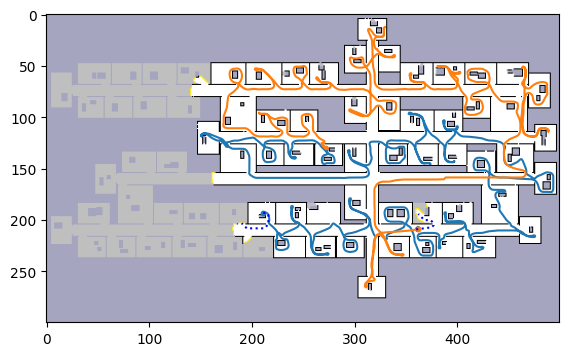

----------------------------------------
Counter: 1260
Robot0: (213.18, 207.53)
Total motion: 2275.20
Robot1: (376.93, 201.37)
Total motion: 2275.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335b8f790>, <lsp.core.Frontier object at 0x7f8335b8fd00>, <lsp.core.Frontier object at 0x7f8335b8fbe0>, <lsp.core.Frontier object at 0x7f8335b8fc40>, <lsp.core.Frontier object at 0x7f8335b8fdf0>, <lsp.core.Frontier object at 0x7f8335b8f520>, <lsp.core.Frontier object at 0x7f8335b8f910>, <lsp.core.Frontier object at 0x7f8335b8fb80>, <lsp.core.Frontier object at 0x7f8335b8f4f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335b8fdf0>, <lsp.core.Frontier object at 0x7f8335b8f520>]


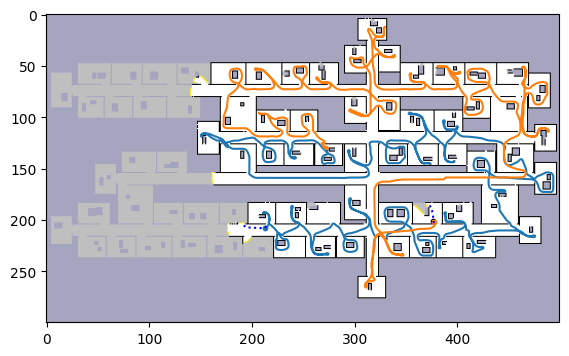

----------------------------------------
Counter: 1272
Robot0: (200.58, 220.29)
Total motion: 2296.80
Robot1: (367.92, 187.47)
Total motion: 2296.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e02a220>, <lsp.core.Frontier object at 0x7f832e02adc0>, <lsp.core.Frontier object at 0x7f832e02a790>, <lsp.core.Frontier object at 0x7f832e02a8b0>, <lsp.core.Frontier object at 0x7f832e02ad60>, <lsp.core.Frontier object at 0x7f832e02a820>, <lsp.core.Frontier object at 0x7f832e02a880>, <lsp.core.Frontier object at 0x7f832e02aa00>, <lsp.core.Frontier object at 0x7f832e02ae20>, <lsp.core.Frontier object at 0x7f832e02ae50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e02a820>, <lsp.core.Frontier object at 0x7f832e02aa00>]


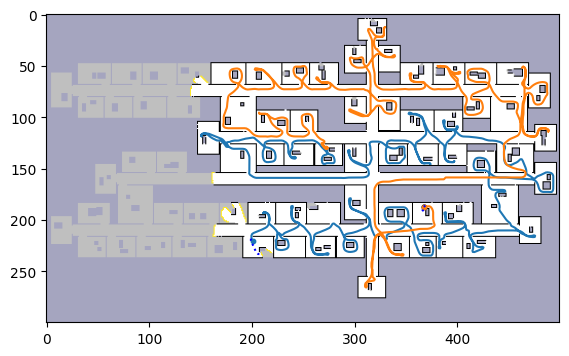

----------------------------------------
Counter: 1284
Robot0: (210.75, 232.67)
Total motion: 2320.20
Robot1: (376.67, 202.50)
Total motion: 2320.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8311183c70>, <lsp.core.Frontier object at 0x7f8337f52580>, <lsp.core.Frontier object at 0x7f8335caca90>, <lsp.core.Frontier object at 0x7f8335765dc0>, <lsp.core.Frontier object at 0x7f83357658b0>, <lsp.core.Frontier object at 0x7f8335765fd0>, <lsp.core.Frontier object at 0x7f8335cacf70>, <lsp.core.Frontier object at 0x7f8335cacc70>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8311183c70>, <lsp.core.Frontier object at 0x7f8335765fd0>]


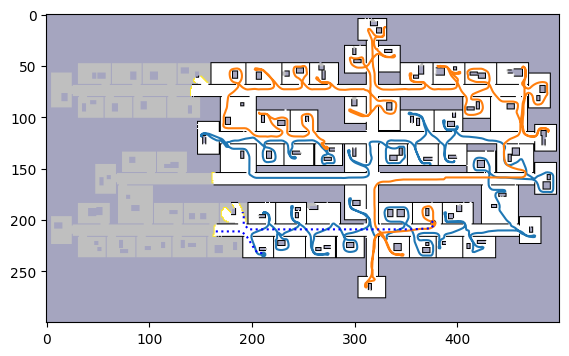

----------------------------------------
Counter: 1296
Robot0: (198.29, 218.74)
Total motion: 2341.80
Robot1: (360.72, 208.47)
Total motion: 2341.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335aea790>, <lsp.core.Frontier object at 0x7f8335aea400>, <lsp.core.Frontier object at 0x7f8335775250>, <lsp.core.Frontier object at 0x7f8335aeaa60>, <lsp.core.Frontier object at 0x7f832e03c7c0>, <lsp.core.Frontier object at 0x7f8335aea550>, <lsp.core.Frontier object at 0x7f83359ca2b0>, <lsp.core.Frontier object at 0x7f8335aeaa90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335aea790>, <lsp.core.Frontier object at 0x7f8335775250>]


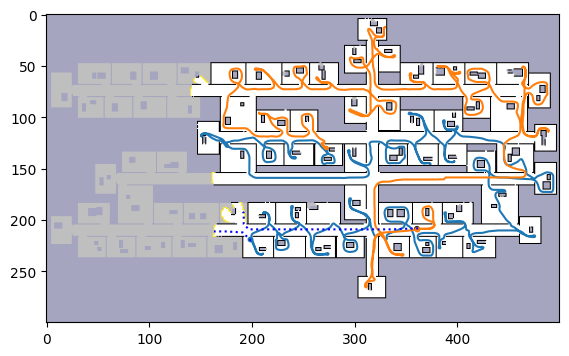

----------------------------------------
Counter: 1308
Robot0: (186.04, 201.51)
Total motion: 2363.40
Robot1: (339.12, 208.47)
Total motion: 2363.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335e17d90>, <lsp.core.Frontier object at 0x7f8335e17df0>, <lsp.core.Frontier object at 0x7f8335cbe850>, <lsp.core.Frontier object at 0x7f832e02a700>, <lsp.core.Frontier object at 0x7f832e02aca0>, <lsp.core.Frontier object at 0x7f832e02ac10>, <lsp.core.Frontier object at 0x7f8335e17e50>, <lsp.core.Frontier object at 0x7f8335e17e80>, <lsp.core.Frontier object at 0x7f8335e17d60>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e02a700>, <lsp.core.Frontier object at 0x7f832e02ac10>]


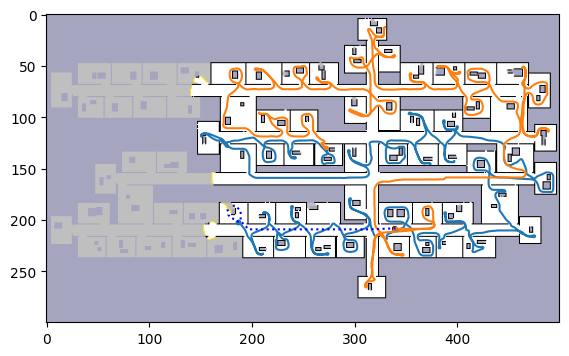

----------------------------------------
Counter: 1320
Robot0: (179.50, 197.06)
Total motion: 2385.00
Robot1: (317.55, 209.14)
Total motion: 2385.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8311174880>, <lsp.core.Frontier object at 0x7f83111744c0>, <lsp.core.Frontier object at 0x7f8311174a60>, <lsp.core.Frontier object at 0x7f8335e093a0>, <lsp.core.Frontier object at 0x7f8311174550>, <lsp.core.Frontier object at 0x7f8335e09df0>, <lsp.core.Frontier object at 0x7f8311174430>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335e09df0>, <lsp.core.Frontier object at 0x7f8311174550>]


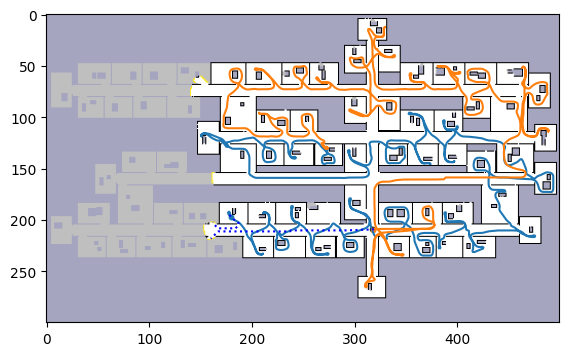

----------------------------------------
Counter: 1332
Robot0: (179.63, 208.48)
Total motion: 2406.60
Robot1: (295.97, 209.84)
Total motion: 2406.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335cebd30>, <lsp.core.Frontier object at 0x7f83357f5130>, <lsp.core.Frontier object at 0x7f83357f5a30>, <lsp.core.Frontier object at 0x7f83357f5400>, <lsp.core.Frontier object at 0x7f83357f5100>, <lsp.core.Frontier object at 0x7f83357f5c10>, <lsp.core.Frontier object at 0x7f83357f5d90>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83357f5130>, <lsp.core.Frontier object at 0x7f83357f5100>]


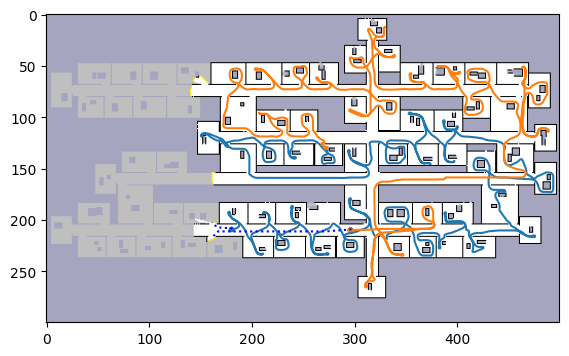

----------------------------------------
Counter: 1344
Robot0: (160.12, 202.08)
Total motion: 2428.20
Robot1: (274.38, 210.42)
Total motion: 2428.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335994040>, <lsp.core.Frontier object at 0x7f8335994070>, <lsp.core.Frontier object at 0x7f83359945e0>, <lsp.core.Frontier object at 0x7f83359944c0>, <lsp.core.Frontier object at 0x7f8335994520>, <lsp.core.Frontier object at 0x7f8335994a60>, <lsp.core.Frontier object at 0x7f8335994be0>, <lsp.core.Frontier object at 0x7f8335994b50>, <lsp.core.Frontier object at 0x7f8335994340>, <lsp.core.Frontier object at 0x7f8335994a00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335994040>, <lsp.core.Frontier object at 0x7f8335994b50>]


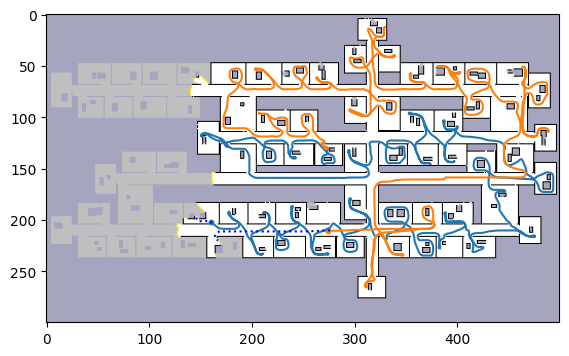

----------------------------------------
Counter: 1356
Robot0: (147.52, 192.64)
Total motion: 2449.80
Robot1: (252.78, 210.42)
Total motion: 2449.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335917040>, <lsp.core.Frontier object at 0x7f832e040580>, <lsp.core.Frontier object at 0x7f832e040be0>, <lsp.core.Frontier object at 0x7f8335917a30>, <lsp.core.Frontier object at 0x7f83359ca490>, <lsp.core.Frontier object at 0x7f83359176d0>, <lsp.core.Frontier object at 0x7f8335917910>, <lsp.core.Frontier object at 0x7f8335917fd0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e040580>, <lsp.core.Frontier object at 0x7f8335917040>]


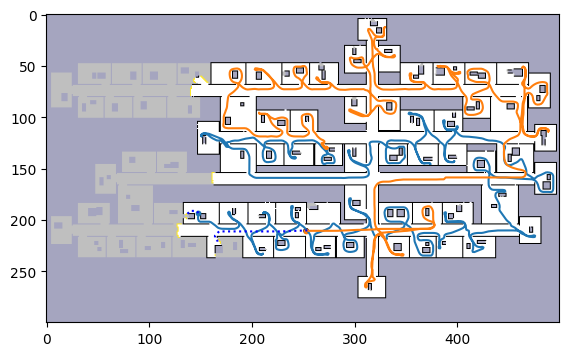

----------------------------------------
Counter: 1368
Robot0: (147.27, 190.48)
Total motion: 2471.40
Robot1: (231.18, 210.42)
Total motion: 2471.40
Available frontiers: {<lsp.core.Frontier object at 0x7f83380303d0>, <lsp.core.Frontier object at 0x7f832df86ca0>, <lsp.core.Frontier object at 0x7f8335cbe580>, <lsp.core.Frontier object at 0x7f83380309a0>, <lsp.core.Frontier object at 0x7f83380309d0>, <lsp.core.Frontier object at 0x7f8338030490>, <lsp.core.Frontier object at 0x7f8335cbe610>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83380303d0>, <lsp.core.Frontier object at 0x7f83380309d0>]


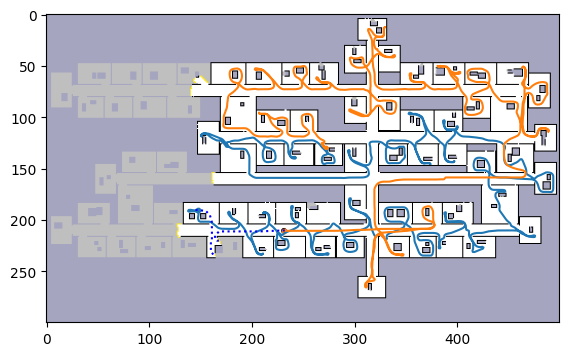

----------------------------------------
Counter: 1380
Robot0: (161.77, 202.71)
Total motion: 2493.00
Robot1: (209.58, 210.42)
Total motion: 2493.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83386a7100>, <lsp.core.Frontier object at 0x7f8338647790>, <lsp.core.Frontier object at 0x7f83359e0340>, <lsp.core.Frontier object at 0x7f8338507d00>, <lsp.core.Frontier object at 0x7f83386a7580>, <lsp.core.Frontier object at 0x7f83359e0e20>, <lsp.core.Frontier object at 0x7f83359e03d0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83386a7100>, <lsp.core.Frontier object at 0x7f83386a7580>]


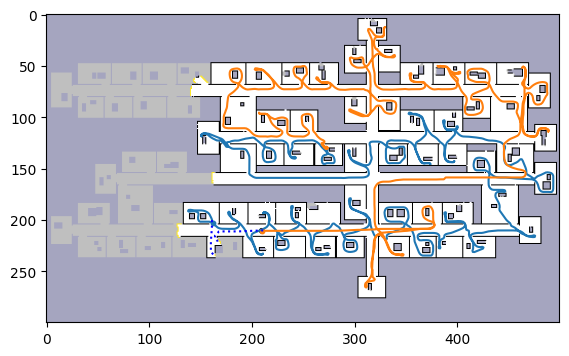

----------------------------------------
Counter: 1392
Robot0: (160.51, 224.12)
Total motion: 2514.60
Robot1: (188.00, 210.68)
Total motion: 2514.60
Available frontiers: {<lsp.core.Frontier object at 0x7f8335917d00>, <lsp.core.Frontier object at 0x7f8338199e50>, <lsp.core.Frontier object at 0x7f8338507130>, <lsp.core.Frontier object at 0x7f8338499100>, <lsp.core.Frontier object at 0x7f8338199b80>, <lsp.core.Frontier object at 0x7f83359174f0>, <lsp.core.Frontier object at 0x7f83381996a0>, <lsp.core.Frontier object at 0x7f83383815e0>, <lsp.core.Frontier object at 0x7f8338199d00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338507130>, <lsp.core.Frontier object at 0x7f8335917d00>]


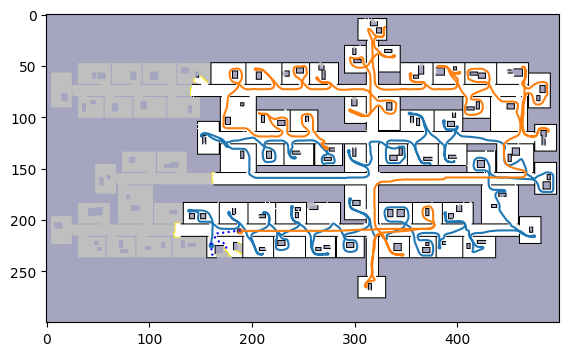

----------------------------------------
Counter: 1404
Robot0: (172.83, 234.49)
Total motion: 2536.20
Robot1: (166.71, 213.53)
Total motion: 2536.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8338203d00>, <lsp.core.Frontier object at 0x7f8338419430>, <lsp.core.Frontier object at 0x7f8338203220>, <lsp.core.Frontier object at 0x7f83382034f0>, <lsp.core.Frontier object at 0x7f83382030d0>, <lsp.core.Frontier object at 0x7f8338203190>, <lsp.core.Frontier object at 0x7f8338203430>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8338203d00>, <lsp.core.Frontier object at 0x7f8338203190>]


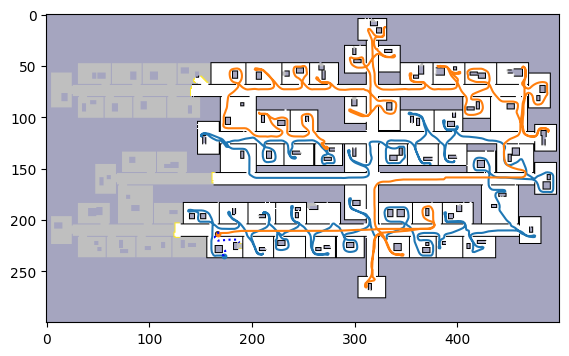

----------------------------------------
Counter: 1416
Robot0: (184.45, 233.10)
Total motion: 2557.80
Robot1: (160.11, 215.24)
Total motion: 2557.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335dcf790>, <lsp.core.Frontier object at 0x7f8335dcf940>, <lsp.core.Frontier object at 0x7f8335dcf2e0>, <lsp.core.Frontier object at 0x7f8335dcff40>, <lsp.core.Frontier object at 0x7f8338058610>, <lsp.core.Frontier object at 0x7f8335dcf2b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335dcf2e0>, <lsp.core.Frontier object at 0x7f8338058610>]


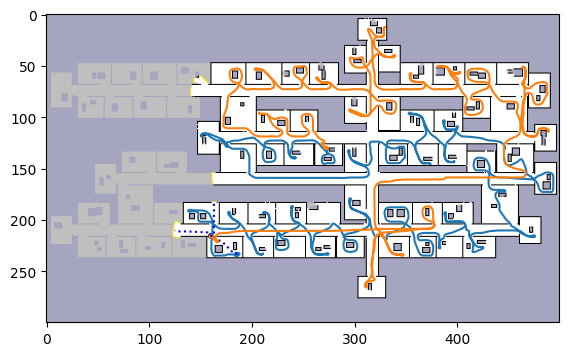

----------------------------------------
Counter: 1428
Robot0: (167.62, 220.34)
Total motion: 2579.40
Robot1: (139.42, 212.53)
Total motion: 2579.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335a803a0>, <lsp.core.Frontier object at 0x7f8335a802b0>, <lsp.core.Frontier object at 0x7f8335a80ee0>, <lsp.core.Frontier object at 0x7f8335a80340>, <lsp.core.Frontier object at 0x7f8335a80790>, <lsp.core.Frontier object at 0x7f8335a80310>, <lsp.core.Frontier object at 0x7f8335a80d00>, <lsp.core.Frontier object at 0x7f8335a80b20>, <lsp.core.Frontier object at 0x7f8335a80ca0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a80310>, <lsp.core.Frontier object at 0x7f8335a803a0>]


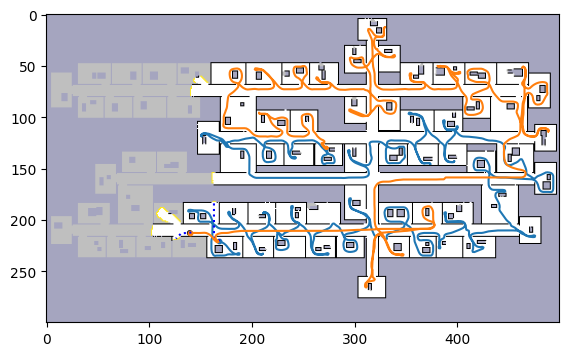

----------------------------------------
Counter: 1440
Robot0: (163.50, 200.88)
Total motion: 2601.00
Robot1: (132.54, 218.47)
Total motion: 2601.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83358d6040>, <lsp.core.Frontier object at 0x7f8335d8e580>, <lsp.core.Frontier object at 0x7f83358d6940>, <lsp.core.Frontier object at 0x7f8335d8e9a0>, <lsp.core.Frontier object at 0x7f833578b580>, <lsp.core.Frontier object at 0x7f8335d8ef10>, <lsp.core.Frontier object at 0x7f833578b160>, <lsp.core.Frontier object at 0x7f833578b0d0>, <lsp.core.Frontier object at 0x7f8335d8ed90>, <lsp.core.Frontier object at 0x7f833578bcd0>, <lsp.core.Frontier object at 0x7f8335798b20>, <lsp.core.Frontier object at 0x7f833578be50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f833578b160>, <lsp.core.Frontier object at 0x7f8335d8ef10>]


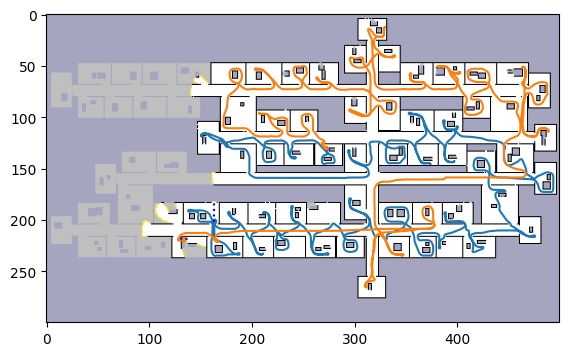

----------------------------------------
Counter: 1452
Robot0: (163.24, 184.86)
Total motion: 2624.40
Robot1: (138.38, 231.81)
Total motion: 2624.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335a0bbe0>, <lsp.core.Frontier object at 0x7f8335a0b550>, <lsp.core.Frontier object at 0x7f8335a0bd90>, <lsp.core.Frontier object at 0x7f8335a0b580>, <lsp.core.Frontier object at 0x7f8335a0b0a0>, <lsp.core.Frontier object at 0x7f8335a0be80>, <lsp.core.Frontier object at 0x7f8335a0bac0>, <lsp.core.Frontier object at 0x7f8335a0bc10>, <lsp.core.Frontier object at 0x7f8335a0b6a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a0bc10>, <lsp.core.Frontier object at 0x7f8335a0bd90>]


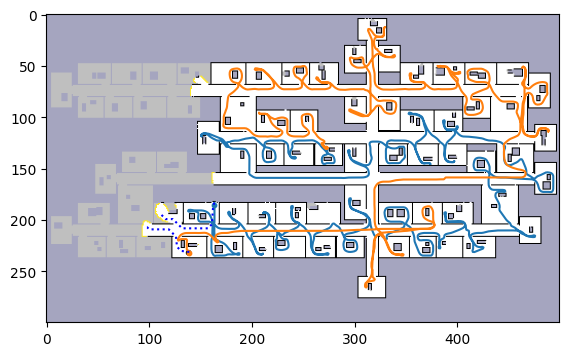

----------------------------------------
Counter: 1464
Robot0: (160.49, 206.08)
Total motion: 2646.00
Robot1: (132.01, 230.47)
Total motion: 2646.00
Available frontiers: {<lsp.core.Frontier object at 0x7f832e0888e0>, <lsp.core.Frontier object at 0x7f83359235b0>, <lsp.core.Frontier object at 0x7f832e088430>, <lsp.core.Frontier object at 0x7f832e088e50>, <lsp.core.Frontier object at 0x7f832e088d60>, <lsp.core.Frontier object at 0x7f832e088220>, <lsp.core.Frontier object at 0x7f832e088fa0>, <lsp.core.Frontier object at 0x7f832e088d00>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e088fa0>, <lsp.core.Frontier object at 0x7f832e088e50>]


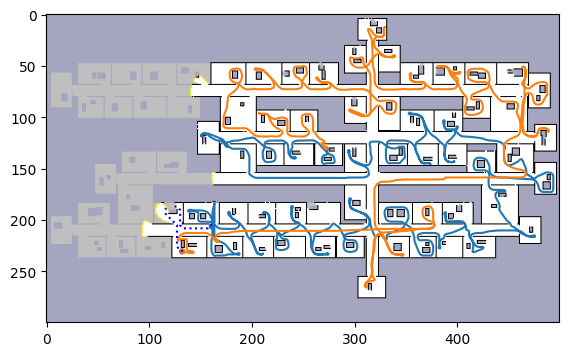

----------------------------------------
Counter: 1476
Robot0: (140.18, 208.48)
Total motion: 2667.60
Robot1: (126.58, 210.88)
Total motion: 2667.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832df509a0>, <lsp.core.Frontier object at 0x7f832df50610>, <lsp.core.Frontier object at 0x7f832df50070>, <lsp.core.Frontier object at 0x7f832df50730>, <lsp.core.Frontier object at 0x7f832df50cd0>, <lsp.core.Frontier object at 0x7f832df50220>, <lsp.core.Frontier object at 0x7f832df504f0>, <lsp.core.Frontier object at 0x7f832df50f40>, <lsp.core.Frontier object at 0x7f832df50b20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832df504f0>, <lsp.core.Frontier object at 0x7f832df50610>]


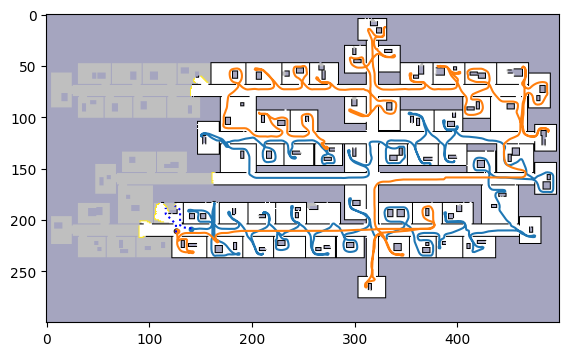

----------------------------------------
Counter: 1488
Robot0: (129.46, 195.69)
Total motion: 2689.20
Robot1: (116.01, 195.00)
Total motion: 2689.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335f0c160>, <lsp.core.Frontier object at 0x7f8335f0c2e0>, <lsp.core.Frontier object at 0x7f8335f0c040>, <lsp.core.Frontier object at 0x7f8335f0c070>, <lsp.core.Frontier object at 0x7f8335f0c0d0>, <lsp.core.Frontier object at 0x7f8335f0ceb0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335f0c2e0>, <lsp.core.Frontier object at 0x7f8335f0c160>]


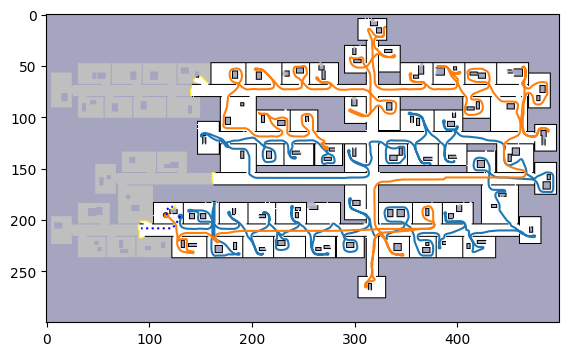

----------------------------------------
Counter: 1500
Robot0: (138.74, 208.45)
Total motion: 2710.80
Robot1: (121.28, 199.31)
Total motion: 2710.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e0e2670>, <lsp.core.Frontier object at 0x7f832e0e2760>, <lsp.core.Frontier object at 0x7f832e0e24f0>, <lsp.core.Frontier object at 0x7f83358cf970>, <lsp.core.Frontier object at 0x7f832e0e2e20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358cf970>, <lsp.core.Frontier object at 0x7f832e0e2670>]


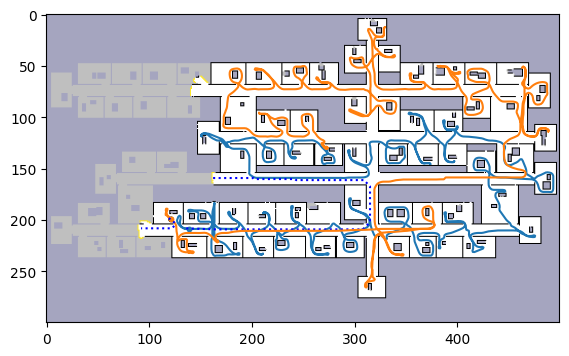

----------------------------------------
Counter: 1512
Robot0: (145.94, 210.42)
Total motion: 2732.40
Robot1: (114.16, 208.51)
Total motion: 2732.40
Available frontiers: {<lsp.core.Frontier object at 0x7f832df4b9d0>, <lsp.core.Frontier object at 0x7f832df4b250>, <lsp.core.Frontier object at 0x7f832e0f57f0>, <lsp.core.Frontier object at 0x7f832e13aa30>, <lsp.core.Frontier object at 0x7f83381b3520>, <lsp.core.Frontier object at 0x7f8335b76970>, <lsp.core.Frontier object at 0x7f832e13a4c0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e13aa30>, <lsp.core.Frontier object at 0x7f83381b3520>]


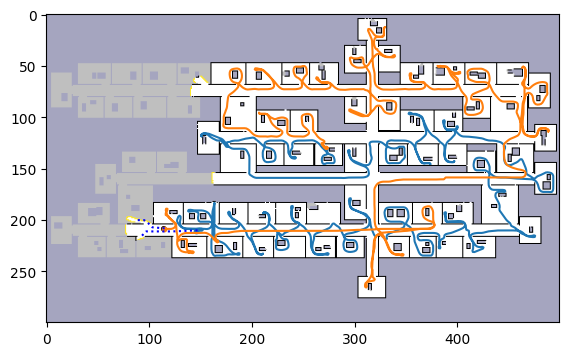

----------------------------------------
Counter: 1524
Robot0: (124.34, 210.42)
Total motion: 2754.00
Robot1: (95.06, 200.83)
Total motion: 2754.00
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfb1f10>, <lsp.core.Frontier object at 0x7f832dfb14c0>, <lsp.core.Frontier object at 0x7f83110af4c0>, <lsp.core.Frontier object at 0x7f832dfb1fd0>, <lsp.core.Frontier object at 0x7f83110af1f0>, <lsp.core.Frontier object at 0x7f83110af400>, <lsp.core.Frontier object at 0x7f832dfb13a0>, <lsp.core.Frontier object at 0x7f832dfb1ee0>, <lsp.core.Frontier object at 0x7f832dfb1df0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfb1df0>, <lsp.core.Frontier object at 0x7f832dfb1ee0>]


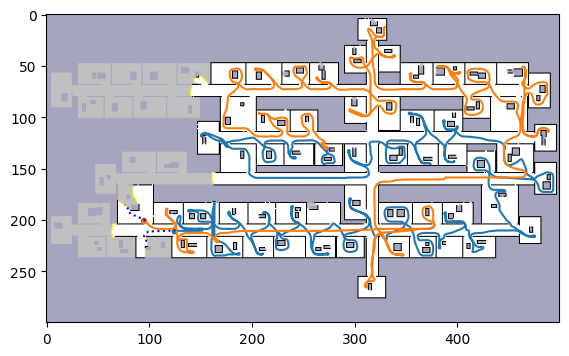

----------------------------------------
Counter: 1536
Robot0: (102.93, 212.53)
Total motion: 2775.60
Robot1: (80.53, 187.69)
Total motion: 2775.60
Available frontiers: {<lsp.core.Frontier object at 0x7f832dfdacd0>, <lsp.core.Frontier object at 0x7f832dfda2b0>, <lsp.core.Frontier object at 0x7f832dfda640>, <lsp.core.Frontier object at 0x7f832dfda130>, <lsp.core.Frontier object at 0x7f832dfda700>, <lsp.core.Frontier object at 0x7f832dfda7c0>, <lsp.core.Frontier object at 0x7f832dfda550>, <lsp.core.Frontier object at 0x7f832dfdae80>, <lsp.core.Frontier object at 0x7f8335f3b100>, <lsp.core.Frontier object at 0x7f8335f3b0a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfdacd0>, <lsp.core.Frontier object at 0x7f832dfda130>]


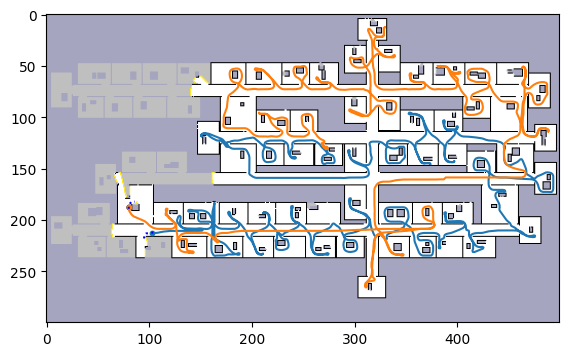

----------------------------------------
Counter: 1548
Robot0: (93.43, 228.08)
Total motion: 2797.20
Robot1: (76.00, 169.33)
Total motion: 2797.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335ad43d0>, <lsp.core.Frontier object at 0x7f832dfc3cd0>, <lsp.core.Frontier object at 0x7f832e0b34c0>, <lsp.core.Frontier object at 0x7f832dfc37c0>, <lsp.core.Frontier object at 0x7f832dfc3ee0>, <lsp.core.Frontier object at 0x7f832dfc3460>, <lsp.core.Frontier object at 0x7f832dfc3820>, <lsp.core.Frontier object at 0x7f832dfc3fd0>, <lsp.core.Frontier object at 0x7f832dfc3160>, <lsp.core.Frontier object at 0x7f832dfc3d00>, <lsp.core.Frontier object at 0x7f832dfc30d0>, <lsp.core.Frontier object at 0x7f832dfc3640>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dfc3ee0>, <lsp.core.Frontier object at 0x7f832dfc3160>]


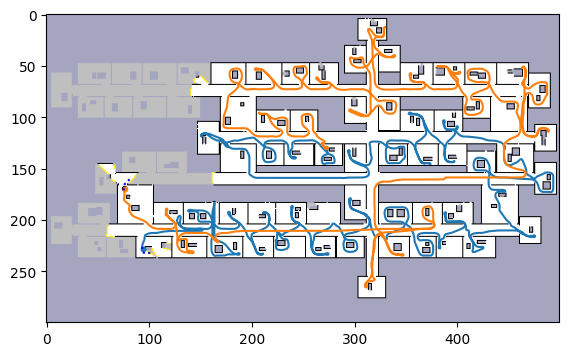

----------------------------------------
Counter: 1560
Robot0: (111.68, 231.51)
Total motion: 2818.80
Robot1: (60.29, 166.18)
Total motion: 2818.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832dffc9a0>, <lsp.core.Frontier object at 0x7f832dffcd00>, <lsp.core.Frontier object at 0x7f833834f9a0>, <lsp.core.Frontier object at 0x7f832dffcf40>, <lsp.core.Frontier object at 0x7f832dffc4c0>, <lsp.core.Frontier object at 0x7f832dffc640>, <lsp.core.Frontier object at 0x7f832dffc940>, <lsp.core.Frontier object at 0x7f832dffc760>, <lsp.core.Frontier object at 0x7f832dffc580>, <lsp.core.Frontier object at 0x7f832dffc190>, <lsp.core.Frontier object at 0x7f832dffca00>, <lsp.core.Frontier object at 0x7f832dffc730>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832dffc580>, <lsp.core.Frontier object at 0x7f832dffc4c0>]


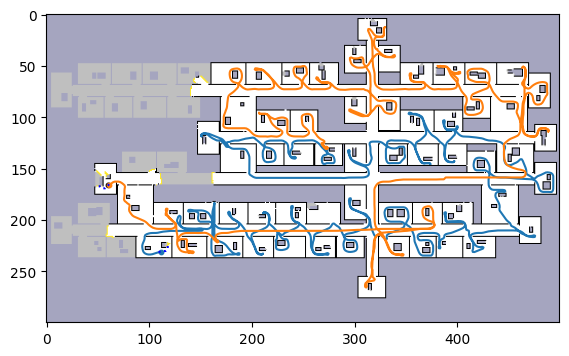

----------------------------------------
Counter: 1572
Robot0: (106.98, 226.78)
Total motion: 2840.40
Robot1: (50.48, 158.40)
Total motion: 2840.40
Available frontiers: {<lsp.core.Frontier object at 0x7f831121ad60>, <lsp.core.Frontier object at 0x7f8335b146d0>, <lsp.core.Frontier object at 0x7f8335b14610>, <lsp.core.Frontier object at 0x7f832e10feb0>, <lsp.core.Frontier object at 0x7f8335b14df0>, <lsp.core.Frontier object at 0x7f8335cb7580>, <lsp.core.Frontier object at 0x7f8335cb74f0>, <lsp.core.Frontier object at 0x7f8335b143d0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f831121ad60>, <lsp.core.Frontier object at 0x7f8335cb74f0>]


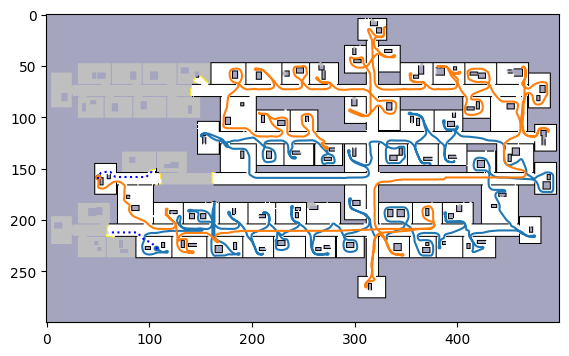

----------------------------------------
Counter: 1584
Robot0: (89.77, 214.29)
Total motion: 2862.00
Robot1: (69.39, 158.40)
Total motion: 2862.00
Available frontiers: {<lsp.core.Frontier object at 0x7f83358fe850>, <lsp.core.Frontier object at 0x7f8335990700>, <lsp.core.Frontier object at 0x7f8335990970>, <lsp.core.Frontier object at 0x7f8335990670>, <lsp.core.Frontier object at 0x7f83359906a0>, <lsp.core.Frontier object at 0x7f8335990280>, <lsp.core.Frontier object at 0x7f8335990af0>, <lsp.core.Frontier object at 0x7f83358feaf0>, <lsp.core.Frontier object at 0x7f83359908e0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358fe850>, <lsp.core.Frontier object at 0x7f8335990af0>]


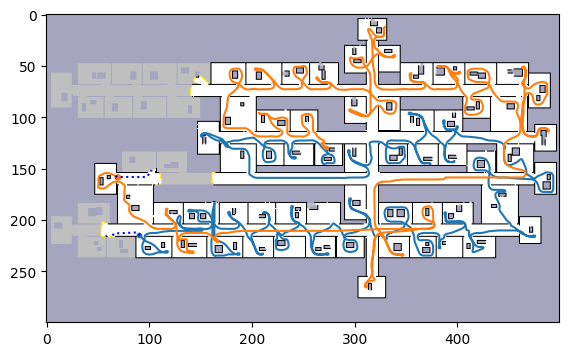

----------------------------------------
Counter: 1596
Robot0: (68.79, 213.17)
Total motion: 2883.60
Robot1: (90.79, 158.51)
Total motion: 2883.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83358d9670>, <lsp.core.Frontier object at 0x7f83358d92b0>, <lsp.core.Frontier object at 0x7f83358d94c0>, <lsp.core.Frontier object at 0x7f83358d91c0>, <lsp.core.Frontier object at 0x7f83358d9880>, <lsp.core.Frontier object at 0x7f83358d9760>, <lsp.core.Frontier object at 0x7f83358d9040>, <lsp.core.Frontier object at 0x7f83358d9160>, <lsp.core.Frontier object at 0x7f83358d9d60>, <lsp.core.Frontier object at 0x7f83358d98b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83358d94c0>, <lsp.core.Frontier object at 0x7f83358d9d60>]


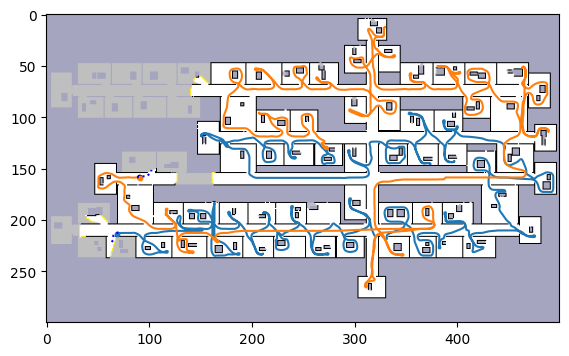

----------------------------------------
Counter: 1608
Robot0: (77.57, 221.01)
Total motion: 2905.20
Robot1: (95.99, 144.98)
Total motion: 2905.20
Available frontiers: {<lsp.core.Frontier object at 0x7f83383935e0>, <lsp.core.Frontier object at 0x7f8335de55e0>, <lsp.core.Frontier object at 0x7f832e0b3e20>, <lsp.core.Frontier object at 0x7f83383936d0>, <lsp.core.Frontier object at 0x7f833851a8b0>, <lsp.core.Frontier object at 0x7f8311116d30>, <lsp.core.Frontier object at 0x7f8338393c40>, <lsp.core.Frontier object at 0x7f8335de5190>, <lsp.core.Frontier object at 0x7f8335de5460>, <lsp.core.Frontier object at 0x7f8335b2a670>, <lsp.core.Frontier object at 0x7f83383932e0>, <lsp.core.Frontier object at 0x7f8335de5880>, <lsp.core.Frontier object at 0x7f8335de54f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e0b3e20>, <lsp.core.Frontier object at 0x7f83383935e0>]


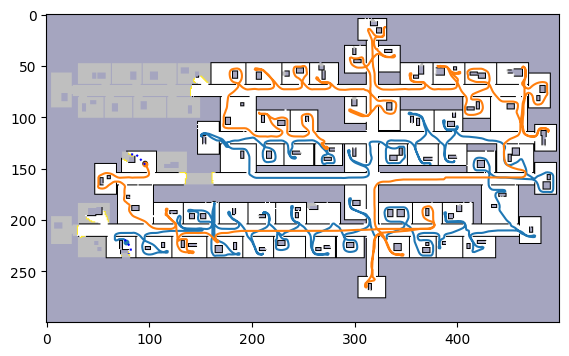

----------------------------------------
Counter: 1620
Robot0: (75.00, 234.50)
Total motion: 2926.80
Robot1: (78.71, 137.11)
Total motion: 2926.80
Available frontiers: {<lsp.core.Frontier object at 0x7f832e0b3040>, <lsp.core.Frontier object at 0x7f832e0b39a0>, <lsp.core.Frontier object at 0x7f83383524c0>, <lsp.core.Frontier object at 0x7f8338382af0>, <lsp.core.Frontier object at 0x7f833848cbe0>, <lsp.core.Frontier object at 0x7f833848ce80>, <lsp.core.Frontier object at 0x7f8335de5790>, <lsp.core.Frontier object at 0x7f833848c910>, <lsp.core.Frontier object at 0x7f833848c4c0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e0b39a0>, <lsp.core.Frontier object at 0x7f832e0b3040>]


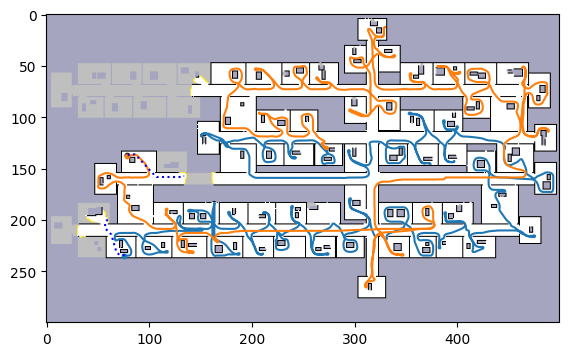

----------------------------------------
Counter: 1632
Robot0: (63.52, 219.05)
Total motion: 2948.40
Robot1: (94.31, 145.45)
Total motion: 2948.40
Available frontiers: {<lsp.core.Frontier object at 0x7f83383f87c0>, <lsp.core.Frontier object at 0x7f83383f8b20>, <lsp.core.Frontier object at 0x7f83383f8a90>, <lsp.core.Frontier object at 0x7f83383f8370>, <lsp.core.Frontier object at 0x7f83383f8610>, <lsp.core.Frontier object at 0x7f83383f8820>, <lsp.core.Frontier object at 0x7f83383f8940>, <lsp.core.Frontier object at 0x7f83383f8310>, <lsp.core.Frontier object at 0x7f83383f8520>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83383f8a90>, <lsp.core.Frontier object at 0x7f83383f87c0>]


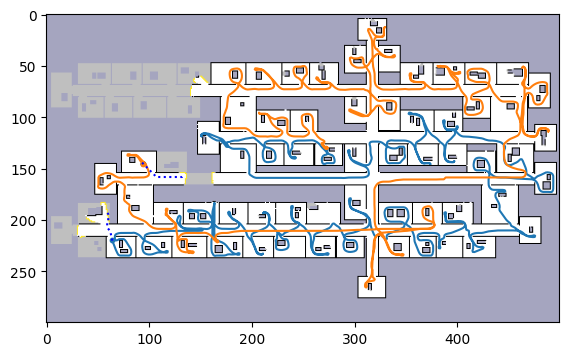

----------------------------------------
Counter: 1644
Robot0: (58.49, 199.67)
Total motion: 2970.00
Robot1: (110.51, 158.54)
Total motion: 2970.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335d81940>, <lsp.core.Frontier object at 0x7f8335c55100>, <lsp.core.Frontier object at 0x7f8335c55d00>, <lsp.core.Frontier object at 0x7f8335d819d0>, <lsp.core.Frontier object at 0x7f8335d81730>, <lsp.core.Frontier object at 0x7f8335d81e80>, <lsp.core.Frontier object at 0x7f8335d81fa0>, <lsp.core.Frontier object at 0x7f8335d81f70>, <lsp.core.Frontier object at 0x7f8335c554c0>, <lsp.core.Frontier object at 0x7f8335d81b20>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335d81fa0>, <lsp.core.Frontier object at 0x7f8335d81e80>]


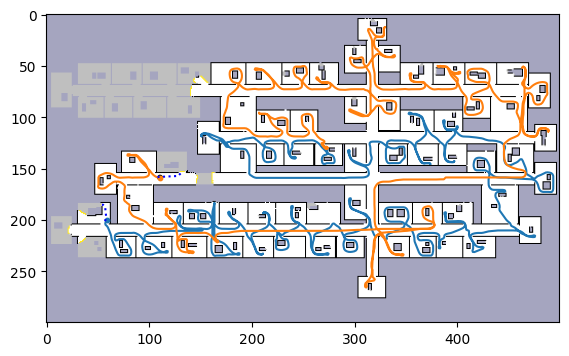

----------------------------------------
Counter: 1656
Robot0: (49.24, 186.49)
Total motion: 2991.60
Robot1: (129.62, 154.57)
Total motion: 2991.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83359b1d60>, <lsp.core.Frontier object at 0x7f83359b1760>, <lsp.core.Frontier object at 0x7f83359b18b0>, <lsp.core.Frontier object at 0x7f83359b1280>, <lsp.core.Frontier object at 0x7f83359b13a0>, <lsp.core.Frontier object at 0x7f83359b1580>, <lsp.core.Frontier object at 0x7f83359b16a0>, <lsp.core.Frontier object at 0x7f83359b1e50>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83359b1e50>, <lsp.core.Frontier object at 0x7f83359b1d60>]


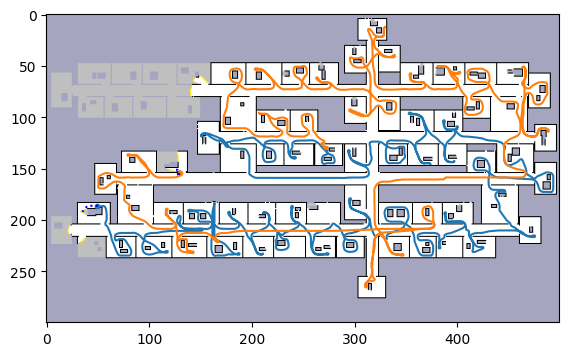

----------------------------------------
Counter: 1668
Robot0: (40.38, 198.50)
Total motion: 3013.20
Robot1: (122.60, 140.51)
Total motion: 3013.20
Available frontiers: {<lsp.core.Frontier object at 0x7f832e023c70>, <lsp.core.Frontier object at 0x7f832e023dc0>, <lsp.core.Frontier object at 0x7f832e023a30>, <lsp.core.Frontier object at 0x7f83358d6af0>, <lsp.core.Frontier object at 0x7f832e023ee0>, <lsp.core.Frontier object at 0x7f832e023df0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f832e023ee0>, <lsp.core.Frontier object at 0x7f832e023dc0>]


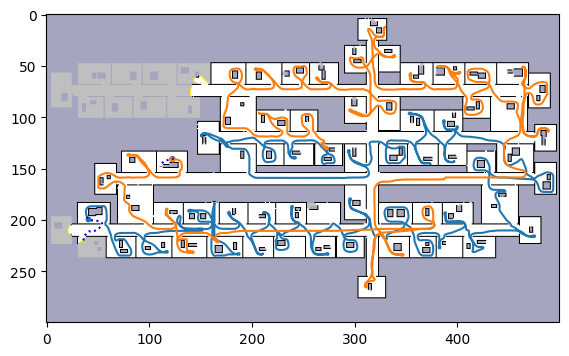

----------------------------------------
Counter: 1680
Robot0: (51.86, 207.92)
Total motion: 3034.80
Robot1: (131.51, 144.08)
Total motion: 3034.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8311183c40>, <lsp.core.Frontier object at 0x7f8311183790>, <lsp.core.Frontier object at 0x7f8335a8b8e0>, <lsp.core.Frontier object at 0x7f83111834c0>, <lsp.core.Frontier object at 0x7f8311183af0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83111834c0>, <lsp.core.Frontier object at 0x7f8335a8b8e0>]


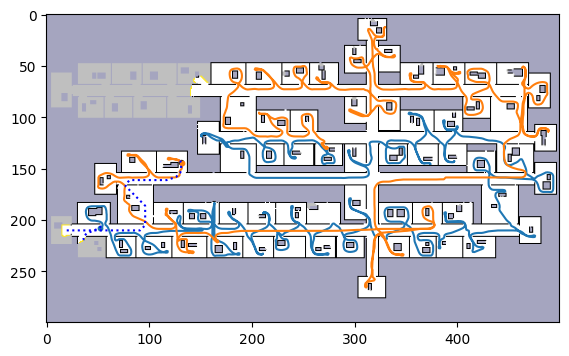

----------------------------------------
Counter: 1692
Robot0: (40.94, 219.47)
Total motion: 3056.40
Robot1: (121.44, 159.09)
Total motion: 3056.40
Available frontiers: {<lsp.core.Frontier object at 0x7f8335c673d0>, <lsp.core.Frontier object at 0x7f8335c67070>, <lsp.core.Frontier object at 0x7f83111866a0>, <lsp.core.Frontier object at 0x7f8335c67d90>, <lsp.core.Frontier object at 0x7f8335c67490>, <lsp.core.Frontier object at 0x7f8335c67790>, <lsp.core.Frontier object at 0x7f83359b18e0>, <lsp.core.Frontier object at 0x7f8335c671f0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335c67790>, <lsp.core.Frontier object at 0x7f8335c673d0>]


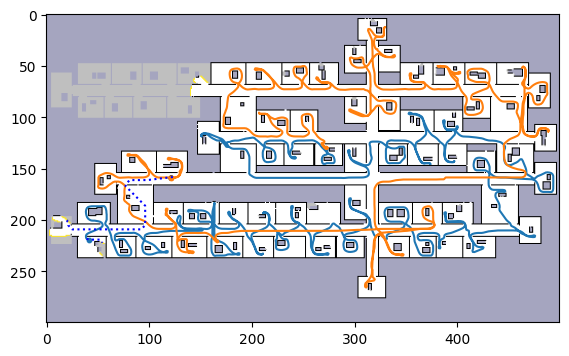

----------------------------------------
Counter: 1704
Robot0: (55.53, 228.72)
Total motion: 3078.00
Robot1: (99.89, 160.50)
Total motion: 3078.00
Available frontiers: {<lsp.core.Frontier object at 0x7f8335a8b6a0>, <lsp.core.Frontier object at 0x7f832e0a9220>, <lsp.core.Frontier object at 0x7f832e0a97f0>, <lsp.core.Frontier object at 0x7f832e0a98b0>, <lsp.core.Frontier object at 0x7f8335a8b550>, <lsp.core.Frontier object at 0x7f832e0a96a0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335a8b550>, <lsp.core.Frontier object at 0x7f832e0a9220>]


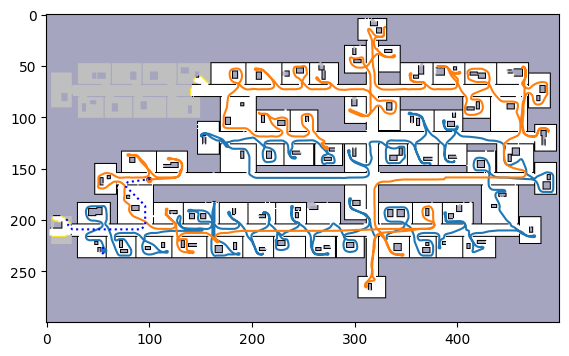

----------------------------------------
Counter: 1716
Robot0: (42.39, 224.43)
Total motion: 3099.60
Robot1: (78.91, 164.26)
Total motion: 3099.60
Available frontiers: {<lsp.core.Frontier object at 0x7f83359db910>, <lsp.core.Frontier object at 0x7f83359db490>, <lsp.core.Frontier object at 0x7f83359dbb20>, <lsp.core.Frontier object at 0x7f83359db670>, <lsp.core.Frontier object at 0x7f83359db700>, <lsp.core.Frontier object at 0x7f83359db790>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f83359db700>, <lsp.core.Frontier object at 0x7f83359dbb20>]


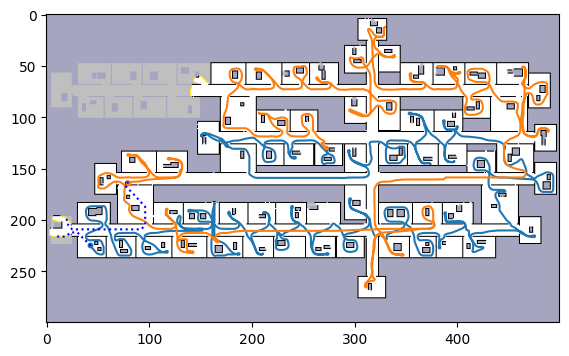

----------------------------------------
Counter: 1728
Robot0: (25.77, 212.38)
Total motion: 3121.20
Robot1: (89.10, 179.63)
Total motion: 3121.20
Available frontiers: {<lsp.core.Frontier object at 0x7f8335b76520>, <lsp.core.Frontier object at 0x7f8335bf74c0>, <lsp.core.Frontier object at 0x7f8335b76a60>, <lsp.core.Frontier object at 0x7f8335bf7130>, <lsp.core.Frontier object at 0x7f832e0a2d90>, <lsp.core.Frontier object at 0x7f8335b76460>, <lsp.core.Frontier object at 0x7f8335bf7160>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335b76460>, <lsp.core.Frontier object at 0x7f8335b76a60>]


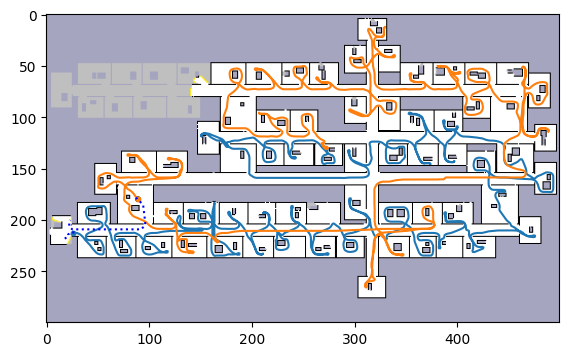

----------------------------------------
Counter: 1740
Robot0: (4.31, 211.50)
Total motion: 3142.80
Robot1: (97.36, 198.85)
Total motion: 3142.80
Available frontiers: {<lsp.core.Frontier object at 0x7f8335aa56d0>, <lsp.core.Frontier object at 0x7f8335a8b850>, <lsp.core.Frontier object at 0x7f8335a8b6a0>, <lsp.core.Frontier object at 0x7f831117b850>, <lsp.core.Frontier object at 0x7f8335b765b0>}
Robots chosen subgoals: [<lsp.core.Frontier object at 0x7f8335aa56d0>, <lsp.core.Frontier object at 0x7f8335a8b850>]


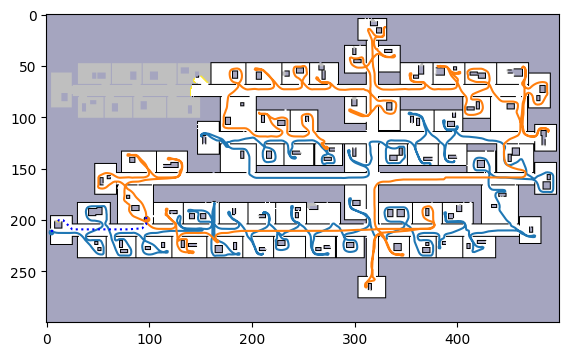

ValueError: 'a' cannot be empty unless no samples are taken

In [5]:
# Instantiate the simulated environment
# world = environments.simulated.OccupancyGridWorld(
#         known_map,
#         map_data,
#         num_breadcrumb_elements=args.num_breadcrumb_elements,
#         min_breadcrumb_signed_distance=4.0 * args.base_resolution)

# builder = environments.simulated.WorldBuildingUnityBridge
# with builder(args.unity_path) as unity_bridge:
#     unity_bridge.make_world(world)

colors = plt.get_cmap('tab10').colors

if True:
    simulator = lsp.simulators.Simulator(known_map,
                                         args,
                                         unity_bridge=None,
                                         world=None,
                                         verbose=False)
    # set the inflation radius
    simulator.frontier_grouping_inflation_radius = simulator.inflation_radius

    planning_loop = mr_exploration.planners.MRPlanningLoop(known_map,
                                                  simulator,
                                                  unity_bridge=None,
                                                  robots=robot_team,
                                                  args=args,
                                                  verbose=False)
    for counter, step_data in enumerate(planning_loop):
        planner.update({'images': step_data['images']},
                        step_data['robot_grids'],
                        step_data['subgoals'],
                        step_data['robot_poses'],
                        step_data['visibility_masks'],)
        joint_action = planner.compute_selected_subgoal()
        planning_loop.set_chosen_subgoals(joint_action, counter)

        # Print and plot in every 12 steps
        if counter % 12 == 0:
            # printing
            print('----------------------------------------')
            print(f'Counter: {counter}')
            #print(f'Goal: {goal.x}, {goal.y}')
            for i, robot in enumerate(robot_team):
                print(f'Robot{i}: ({robot.pose.x:.2f}, {robot.pose.y:.2f})')
                print(f'Total motion: {robot_team[0].net_motion:.2f}')
    
                # plotting
                plt.ion()
                plt.figure(1, figsize=(12, 4))
                plt.clf()
                # mrlsp.utils.plotting.visualize_robots(args=args,
                #                                       robots=robot_team,
                #                                       observed_map=planner.observed_map,
                #                                       pano_images=None,
                #                                       subgoals=planner.subgoals,
                #                                       goal_pose=goal,
                #                                       paths=planning_loop.paths,
                #                                       known_map=known_map,
                #                                       timestamp=counter)
                # plt.show()
                #goal_pose=goal
                robots=robot_team
                subgoals=planner.subgoals
                observed_map=planner.observed_map
                paths=planning_loop.paths
                ax = plt.gca()
                mr_exploration.utils.plotting.plot_grid_with_frontiers(ax, observed_map, known_map, subgoals)
                mr_exploration.utils.plotting.plot_pose(ax, robots[i].pose, filled=False) #made sure had 2 positional arguments
            print(f'Available frontiers: {subgoals}')
            print(f'Robots chosen subgoals: {planning_loop.chosen_subgoals}')
            
            for i in range(args.num_robots):
                mr_exploration.utils.plotting.plot_pose(ax, robots[i].pose, color=colors[i])
                mr_exploration.utils.plotting.plot_pose_path(ax, robots[i].all_poses, color=colors[i])
                if paths[i] is not None:
                    mr_exploration.utils.plotting.plot_path(ax, paths[i])

            plt.show()